<a href="https://colab.research.google.com/github/MrcCap/AnotherTest4PACS/blob/main/DenseVariational_AnalyticalProblems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing stuff

In [ ]:
import torch


from torch.profiler import profile, ProfilerActivity, record_function
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch import optim
from torch.nn.parameter import Parameter
from torch.autograd import Variable
from torchsummary import summary
import torch.nn.functional as F
from torch import Tensor
from torch.nn import functional as F, init
from torch.nn.parameter import Parameter

In [ ]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from tqdm import tqdm

from scipy.stats import norm

import math

import torch.nn as nn
from torch.autograd import Variable
import time
from tqdm import tqdm

In [ ]:
import numpy as np
from scipy import stats

def generate_data(n_samples=100, noise_std=0.1, x_min=-3*np.pi, x_max=3*np.pi,
                  function=np.sin, amplitude=1., distribution='uniform',
                  distribution_params=None):

    if distribution == 'uniform':
        x = np.random.uniform(x_min, x_max, n_samples)
    elif distribution == 'gaussian':
        mean = (x_max + x_min) / 2
        std = (x_max - x_min) / 6  # 99.7% of values within the range
        x = np.random.normal(mean, std, n_samples)
        x = np.clip(x, x_min, x_max)  # Ensure values are within the specified range
    elif distribution == 'beta':
        if distribution_params is None:
            a, b = 2, 2  # Default parameters for beta distribution
        else:
            a, b = distribution_params
        x = stats.beta.rvs(a, b, size=n_samples)
        x = x * (x_max - x_min) + x_min  # Scale to the desired range
    else:
        raise ValueError("Unsupported distribution. Choose 'uniform', 'gaussian', or 'beta'.")

    y = amplitude * function(x) + np.random.normal(0, noise_std, n_samples)

    return x.reshape(-1, 1), y.reshape(-1, 1)

# Sine function
x_sine, y_sine = generate_data(n_samples=100, noise_std=0.1, x_min=-3*np.pi, x_max=3*np.pi,
                               function=np.sin, amplitude=1, distribution='uniform')

# Cubic function
def cubic_function(x):
    return x**3 - 0.5*x**2 - x

x_cubic, y_cubic = generate_data(n_samples=100, noise_std=0.2, x_min=-2, x_max=2,
                                 function=cubic_function, distribution='gaussian')

# Step function
def step_function(x):
    return (x > 0).astype(float)

x_step, y_step = generate_data(n_samples=100, noise_std=0.1, x_min=-2, x_max=2,
                               function=step_function, distribution='beta',
                               distribution_params=(2, 2))

# Models

## Dense Variational model

### Dense Variational layer class

In [ ]:
class VariationalDense(nn.Module):
    def __init__(self, input_shape, output_shape,
                 weight_mask=None, bias_mask=None,
                 prior_mu=0, prior_sigma=1,
                 alpha=0.99) -> None:
        super(VariationalDense, self).__init__()

        self.input_shape = input_shape
        self.output_shape = output_shape

        self.in_features = torch.prod(torch.tensor(input_shape)).item()
        self.out_features = torch.prod(torch.tensor(output_shape)).item()

        self.weights_mu = Parameter(torch.empty(self.in_features, self.out_features, requires_grad=True))
        nn.init.xavier_uniform_(self.weights_mu)
        self.weights_rho = Parameter(torch.ones(self.in_features, self.out_features)* -2, requires_grad=True)

        self.bias_mu = Parameter(torch.zeros(self.out_features), requires_grad=True)
        self.bias_rho = Parameter(torch.ones(self.out_features)*-1, requires_grad=True)

        self.alpha = alpha
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma

        if weight_mask is None:
            self.weight_mask = torch.ones_like(self.weights_mu, dtype=torch.bool)
        else:
            self.weight_mask = weight_mask

        # Initialize bias_mask
        if bias_mask is None:
            self.bias_mask = torch.ones_like(self.bias_mu, dtype=torch.bool)
        else:
            self.bias_mask = bias_mask

    def forward(self, x) -> torch.Tensor:
        x = x.view(-1, self.in_features)
        eps_weights = torch.randn(self.in_features, self.out_features, device=x.device)
        weights = self.weights_mu + eps_weights * F.softplus(self.weights_rho)

        eps_bias = torch.randn(self.out_features, device=x.device)
        bias = self.bias_mu + eps_bias * F.softplus(self.bias_rho)

        output = torch.mm(x, weights) + bias

        return output

    def kl_divergence(self):
        weights_var = F.softplus(self.weights_rho) ** 2
        weights_kl = 0.5 * torch.sum(
            (self.weights_mu - self.prior_mu) ** 2 / (self.prior_sigma ** 2) +
            weights_var / (self.prior_sigma ** 2) -
            1 - torch.log(weights_var) + 2 * torch.log(torch.tensor(self.prior_sigma))
        )

        bias_var = F.softplus(self.bias_rho) ** 2
        bias_kl = 0.5 * torch.sum(
            (self.bias_mu - self.prior_mu) ** 2 / (self.prior_sigma ** 2) +
            bias_var / (self.prior_sigma ** 2) -
            1 - torch.log(bias_var) + 2 * torch.log(torch.tensor(self.prior_sigma))
        )

        return weights_kl + bias_kl

    def identify_significant_weights(self) -> torch.Tensor:
        weights_var = F.softplus(self.weights_rho) ** 2
        z_score = torch.abs(self.weights_mu) / torch.sqrt(weights_var)
        return (z_score > self.alpha).float()

    def update_weight_mask(self):
        self.weight_mask = self.identify_significant_weights()

    def mask_gradients(self):
        with torch.no_grad():
            self.weights_mu.grad = self.weights_mu.grad * self.weight_mask
            self.weights_rho.grad = self.weights_rho.grad * self.weight_mask

    def active_parameters(self):
        return self.weight_mask.sum() + self.bias_mask.sum()

    def predict_with_uncertainty(self, x, n_samples=100, confidence=0.95):
        x = x.view(-1, self.in_features)

        # Collect samples
        samples = []
        for _ in range(n_samples):
            eps_weights = torch.randn_like(self.weights_mu)
            eps_bias = torch.randn_like(self.bias_mu)

            weights = self.weights_mu + eps_weights * F.softplus(self.weights_rho)
            bias = self.bias_mu + eps_bias * F.softplus(self.bias_rho)

            output = torch.mm(x, weights) + bias
            samples.append(output)

        # Stack samples
        samples = torch.stack(samples, dim=-1)

        # Calculate mean and confidence intervals
        mean = samples.mean(dim=-1)
        std = samples.std(dim=-1)

        z_score = norm.ppf((1 + confidence) / 2)
        lower_bound = mean - z_score * std
        upper_bound = mean + z_score * std

        return mean, lower_bound, upper_bound

## VariationalNet

### Class definition

In [ ]:
class VariationalNet(nn.Module):
    def __init__(self, input_shape, hidden_sizes, output_size, alpha=0.99):
        super(VariationalNet, self).__init__()

        self.input_shape = input_shape
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size

        layers = []
        in_features = torch.prod(torch.tensor(input_shape)).item()

        for hidden_size in hidden_sizes:
            layers.append(VariationalDense(in_features, hidden_size, alpha=alpha))
            layers.append(nn.ReLU())
            in_features = hidden_size

        layers.append(VariationalDense(in_features, output_size, alpha=alpha))

        self.layers = nn.ModuleList(layers)

        # Initialize history
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'weight_percentage': []
        }

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for layer in self.layers:
            x = layer(x)
        return x

    def identify_significant_weights(self):
        for layer in self.layers:
            if isinstance(layer, VariationalDense):
                layer.identify_significant_weights()

    def update_weight_masks(self):
        for layer in self.layers:
            if isinstance(layer, VariationalDense):
                layer.update_weight_mask()

    def total_kl_divergence(self):
        return sum(layer.kl_divergence() for layer in self.layers if isinstance(layer, VariationalDense))

    def mask_gradients(self):
        for layer in self.layers:
            if isinstance(layer, VariationalDense):
                layer.mask_gradients()

    def update_history(self, train_loss, train_acc, val_loss, val_acc, weight_percentage):
        self.history['train_loss'].append(train_loss)
        self.history['train_acc'].append(train_acc)
        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_acc)
        self.history['weight_percentage'].append(weight_percentage)

    def predict_with_uncertainty(self, x, n_samples=100, confidence=0.95):
        self.eval()  # Set the model to evaluation mode
        x = x.view(x.size(0), -1)  # Flatten the input

        # Collect samples
        samples = []
        for _ in range(n_samples):
            sample = x
            for layer in self.layers:
                if isinstance(layer, VariationalDense):
                    eps_weights = torch.randn_like(layer.weights_mu)
                    eps_bias = torch.randn_like(layer.bias_mu)

                    weights = layer.weights_mu + eps_weights * F.softplus(layer.weights_rho)
                    bias = layer.bias_mu + eps_bias * F.softplus(layer.bias_rho)

                    sample = torch.mm(sample, weights) + bias
                else:
                    sample = layer(sample)
            samples.append(sample)

        # Stack samples
        samples = torch.stack(samples, dim=-1)

        # Calculate mean and confidence intervals
        mean = samples.mean(dim=-1)
        std = samples.std(dim=-1)

        z_score = norm.ppf((1 + confidence) / 2)
        lower_bound = mean - z_score * std
        upper_bound = mean + z_score * std

        return mean, lower_bound, upper_bound


### Train loop definition

In [ ]:
def train_and_validate(model, optimizer, train_loader, val_loader, num_epochs, device, update_weight_mask = False):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        active_params = sum(layer.active_parameters() for layer in model.modules() if isinstance(layer, VariationalDense))
        weight_percentage = 100 * active_params / total_params *2
        if epoch % 100 == 0:
            print(f"Active parameters: {active_params}/{total_params} ({weight_percentage:.2f}%)")

        # Training
        model.train()
        train_loss = 0.0
        train_mse = 0.0

        train_bar = tqdm(train_loader, desc="Training")
        for data, target in train_bar:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)

            # Compute losses
            loss = F.mse_loss(output, target)
            kl_div = model.total_kl_divergence() * 0.001

            # Total loss is the sum of MSE and KL divergence
            total_loss = loss + kl_div

            total_loss.backward()
            optimizer.step()

            train_loss += total_loss.item() * data.size(0)
            train_mse += loss.item() * data.size(0)

            # Update progress bar
            train_bar.set_postfix({
                'loss': f"{total_loss.item():.4f}",
                'mse': f"{loss.item():.4f}",
                'kl_div': f"{kl_div.item():.4f}"
            })

        train_loss = train_loss / len(train_loader.dataset)
        train_mse = train_mse / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        val_mse = 0.0

        val_bar = tqdm(val_loader, desc="Validation")
        with torch.no_grad():
            for data, target in val_bar:
                data, target = data.to(device), target.to(device)

                output = model(data)
                loss = F.mse_loss(output, target)
                kl_div = model.total_kl_divergence() * 0.001
                total_loss = loss + kl_div

                val_loss += total_loss.item() * data.size(0)
                val_mse += loss.item() * data.size(0)

                # Update progress bar
                val_bar.set_postfix({
                    'loss': f"{total_loss.item():.4f}",
                    'mse': f"{loss.item():.4f}",
                    'kl_div': f"{kl_div.item():.4f}"
                })

        val_loss = val_loss / len(val_loader.dataset)
        val_mse = val_mse / len(val_loader.dataset)
        if epoch % 100 == 0:
            print(f"Train Loss: {train_loss:.4f}, Train MSE: {train_mse:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val MSE: {val_mse:.4f}")

        # Update history
        model.update_history(train_loss, train_mse, val_loss, val_mse, weight_percentage)

        # Update weight masks after each epoch
        if update_weight_mask:
            model.update_weight_masks()



### History plotting function

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training_history(model):
    history = model.history
    epochs = range(1, len(history['train_loss']) + 1)

    # Set style
    sns.set_style("whitegrid")

    # Create a figure with a single plot
    fig, ax1 = plt.subplots(figsize=(12, 8))
    fig.suptitle('Training History', fontsize=16)

    # Plot losses on the left y-axis
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', color='#1f77b4', fontsize=12)
    ax1.plot(epochs, history['train_loss'], color='#1f77b4', linestyle='-', label='Training Loss')
    ax1.plot(epochs, history['val_loss'], color='#ff7f0e', linestyle='--', label='Validation Loss')
    ax1.tick_params(axis='y', labelcolor='#1f77b4')

    # Create a second y-axis for weight percentage
    ax2 = ax1.twinx()
    ax2.set_ylabel('Active Weights (%)', color='#2ca02c', fontsize=12)
    ax2.plot(epochs, history['weight_percentage'], color='#2ca02c', linestyle='-', label='Active Weights')
    ax2.tick_params(axis='y', labelcolor='#2ca02c')

    # Set the y-axis limit for weight percentage to 100
    ax2.set_ylim(0, 100)

    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=10)

    plt.title('Training Metrics Over Epochs', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

### Plot uncertainty prediction function

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_uncertainty_prediction(model, x_test, y_test, x_train, y_train, n_samples=10000):
    model.eval()
    x_test_tensor = torch.FloatTensor(x_test).to(next(model.parameters()).device)

    with torch.no_grad():
        mean, lower, upper = model.predict_with_uncertainty(x_test_tensor, n_samples)

    mean = mean.cpu().numpy()
    lower = lower.cpu().numpy()
    upper = upper.cpu().numpy()

    plt.figure(figsize=(12, 8))

    # Sort x_test and rearrange other arrays accordingly
    sort_idx = np.argsort(x_test.squeeze())
    x_test_sorted = x_test[sort_idx]
    y_test_sorted = y_test[sort_idx]
    mean_sorted = mean[sort_idx]
    lower_sorted = lower[sort_idx]
    upper_sorted = upper[sort_idx]

    # Plot the confidence interval
    plt.fill_between(x_test_sorted.squeeze(), lower_sorted.squeeze(), upper_sorted.squeeze(),
                     color='#ff7f0e', alpha=0.3, label='95% CI')

    # Plot the mean prediction
    plt.plot(x_test_sorted, mean_sorted, color='#ff7f0e', label='Mean prediction', linewidth=2)

    # Plot the training data points
    plt.scatter(x_train, y_train, color='#1f77b4', alpha=0.6, label='Training data', s=30, zorder=3)

    # Plot the test data points
    plt.scatter(x_test, y_test, color='#d62728', alpha=0.1, label='Test data', s=30, zorder=3)

    plt.legend(fontsize=12, loc='upper left')
    plt.title('Variational Neural Network: Prediction with Uncertainty', fontsize=20)
    plt.xlabel('x', fontsize=14)
    plt.ylabel('y', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # Set style
    sns.set_style("whitegrid")
    plt.tight_layout()

    plt.show()

### Sine data

#### Dataset Generation

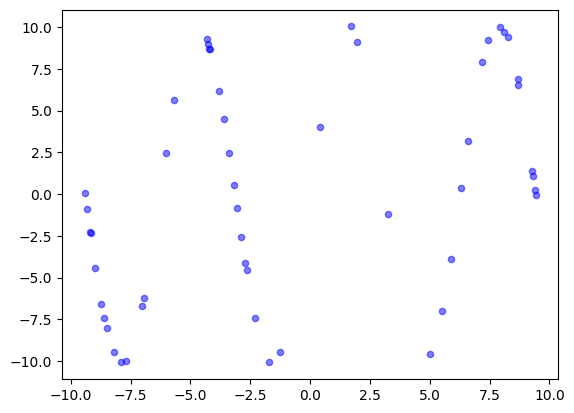

In [ ]:
# Generate data
x_sine, y_sine = generate_data(n_samples=50, noise_std=0.1, x_min=-3*np.pi, x_max=3*np.pi,
                               function=np.sin, amplitude=10., distribution='beta', distribution_params=(0.5, 0.5))


# Convert to PyTorch tensors
x_sine_tensor = torch.FloatTensor(x_sine)
y_sine_tensor = torch.FloatTensor(y_sine)

# Create dataset
dataset = TensorDataset(x_sine_tensor, y_sine_tensor)

# Split into train and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Plot the dataset points
plt.scatter(x_sine, y_sine, color='blue', alpha=0.5, label='Training data', s=20)
plt.show()

#### Model definition and training

In [ ]:
# Initialize model
input_shape = (1,)
hidden_sizes = [128, 32]
output_size = 1

model = VariationalNet(input_shape, hidden_sizes, output_size)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1000
train_and_validate(model, optimizer, train_loader, val_loader, num_epochs, device)

Epoch 1/1000
Active parameters: 4417/8834 (100.00%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 141.99it/s, loss=48.9295, mse=42.1310, kl_div=6.7985]


Train Loss: 50.6908, Train MSE: 43.8622
Val Loss: 48.9295, Val MSE: 42.1310
Epoch 2/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.26it/s, loss=48.0746, mse=41.2905, kl_div=6.7840]


Epoch 3/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.98it/s, loss=62.4192, mse=55.6437, kl_div=6.7755]


Epoch 4/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.75it/s, loss=46.5850, mse=39.8148, kl_div=6.7703]


Epoch 5/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.79it/s, loss=70.0058, mse=63.2394, kl_div=6.7664]


Epoch 6/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.66it/s, loss=45.5247, mse=38.7617, kl_div=6.7630]


Epoch 7/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 141.20it/s, loss=61.0642, mse=54.3042, kl_div=6.7600]


Epoch 8/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.39it/s, loss=69.2363, mse=62.4795, kl_div=6.7568]


Epoch 9/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.48it/s, loss=48.3488, mse=41.5951, kl_div=6.7537]


Epoch 10/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.00it/s, loss=90.5902, mse=83.8402, kl_div=6.7500]


Epoch 11/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 191.49it/s, loss=67.2158, mse=60.4698, kl_div=6.7460]


Epoch 12/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 154.48it/s, loss=73.6662, mse=66.9244, kl_div=6.7418]


Epoch 13/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.33it/s, loss=49.8542, mse=43.1168, kl_div=6.7374]


Epoch 14/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 198.17it/s, loss=47.4332, mse=40.7003, kl_div=6.7329]


Epoch 15/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 176.30it/s, loss=58.1939, mse=51.4656, kl_div=6.7282]


Epoch 16/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 189.61it/s, loss=42.0278, mse=35.3040, kl_div=6.7238]


Epoch 17/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 147.15it/s, loss=55.5675, mse=48.8480, kl_div=6.7195]


Epoch 18/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 265.51it/s, loss=41.2307, mse=34.5157, kl_div=6.7150]


Epoch 19/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 162.09it/s, loss=53.8202, mse=47.1095, kl_div=6.7107]


Epoch 20/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.19it/s, loss=54.6222, mse=47.9158, kl_div=6.7064]


Epoch 21/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.10it/s, loss=90.6830, mse=83.9808, kl_div=6.7022]


Epoch 22/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 117.42it/s, loss=66.8287, mse=60.1309, kl_div=6.6978]


Epoch 23/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.26it/s, loss=109.3317, mse=102.6384, kl_div=6.6933]


Epoch 24/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.55it/s, loss=80.3617, mse=73.6730, kl_div=6.6887]


Epoch 25/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 114.98it/s, loss=60.6571, mse=53.9729, kl_div=6.6842]


Epoch 26/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.76it/s, loss=95.3943, mse=88.7146, kl_div=6.6798]


Epoch 27/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.41it/s, loss=55.6083, mse=48.9333, kl_div=6.6751]


Epoch 28/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 136.10it/s, loss=45.5966, mse=38.9263, kl_div=6.6703]


Epoch 29/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.39it/s, loss=43.4274, mse=36.7620, kl_div=6.6654]


Epoch 30/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.21it/s, loss=44.5358, mse=37.8753, kl_div=6.6605]


Epoch 31/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 114.75it/s, loss=45.9526, mse=39.2968, kl_div=6.6558]


Epoch 32/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.96it/s, loss=69.1095, mse=62.4583, kl_div=6.6512]


Epoch 33/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 69.15it/s, loss=46.1897, mse=39.5432, kl_div=6.6465]


Epoch 34/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 65.61it/s, loss=49.2070, mse=42.5652, kl_div=6.6419]


Epoch 35/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 72.82it/s, loss=59.4916, mse=52.8542, kl_div=6.6373]


Epoch 36/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.25it/s, loss=57.9414, mse=51.3086, kl_div=6.6328]


Epoch 37/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.55it/s, loss=51.0575, mse=44.4292, kl_div=6.6283]


Epoch 38/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.52it/s, loss=76.5825, mse=69.9589, kl_div=6.6236]


Epoch 39/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.95it/s, loss=64.4208, mse=57.8017, kl_div=6.6190]


Epoch 40/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.16it/s, loss=50.1737, mse=43.5593, kl_div=6.6144]


Epoch 41/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.26it/s, loss=46.9345, mse=40.3249, kl_div=6.6096]


Epoch 42/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 22.79it/s, loss=39.9605, mse=33.3558, kl_div=6.6048]


Epoch 43/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.11it/s, loss=60.4873, mse=53.8874, kl_div=6.5998]


Epoch 44/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 23.75it/s, loss=45.7382, mse=39.1433, kl_div=6.5948]


Epoch 45/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.88it/s, loss=52.7039, mse=46.1141, kl_div=6.5898]


Epoch 46/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.42it/s, loss=57.3501, mse=50.7655, kl_div=6.5846]


Epoch 47/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 61.68it/s, loss=54.5860, mse=48.0067, kl_div=6.5793]


Epoch 48/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.94it/s, loss=59.7879, mse=53.2135, kl_div=6.5743]


Epoch 49/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.96it/s, loss=56.4377, mse=49.8679, kl_div=6.5698]


Epoch 50/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.78it/s, loss=48.6569, mse=42.0917, kl_div=6.5652]


Epoch 51/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.07it/s, loss=55.7791, mse=49.2185, kl_div=6.5607]


Epoch 52/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.80it/s, loss=91.3617, mse=84.8056, kl_div=6.5560]


Epoch 53/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 76.83it/s, loss=48.3124, mse=41.7613, kl_div=6.5511]


Epoch 54/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.86it/s, loss=66.1288, mse=59.5827, kl_div=6.5461]


Epoch 55/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 117.33it/s, loss=65.6245, mse=59.0834, kl_div=6.5411]


Epoch 56/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.20it/s, loss=59.0944, mse=52.5581, kl_div=6.5363]


Epoch 57/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 180.42it/s, loss=64.1557, mse=57.6244, kl_div=6.5313]


Epoch 58/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 107.92it/s, loss=64.9004, mse=58.3742, kl_div=6.5262]


Epoch 59/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.98it/s, loss=53.2139, mse=46.6929, kl_div=6.5210]


Epoch 60/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.27it/s, loss=44.4961, mse=37.9803, kl_div=6.5158]


Epoch 61/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.83it/s, loss=52.0867, mse=45.5759, kl_div=6.5108]


Epoch 62/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 76.87it/s, loss=49.1546, mse=42.6487, kl_div=6.5059]


Epoch 63/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.94it/s, loss=64.4569, mse=57.9554, kl_div=6.5015]


Epoch 64/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.33it/s, loss=74.9411, mse=68.4436, kl_div=6.4975]


Epoch 65/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.46it/s, loss=62.1996, mse=55.7063, kl_div=6.4934]


Epoch 66/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.85it/s, loss=65.1961, mse=58.7069, kl_div=6.4891]


Epoch 67/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.03it/s, loss=52.1483, mse=45.6635, kl_div=6.4848]


Epoch 68/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.67it/s, loss=59.9553, mse=53.4750, kl_div=6.4803]


Epoch 69/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.21it/s, loss=48.2824, mse=41.8066, kl_div=6.4758]


Epoch 70/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.22it/s, loss=51.6788, mse=45.2077, kl_div=6.4711]


Epoch 71/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.83it/s, loss=60.8016, mse=54.3353, kl_div=6.4664]


Epoch 72/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 141.83it/s, loss=54.0774, mse=47.6158, kl_div=6.4616]


Epoch 73/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 165.87it/s, loss=75.5532, mse=69.0964, kl_div=6.4568]


Epoch 74/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 160.90it/s, loss=55.4435, mse=48.9916, kl_div=6.4519]


Epoch 75/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 174.67it/s, loss=57.6365, mse=51.1897, kl_div=6.4469]


Epoch 76/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 168.61it/s, loss=66.5364, mse=60.0947, kl_div=6.4417]


Epoch 77/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.83it/s, loss=58.8102, mse=52.3738, kl_div=6.4364]


Epoch 78/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 182.07it/s, loss=49.1933, mse=42.7625, kl_div=6.4309]


Epoch 79/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.10it/s, loss=51.6625, mse=45.2370, kl_div=6.4255]


Epoch 80/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.68it/s, loss=59.6675, mse=53.2475, kl_div=6.4201]


Epoch 81/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 183.48it/s, loss=52.3822, mse=45.9675, kl_div=6.4147]


Epoch 82/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 174.17it/s, loss=54.0554, mse=47.6460, kl_div=6.4095]


Epoch 83/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 185.15it/s, loss=59.5200, mse=53.1156, kl_div=6.4045]


Epoch 84/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.07it/s, loss=60.8698, mse=54.4703, kl_div=6.3996]


Epoch 85/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.04it/s, loss=57.4376, mse=51.0430, kl_div=6.3946]


Epoch 86/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 191.25it/s, loss=47.3236, mse=40.9338, kl_div=6.3897]


Epoch 87/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 190.98it/s, loss=40.1452, mse=33.7600, kl_div=6.3851]


Epoch 88/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 184.37it/s, loss=46.8485, mse=40.4678, kl_div=6.3807]


Epoch 89/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 187.96it/s, loss=48.7284, mse=42.3521, kl_div=6.3762]


Epoch 90/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.34it/s, loss=49.6198, mse=43.2482, kl_div=6.3716]


Epoch 91/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.65it/s, loss=55.7617, mse=49.3950, kl_div=6.3667]


Epoch 92/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 141.17it/s, loss=68.4829, mse=62.1211, kl_div=6.3618]


Epoch 93/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.99it/s, loss=65.1224, mse=58.7657, kl_div=6.3566]


Epoch 94/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.66it/s, loss=57.8246, mse=51.4732, kl_div=6.3514]


Epoch 95/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.17it/s, loss=49.5984, mse=43.2522, kl_div=6.3462]


Epoch 96/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.34it/s, loss=70.2749, mse=63.9340, kl_div=6.3409]


Epoch 97/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.59it/s, loss=80.4559, mse=74.1202, kl_div=6.3357]


Epoch 98/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.80it/s, loss=64.6390, mse=58.3085, kl_div=6.3305]


Epoch 99/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.73it/s, loss=74.8713, mse=68.5461, kl_div=6.3253]


Epoch 100/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.66it/s, loss=59.9254, mse=53.6055, kl_div=6.3199]


Epoch 101/1000
Active parameters: 4417/8834 (100.00%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.21it/s, loss=50.1330, mse=43.8187, kl_div=6.3143]


Train Loss: 46.4314, Train MSE: 40.1121
Val Loss: 50.1330, Val MSE: 43.8187
Epoch 102/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 82.55it/s, loss=58.9708, mse=52.6623, kl_div=6.3085]


Epoch 103/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.33it/s, loss=48.6849, mse=42.3820, kl_div=6.3029]


Epoch 104/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 111.03it/s, loss=58.7594, mse=52.4619, kl_div=6.2975]


Epoch 105/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.87it/s, loss=101.3543, mse=95.0620, kl_div=6.2923]


Epoch 106/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 77.94it/s, loss=53.8041, mse=47.5168, kl_div=6.2873]


Epoch 107/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.16it/s, loss=51.8287, mse=45.5463, kl_div=6.2824]


Epoch 108/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.06it/s, loss=76.0250, mse=69.7475, kl_div=6.2775]


Epoch 109/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 66.98it/s, loss=48.0068, mse=41.7344, kl_div=6.2724]


Epoch 110/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.83it/s, loss=74.1352, mse=67.8679, kl_div=6.2673]


Epoch 111/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.01it/s, loss=59.8788, mse=53.6166, kl_div=6.2622]


Epoch 112/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 130.15it/s, loss=55.9132, mse=49.6560, kl_div=6.2571]


Epoch 113/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.44it/s, loss=51.2956, mse=45.0436, kl_div=6.2520]


Epoch 114/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 154.86it/s, loss=52.6703, mse=46.4235, kl_div=6.2468]


Epoch 115/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.69it/s, loss=56.2275, mse=49.9854, kl_div=6.2421]


Epoch 116/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.59it/s, loss=59.2096, mse=52.9719, kl_div=6.2376]


Epoch 117/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.65it/s, loss=53.0417, mse=46.8088, kl_div=6.2329]


Epoch 118/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.71it/s, loss=71.2511, mse=65.0230, kl_div=6.2281]


Epoch 119/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 186.17it/s, loss=63.4582, mse=57.2352, kl_div=6.2230]


Epoch 120/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 139.81it/s, loss=67.1960, mse=60.9780, kl_div=6.2180]


Epoch 121/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.42it/s, loss=54.6060, mse=48.3931, kl_div=6.2129]


Epoch 122/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 173.61it/s, loss=49.1887, mse=42.9811, kl_div=6.2076]


Epoch 123/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.13it/s, loss=70.3193, mse=64.1170, kl_div=6.2023]


Epoch 124/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 173.01it/s, loss=56.2309, mse=50.0339, kl_div=6.1970]


Epoch 125/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.79it/s, loss=66.3225, mse=60.1306, kl_div=6.1919]


Epoch 126/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 82.64it/s, loss=103.4600, mse=97.2734, kl_div=6.1866]


Epoch 127/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.50it/s, loss=88.9245, mse=82.7432, kl_div=6.1813]


Epoch 128/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.69it/s, loss=62.4916, mse=56.3156, kl_div=6.1760]


Epoch 129/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.26it/s, loss=55.2570, mse=49.0861, kl_div=6.1708]


Epoch 130/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.10it/s, loss=49.3040, mse=43.1380, kl_div=6.1660]


Epoch 131/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.17it/s, loss=49.7982, mse=43.6369, kl_div=6.1612]


Epoch 132/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.07it/s, loss=49.1331, mse=42.9767, kl_div=6.1565]


Epoch 133/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.50it/s, loss=42.6628, mse=36.5111, kl_div=6.1517]


Epoch 134/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.65it/s, loss=52.0358, mse=45.8888, kl_div=6.1469]


Epoch 135/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 67.50it/s, loss=54.9013, mse=48.7592, kl_div=6.1420]


Epoch 136/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 63.93it/s, loss=59.4955, mse=53.3583, kl_div=6.1371]


Epoch 137/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.97it/s, loss=76.9896, mse=70.8575, kl_div=6.1322]


Epoch 138/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.99it/s, loss=64.2760, mse=58.1491, kl_div=6.1269]


Epoch 139/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.67it/s, loss=60.3169, mse=54.1953, kl_div=6.1216]


Epoch 140/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.78it/s, loss=71.1168, mse=65.0005, kl_div=6.1163]


Epoch 141/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.65it/s, loss=79.4324, mse=73.3212, kl_div=6.1112]


Epoch 142/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.68it/s, loss=62.7021, mse=56.5957, kl_div=6.1064]


Epoch 143/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.39it/s, loss=91.4954, mse=85.3938, kl_div=6.1016]


Epoch 144/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.74it/s, loss=71.4896, mse=65.3927, kl_div=6.0968]


Epoch 145/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.78it/s, loss=64.0460, mse=57.9540, kl_div=6.0920]


Epoch 146/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 34.33it/s, loss=62.8864, mse=56.7994, kl_div=6.0871]


Epoch 147/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 21.15it/s, loss=62.4736, mse=56.3916, kl_div=6.0820]


Epoch 148/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 64.85it/s, loss=52.2904, mse=46.2132, kl_div=6.0772]


Epoch 149/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 70.43it/s, loss=72.8926, mse=66.8203, kl_div=6.0722]


Epoch 150/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 63.55it/s, loss=59.3503, mse=53.2832, kl_div=6.0671]


Epoch 151/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.67it/s, loss=56.2646, mse=50.2023, kl_div=6.0623]


Epoch 152/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 59.52it/s, loss=56.6442, mse=50.5867, kl_div=6.0575]


Epoch 153/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 63.40it/s, loss=55.1472, mse=49.0945, kl_div=6.0528]


Epoch 154/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.48it/s, loss=55.7517, mse=49.7037, kl_div=6.0480]


Epoch 155/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 24.53it/s, loss=64.2361, mse=58.1929, kl_div=6.0432]


Epoch 156/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.74it/s, loss=48.8493, mse=42.8109, kl_div=6.0384]


Epoch 157/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 162.60it/s, loss=53.2077, mse=47.1742, kl_div=6.0335]


Epoch 158/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.82it/s, loss=85.2190, mse=79.1907, kl_div=6.0283]


Epoch 159/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 66.17it/s, loss=51.4458, mse=45.4227, kl_div=6.0232]


Epoch 160/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 60.77it/s, loss=55.1632, mse=49.1452, kl_div=6.0180]


Epoch 161/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 149.86it/s, loss=60.3479, mse=54.3351, kl_div=6.0128]


Epoch 162/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 59.93it/s, loss=55.8163, mse=49.8087, kl_div=6.0076]


Epoch 163/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 60.40it/s, loss=56.4983, mse=50.4961, kl_div=6.0023]


Epoch 164/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.00it/s, loss=63.7984, mse=57.8014, kl_div=5.9970]


Epoch 165/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.53it/s, loss=66.6752, mse=60.6835, kl_div=5.9917]


Epoch 166/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.08it/s, loss=60.3887, mse=54.4021, kl_div=5.9866]


Epoch 167/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.04it/s, loss=54.3140, mse=48.3325, kl_div=5.9815]


Epoch 168/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.91it/s, loss=57.4691, mse=51.4925, kl_div=5.9766]


Epoch 169/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.47it/s, loss=65.3537, mse=59.3821, kl_div=5.9716]


Epoch 170/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 32.81it/s, loss=53.5664, mse=47.6001, kl_div=5.9664]


Epoch 171/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.77it/s, loss=53.0579, mse=47.0966, kl_div=5.9612]


Epoch 172/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.91it/s, loss=62.7364, mse=56.7801, kl_div=5.9562]


Epoch 173/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.35it/s, loss=74.6969, mse=68.7455, kl_div=5.9513]


Epoch 174/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.54it/s, loss=61.9956, mse=56.0491, kl_div=5.9466]


Epoch 175/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.78it/s, loss=63.3293, mse=57.3873, kl_div=5.9420]


Epoch 176/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.09it/s, loss=67.8686, mse=61.9313, kl_div=5.9373]


Epoch 177/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 66.67it/s, loss=45.7872, mse=39.8545, kl_div=5.9327]


Epoch 178/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 66.86it/s, loss=54.6197, mse=48.6916, kl_div=5.9281]


Epoch 179/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.64it/s, loss=52.2606, mse=46.3374, kl_div=5.9232]


Epoch 180/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.94it/s, loss=86.4865, mse=80.5681, kl_div=5.9183]


Epoch 181/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.16it/s, loss=55.6898, mse=49.7763, kl_div=5.9135]


Epoch 182/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.64it/s, loss=55.0902, mse=49.1815, kl_div=5.9087]


Epoch 183/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.65it/s, loss=61.5671, mse=55.6633, kl_div=5.9039]


Epoch 184/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 76.79it/s, loss=53.1216, mse=47.2227, kl_div=5.8989]


Epoch 185/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.10it/s, loss=62.2628, mse=56.3687, kl_div=5.8941]


Epoch 186/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.39it/s, loss=64.7862, mse=58.8968, kl_div=5.8895]


Epoch 187/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.34it/s, loss=47.9581, mse=42.0733, kl_div=5.8848]


Epoch 188/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 18.23it/s, loss=65.7041, mse=59.8239, kl_div=5.8802]


Epoch 189/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 60.15it/s, loss=63.7384, mse=57.8628, kl_div=5.8757]


Epoch 190/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.79it/s, loss=56.4755, mse=50.6045, kl_div=5.8710]


Epoch 191/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.66it/s, loss=54.7365, mse=48.8702, kl_div=5.8663]


Epoch 192/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.53it/s, loss=60.2475, mse=54.3859, kl_div=5.8617]


Epoch 193/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.68it/s, loss=56.7522, mse=50.8952, kl_div=5.8571]


Epoch 194/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.10it/s, loss=61.0368, mse=55.1841, kl_div=5.8527]


Epoch 195/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.35it/s, loss=52.2374, mse=46.3890, kl_div=5.8484]


Epoch 196/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.09it/s, loss=49.7831, mse=43.9389, kl_div=5.8443]


Epoch 197/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.78it/s, loss=58.2770, mse=52.4370, kl_div=5.8400]


Epoch 198/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 71.45it/s, loss=51.8653, mse=46.0297, kl_div=5.8356]


Epoch 199/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 61.23it/s, loss=61.2251, mse=55.3940, kl_div=5.8311]


Epoch 200/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.01it/s, loss=58.2709, mse=52.4444, kl_div=5.8265]


Epoch 201/1000
Active parameters: 4417/8834 (100.00%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.99it/s, loss=62.0519, mse=56.2298, kl_div=5.8221]


Train Loss: 45.1184, Train MSE: 39.2923
Val Loss: 62.0519, Val MSE: 56.2298
Epoch 202/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 63.78it/s, loss=58.8783, mse=53.0607, kl_div=5.8176]


Epoch 203/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.34it/s, loss=59.7530, mse=53.9396, kl_div=5.8134]


Epoch 204/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.42it/s, loss=55.9028, mse=50.0938, kl_div=5.8090]


Epoch 205/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 154.26it/s, loss=49.2101, mse=43.4056, kl_div=5.8045]


Epoch 206/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.02it/s, loss=62.2961, mse=56.4960, kl_div=5.8001]


Epoch 207/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.59it/s, loss=62.0990, mse=56.3036, kl_div=5.7955]


Epoch 208/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.18it/s, loss=75.6952, mse=69.9046, kl_div=5.7906]


Epoch 209/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.39it/s, loss=81.1024, mse=75.3168, kl_div=5.7856]


Epoch 210/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.02it/s, loss=62.5696, mse=56.7891, kl_div=5.7806]


Epoch 211/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.10it/s, loss=54.3671, mse=48.5915, kl_div=5.7756]


Epoch 212/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.76it/s, loss=57.1333, mse=51.3627, kl_div=5.7706]


Epoch 213/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.18it/s, loss=60.0168, mse=54.2512, kl_div=5.7656]


Epoch 214/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 63.16it/s, loss=52.1488, mse=46.3883, kl_div=5.7606]


Epoch 215/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.96it/s, loss=61.3298, mse=55.5741, kl_div=5.7557]


Epoch 216/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.24it/s, loss=57.2789, mse=51.5281, kl_div=5.7509]


Epoch 217/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.00it/s, loss=64.6403, mse=58.8943, kl_div=5.7460]


Epoch 218/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.06it/s, loss=62.2752, mse=56.5341, kl_div=5.7411]


Epoch 219/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.94it/s, loss=73.8017, mse=68.0657, kl_div=5.7360]


Epoch 220/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 19.96it/s, loss=50.6023, mse=44.8711, kl_div=5.7312]


Epoch 221/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 21.58it/s, loss=49.0615, mse=43.3351, kl_div=5.7264]


Epoch 222/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.66it/s, loss=49.3990, mse=43.6775, kl_div=5.7215]


Epoch 223/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.63it/s, loss=57.2111, mse=51.4947, kl_div=5.7164]


Epoch 224/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.34it/s, loss=51.0808, mse=45.3695, kl_div=5.7113]


Epoch 225/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.18it/s, loss=57.2597, mse=51.5534, kl_div=5.7063]


Epoch 226/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 76.02it/s, loss=55.6859, mse=49.9846, kl_div=5.7013]


Epoch 227/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.59it/s, loss=62.4691, mse=56.7726, kl_div=5.6965]


Epoch 228/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 61.09it/s, loss=73.8165, mse=68.1247, kl_div=5.6919]


Epoch 229/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 72.57it/s, loss=62.6586, mse=56.9711, kl_div=5.6874]


Epoch 230/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.17it/s, loss=67.0237, mse=61.3403, kl_div=5.6834]


Epoch 231/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 111.23it/s, loss=58.6393, mse=52.9603, kl_div=5.6791]


Epoch 232/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 67.88it/s, loss=58.4404, mse=52.7657, kl_div=5.6746]


Epoch 233/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 76.86it/s, loss=55.0871, mse=49.4171, kl_div=5.6700]


Epoch 234/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.27it/s, loss=59.0168, mse=53.3512, kl_div=5.6655]


Epoch 235/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.50it/s, loss=63.0805, mse=57.4195, kl_div=5.6609]


Epoch 236/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.43it/s, loss=52.1503, mse=46.4939, kl_div=5.6564]


Epoch 237/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 86.41it/s, loss=53.8782, mse=48.2263, kl_div=5.6519]


Epoch 238/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 144.84it/s, loss=51.4356, mse=45.7880, kl_div=5.6477]


Epoch 239/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.89it/s, loss=64.0952, mse=58.4517, kl_div=5.6435]


Epoch 240/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.56it/s, loss=54.8542, mse=49.2149, kl_div=5.6393]


Epoch 241/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.86it/s, loss=63.6315, mse=57.9966, kl_div=5.6349]


Epoch 242/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 32.09it/s, loss=48.5799, mse=42.9496, kl_div=5.6303]


Epoch 243/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.22it/s, loss=54.0489, mse=48.4234, kl_div=5.6255]


Epoch 244/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 64.19it/s, loss=63.7807, mse=58.1599, kl_div=5.6208]


Epoch 245/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 77.28it/s, loss=67.0631, mse=61.4471, kl_div=5.6161]


Epoch 246/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.72it/s, loss=51.2561, mse=45.6449, kl_div=5.6113]


Epoch 247/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.47it/s, loss=63.6818, mse=58.0752, kl_div=5.6066]


Epoch 248/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.40it/s, loss=50.7156, mse=45.1137, kl_div=5.6019]


Epoch 249/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 61.56it/s, loss=73.4704, mse=67.8732, kl_div=5.5971]


Epoch 250/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.03it/s, loss=70.1952, mse=64.6028, kl_div=5.5924]


Epoch 251/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.61it/s, loss=70.7088, mse=65.1212, kl_div=5.5876]


Epoch 252/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.12it/s, loss=68.2372, mse=62.6544, kl_div=5.5829]


Epoch 253/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.40it/s, loss=71.2240, mse=65.6456, kl_div=5.5784]


Epoch 254/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.54it/s, loss=86.5967, mse=81.0223, kl_div=5.5744]


Epoch 255/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 176.76it/s, loss=68.3268, mse=62.7569, kl_div=5.5699]


Epoch 256/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 183.96it/s, loss=65.8850, mse=60.3197, kl_div=5.5652]


Epoch 257/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 169.31it/s, loss=60.1647, mse=54.6040, kl_div=5.5608]


Epoch 258/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.16it/s, loss=78.0085, mse=72.4522, kl_div=5.5563]


Epoch 259/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.50it/s, loss=54.1912, mse=48.6390, kl_div=5.5521]


Epoch 260/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.55it/s, loss=62.9593, mse=57.4112, kl_div=5.5481]


Epoch 261/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.20it/s, loss=53.2319, mse=47.6880, kl_div=5.5439]


Epoch 262/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.46it/s, loss=57.0043, mse=51.4644, kl_div=5.5399]


Epoch 263/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.69it/s, loss=80.3906, mse=74.8546, kl_div=5.5360]


Epoch 264/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 69.19it/s, loss=59.8576, mse=54.3255, kl_div=5.5321]


Epoch 265/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 64.44it/s, loss=59.8575, mse=54.3294, kl_div=5.5281]


Epoch 266/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.59it/s, loss=63.1973, mse=57.6732, kl_div=5.5241]


Epoch 267/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.14it/s, loss=56.2920, mse=50.7717, kl_div=5.5203]


Epoch 268/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 67.93it/s, loss=55.5310, mse=50.0147, kl_div=5.5163]


Epoch 269/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 66.29it/s, loss=65.2982, mse=59.7859, kl_div=5.5123]


Epoch 270/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 70.36it/s, loss=63.0311, mse=57.5229, kl_div=5.5082]


Epoch 271/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.87it/s, loss=67.2131, mse=61.7091, kl_div=5.5041]


Epoch 272/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.98it/s, loss=71.8736, mse=66.3738, kl_div=5.4998]


Epoch 273/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.13it/s, loss=76.0042, mse=70.5089, kl_div=5.4953]


Epoch 274/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.98it/s, loss=69.1637, mse=63.6730, kl_div=5.4907]


Epoch 275/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 69.11it/s, loss=64.2486, mse=58.7621, kl_div=5.4864]


Epoch 276/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.30it/s, loss=77.8200, mse=72.3377, kl_div=5.4823]


Epoch 277/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 52.65it/s, loss=57.3672, mse=51.8893, kl_div=5.4780]


Epoch 278/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.86it/s, loss=55.8719, mse=50.3982, kl_div=5.4737]


Epoch 279/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 81.84it/s, loss=51.0024, mse=45.5331, kl_div=5.4694]


Epoch 280/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.92it/s, loss=54.8024, mse=49.3373, kl_div=5.4650]


Epoch 281/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.12it/s, loss=69.6156, mse=64.1550, kl_div=5.4606]


Epoch 282/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.52it/s, loss=64.3766, mse=58.9205, kl_div=5.4561]


Epoch 283/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.85it/s, loss=57.0876, mse=51.6361, kl_div=5.4516]


Epoch 284/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 81.32it/s, loss=62.8445, mse=57.3975, kl_div=5.4469]


Epoch 285/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.06it/s, loss=73.0295, mse=67.5874, kl_div=5.4421]


Epoch 286/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.05it/s, loss=64.3144, mse=58.8775, kl_div=5.4369]


Epoch 287/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 176.58it/s, loss=59.5974, mse=54.1656, kl_div=5.4318]


Epoch 288/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 86.19it/s, loss=64.0403, mse=58.6137, kl_div=5.4266]


Epoch 289/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.42it/s, loss=54.4908, mse=49.0694, kl_div=5.4214]


Epoch 290/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.67it/s, loss=59.4891, mse=54.0728, kl_div=5.4163]


Epoch 291/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.60it/s, loss=55.9628, mse=50.5516, kl_div=5.4111]


Epoch 292/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.34it/s, loss=82.1635, mse=76.7577, kl_div=5.4059]


Epoch 293/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.15it/s, loss=80.3037, mse=74.9026, kl_div=5.4011]


Epoch 294/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 70.87it/s, loss=58.8386, mse=53.4422, kl_div=5.3964]


Epoch 295/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 60.67it/s, loss=64.5060, mse=59.1141, kl_div=5.3918]


Epoch 296/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 56.40it/s, loss=55.2080, mse=49.8206, kl_div=5.3874]


Epoch 297/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 72.48it/s, loss=61.5820, mse=56.1988, kl_div=5.3831]


Epoch 298/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 70.73it/s, loss=59.5223, mse=54.1434, kl_div=5.3790]


Epoch 299/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 61.58it/s, loss=55.4500, mse=50.0752, kl_div=5.3749]


Epoch 300/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.84it/s, loss=66.4494, mse=61.0786, kl_div=5.3708]


Epoch 301/1000
Active parameters: 4417/8834 (100.00%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.73it/s, loss=52.1062, mse=46.7394, kl_div=5.3667]


Train Loss: 44.9564, Train MSE: 39.5860
Val Loss: 52.1062, Val MSE: 46.7394
Epoch 302/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.59it/s, loss=50.6234, mse=45.2609, kl_div=5.3625]


Epoch 303/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.91it/s, loss=49.4020, mse=44.0440, kl_div=5.3580]


Epoch 304/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 160.15it/s, loss=61.3483, mse=55.9948, kl_div=5.3535]


Epoch 305/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 170.15it/s, loss=57.5323, mse=52.1831, kl_div=5.3491]


Epoch 306/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.18it/s, loss=67.3252, mse=61.9805, kl_div=5.3447]


Epoch 307/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.88it/s, loss=62.7204, mse=57.3802, kl_div=5.3402]


Epoch 308/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.76it/s, loss=64.4692, mse=59.1333, kl_div=5.3359]


Epoch 309/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.82it/s, loss=58.2130, mse=52.8808, kl_div=5.3323]


Epoch 310/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.36it/s, loss=62.4618, mse=57.1329, kl_div=5.3288]


Epoch 311/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 107.62it/s, loss=69.2894, mse=63.9641, kl_div=5.3253]


Epoch 312/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.47it/s, loss=64.2432, mse=58.9214, kl_div=5.3217]


Epoch 313/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.29it/s, loss=51.9027, mse=46.5848, kl_div=5.3179]


Epoch 314/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.93it/s, loss=58.9984, mse=53.6846, kl_div=5.3138]


Epoch 315/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.57it/s, loss=56.7602, mse=51.4505, kl_div=5.3097]


Epoch 316/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.47it/s, loss=62.2917, mse=56.9858, kl_div=5.3058]


Epoch 317/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.83it/s, loss=71.0148, mse=65.7129, kl_div=5.3019]


Epoch 318/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.14it/s, loss=69.9178, mse=64.6200, kl_div=5.2979]


Epoch 319/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 139.00it/s, loss=50.7201, mse=45.4262, kl_div=5.2940]


Epoch 320/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.65it/s, loss=74.0982, mse=68.8080, kl_div=5.2902]


Epoch 321/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.65it/s, loss=59.4711, mse=54.1847, kl_div=5.2864]


Epoch 322/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.50it/s, loss=61.5915, mse=56.3088, kl_div=5.2827]


Epoch 323/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.32it/s, loss=65.1910, mse=59.9119, kl_div=5.2792]


Epoch 324/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.06it/s, loss=62.4215, mse=57.1459, kl_div=5.2755]


Epoch 325/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 130.63it/s, loss=54.6735, mse=49.4017, kl_div=5.2718]


Epoch 326/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.93it/s, loss=49.1022, mse=43.8339, kl_div=5.2684]


Epoch 327/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.01it/s, loss=51.5763, mse=46.3113, kl_div=5.2650]


Epoch 328/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.10it/s, loss=45.7782, mse=40.5168, kl_div=5.2614]


Epoch 329/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.87it/s, loss=47.9548, mse=42.6971, kl_div=5.2577]


Epoch 330/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.85it/s, loss=58.2651, mse=53.0114, kl_div=5.2537]


Epoch 331/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.60it/s, loss=57.4249, mse=52.1751, kl_div=5.2498]


Epoch 332/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.15it/s, loss=60.8531, mse=55.6069, kl_div=5.2461]


Epoch 333/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.02it/s, loss=66.5875, mse=61.3451, kl_div=5.2424]


Epoch 334/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 150.19it/s, loss=69.5080, mse=64.2691, kl_div=5.2389]


Epoch 335/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 141.07it/s, loss=64.0016, mse=58.7657, kl_div=5.2358]


Epoch 336/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.36it/s, loss=69.6573, mse=64.4246, kl_div=5.2328]


Epoch 337/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 167.92it/s, loss=57.0002, mse=51.7707, kl_div=5.2295]


Epoch 338/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 136.50it/s, loss=76.4996, mse=71.2734, kl_div=5.2262]


Epoch 339/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.76it/s, loss=73.7592, mse=68.5364, kl_div=5.2228]


Epoch 340/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 167.99it/s, loss=68.0692, mse=62.8499, kl_div=5.2193]


Epoch 341/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 132.83it/s, loss=71.4262, mse=66.2105, kl_div=5.2157]


Epoch 342/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 136.87it/s, loss=63.9311, mse=58.7190, kl_div=5.2121]


Epoch 343/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.88it/s, loss=49.9501, mse=44.7416, kl_div=5.2085]


Epoch 344/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.53it/s, loss=58.9489, mse=53.7439, kl_div=5.2050]


Epoch 345/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.02it/s, loss=53.6123, mse=48.4107, kl_div=5.2016]


Epoch 346/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.07it/s, loss=53.7625, mse=48.5642, kl_div=5.1982]


Epoch 347/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.32it/s, loss=51.9713, mse=46.7764, kl_div=5.1949]


Epoch 348/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.76it/s, loss=64.9012, mse=59.7096, kl_div=5.1916]


Epoch 349/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.24it/s, loss=56.3920, mse=51.2038, kl_div=5.1882]


Epoch 350/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.83it/s, loss=48.8408, mse=43.6558, kl_div=5.1850]


Epoch 351/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.81it/s, loss=63.6339, mse=58.4523, kl_div=5.1816]


Epoch 352/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.88it/s, loss=61.6071, mse=56.4292, kl_div=5.1779]


Epoch 353/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.76it/s, loss=51.1135, mse=45.9393, kl_div=5.1741]


Epoch 354/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 74.97it/s, loss=59.1014, mse=53.9310, kl_div=5.1704]


Epoch 355/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.45it/s, loss=56.9276, mse=51.7609, kl_div=5.1667]


Epoch 356/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 141.01it/s, loss=58.8514, mse=53.6883, kl_div=5.1631]


Epoch 357/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.63it/s, loss=58.2611, mse=53.1016, kl_div=5.1595]


Epoch 358/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.88it/s, loss=79.7143, mse=74.5583, kl_div=5.1560]


Epoch 359/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.28it/s, loss=60.5940, mse=55.4415, kl_div=5.1525]


Epoch 360/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.28it/s, loss=68.1800, mse=63.0307, kl_div=5.1494]


Epoch 361/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.16it/s, loss=63.6114, mse=58.4649, kl_div=5.1465]


Epoch 362/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.66it/s, loss=74.7268, mse=69.5834, kl_div=5.1434]


Epoch 363/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 147.97it/s, loss=65.7263, mse=60.5859, kl_div=5.1403]


Epoch 364/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.21it/s, loss=70.8074, mse=65.6703, kl_div=5.1372]


Epoch 365/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 146.82it/s, loss=58.2603, mse=53.1263, kl_div=5.1340]


Epoch 366/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.60it/s, loss=58.4491, mse=53.3185, kl_div=5.1306]


Epoch 367/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.82it/s, loss=71.8581, mse=66.7310, kl_div=5.1271]


Epoch 368/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.41it/s, loss=53.4588, mse=48.3352, kl_div=5.1235]


Epoch 369/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.97it/s, loss=57.9394, mse=52.8194, kl_div=5.1200]


Epoch 370/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.33it/s, loss=57.3648, mse=52.2482, kl_div=5.1167]


Epoch 371/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.71it/s, loss=65.1103, mse=59.9972, kl_div=5.1132]


Epoch 372/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.41it/s, loss=65.4845, mse=60.3749, kl_div=5.1096]


Epoch 373/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.21it/s, loss=45.2338, mse=40.1278, kl_div=5.1060]


Epoch 374/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.13it/s, loss=51.7253, mse=46.6226, kl_div=5.1027]


Epoch 375/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.37it/s, loss=56.9292, mse=51.8297, kl_div=5.0995]


Epoch 376/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.74it/s, loss=57.1935, mse=52.0972, kl_div=5.0963]


Epoch 377/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.84it/s, loss=63.1467, mse=58.0537, kl_div=5.0931]


Epoch 378/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.76it/s, loss=61.5672, mse=56.4775, kl_div=5.0898]


Epoch 379/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 147.56it/s, loss=72.9707, mse=67.8843, kl_div=5.0865]


Epoch 380/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.29it/s, loss=68.8841, mse=63.8009, kl_div=5.0832]


Epoch 381/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.45it/s, loss=67.7431, mse=62.6632, kl_div=5.0798]


Epoch 382/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.35it/s, loss=97.9569, mse=92.8806, kl_div=5.0763]


Epoch 383/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.16it/s, loss=78.9816, mse=73.9089, kl_div=5.0727]


Epoch 384/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.31it/s, loss=75.4054, mse=70.3365, kl_div=5.0690]


Epoch 385/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.05it/s, loss=64.3591, mse=59.2938, kl_div=5.0653]


Epoch 386/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.63it/s, loss=78.6213, mse=73.5597, kl_div=5.0616]


Epoch 387/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 130.25it/s, loss=77.0553, mse=71.9972, kl_div=5.0582]


Epoch 388/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.22it/s, loss=60.0371, mse=54.9824, kl_div=5.0546]


Epoch 389/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.26it/s, loss=57.2952, mse=52.2443, kl_div=5.0510]


Epoch 390/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 131.15it/s, loss=64.5599, mse=59.5126, kl_div=5.0473]


Epoch 391/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.10it/s, loss=56.1896, mse=51.1461, kl_div=5.0435]


Epoch 392/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 131.33it/s, loss=67.7196, mse=62.6793, kl_div=5.0403]


Epoch 393/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.11it/s, loss=58.3550, mse=53.3178, kl_div=5.0373]


Epoch 394/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 141.84it/s, loss=70.8557, mse=65.8215, kl_div=5.0342]


Epoch 395/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 132.59it/s, loss=77.4290, mse=72.3981, kl_div=5.0309]


Epoch 396/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 153.84it/s, loss=58.1869, mse=53.1592, kl_div=5.0276]


Epoch 397/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 136.60it/s, loss=68.5777, mse=63.5535, kl_div=5.0242]


Epoch 398/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.55it/s, loss=69.1897, mse=64.1687, kl_div=5.0210]


Epoch 399/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.22it/s, loss=72.9080, mse=67.8895, kl_div=5.0185]


Epoch 400/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.09it/s, loss=73.8285, mse=68.8124, kl_div=5.0162]


Epoch 401/1000
Active parameters: 4417/8834 (100.00%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 173.82it/s, loss=64.5888, mse=59.5750, kl_div=5.0138]


Train Loss: 38.3853, Train MSE: 33.3694
Val Loss: 64.5888, Val MSE: 59.5750
Epoch 402/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.94it/s, loss=63.8191, mse=58.8078, kl_div=5.0113]


Epoch 403/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 129.91it/s, loss=46.2360, mse=41.2273, kl_div=5.0087]


Epoch 404/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.76it/s, loss=55.6153, mse=50.6090, kl_div=5.0063]


Epoch 405/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.68it/s, loss=57.0772, mse=52.0737, kl_div=5.0036]


Epoch 406/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.39it/s, loss=52.7932, mse=47.7927, kl_div=5.0006]


Epoch 407/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.93it/s, loss=60.3721, mse=55.3748, kl_div=4.9973]


Epoch 408/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.13it/s, loss=57.6966, mse=52.7028, kl_div=4.9938]


Epoch 409/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.05it/s, loss=55.3803, mse=50.3899, kl_div=4.9904]


Epoch 410/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.96it/s, loss=58.9827, mse=53.9959, kl_div=4.9868]


Epoch 411/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.33it/s, loss=67.6784, mse=62.6946, kl_div=4.9837]


Epoch 412/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.04it/s, loss=60.3243, mse=55.3439, kl_div=4.9804]


Epoch 413/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.89it/s, loss=68.3979, mse=63.4209, kl_div=4.9770]


Epoch 414/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.22it/s, loss=81.0069, mse=76.0332, kl_div=4.9738]


Epoch 415/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.13it/s, loss=59.0766, mse=54.1061, kl_div=4.9705]


Epoch 416/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.78it/s, loss=58.9323, mse=53.9655, kl_div=4.9669]


Epoch 417/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 179.97it/s, loss=60.5570, mse=55.5943, kl_div=4.9627]


Epoch 418/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.32it/s, loss=59.5211, mse=54.5625, kl_div=4.9586]


Epoch 419/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.12it/s, loss=72.1925, mse=67.2380, kl_div=4.9544]


Epoch 420/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.74it/s, loss=62.8994, mse=57.9490, kl_div=4.9505]


Epoch 421/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 86.87it/s, loss=54.1086, mse=49.1619, kl_div=4.9467]


Epoch 422/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.31it/s, loss=60.4098, mse=55.4667, kl_div=4.9431]


Epoch 423/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 134.82it/s, loss=71.7706, mse=66.8307, kl_div=4.9398]


Epoch 424/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.10it/s, loss=42.0176, mse=37.0807, kl_div=4.9369]


Epoch 425/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.23it/s, loss=64.7044, mse=59.7702, kl_div=4.9343]


Epoch 426/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.82it/s, loss=61.4007, mse=56.4691, kl_div=4.9316]


Epoch 427/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 180.96it/s, loss=71.6962, mse=66.7674, kl_div=4.9288]


Epoch 428/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.41it/s, loss=60.0038, mse=55.0778, kl_div=4.9260]


Epoch 429/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.37it/s, loss=61.1613, mse=56.2381, kl_div=4.9232]


Epoch 430/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.24it/s, loss=62.4668, mse=57.5464, kl_div=4.9204]


Epoch 431/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.76it/s, loss=67.9534, mse=63.0358, kl_div=4.9176]


Epoch 432/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.85it/s, loss=55.2274, mse=50.3128, kl_div=4.9147]


Epoch 433/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 131.07it/s, loss=70.1627, mse=65.2511, kl_div=4.9116]


Epoch 434/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.68it/s, loss=76.5800, mse=71.6715, kl_div=4.9085]


Epoch 435/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 70.55it/s, loss=68.8531, mse=63.9477, kl_div=4.9055]


Epoch 436/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.23it/s, loss=88.8656, mse=83.9631, kl_div=4.9025]


Epoch 437/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.95it/s, loss=59.2207, mse=54.3211, kl_div=4.8995]


Epoch 438/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 71.18it/s, loss=61.5402, mse=56.6437, kl_div=4.8965]


Epoch 439/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.56it/s, loss=65.7632, mse=60.8699, kl_div=4.8933]


Epoch 440/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.32it/s, loss=64.5959, mse=59.7058, kl_div=4.8901]


Epoch 441/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.98it/s, loss=50.6362, mse=45.7492, kl_div=4.8870]


Epoch 442/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 86.60it/s, loss=50.6602, mse=45.7764, kl_div=4.8838]


Epoch 443/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.20it/s, loss=54.0882, mse=49.2077, kl_div=4.8805]


Epoch 444/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.91it/s, loss=49.3243, mse=44.4472, kl_div=4.8771]


Epoch 445/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.71it/s, loss=62.7678, mse=57.8941, kl_div=4.8736]


Epoch 446/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.30it/s, loss=51.8264, mse=46.9562, kl_div=4.8702]


Epoch 447/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.29it/s, loss=72.6328, mse=67.7657, kl_div=4.8671]


Epoch 448/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 150.40it/s, loss=61.5248, mse=56.6608, kl_div=4.8640]


Epoch 449/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.84it/s, loss=59.5835, mse=54.7228, kl_div=4.8607]


Epoch 450/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 130.36it/s, loss=63.7794, mse=58.9222, kl_div=4.8573]


Epoch 451/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 130.18it/s, loss=66.7883, mse=61.9346, kl_div=4.8537]


Epoch 452/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 138.70it/s, loss=65.9013, mse=61.0514, kl_div=4.8499]


Epoch 453/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.99it/s, loss=82.0716, mse=77.2255, kl_div=4.8461]


Epoch 454/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 107.90it/s, loss=89.4244, mse=84.5822, kl_div=4.8422]


Epoch 455/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 147.45it/s, loss=65.3468, mse=60.5084, kl_div=4.8384]


Epoch 456/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.97it/s, loss=74.6673, mse=69.8326, kl_div=4.8347]


Epoch 457/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.53it/s, loss=61.4467, mse=56.6156, kl_div=4.8311]


Epoch 458/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 153.80it/s, loss=62.7120, mse=57.8841, kl_div=4.8279]


Epoch 459/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 171.13it/s, loss=65.8323, mse=61.0076, kl_div=4.8247]


Epoch 460/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.57it/s, loss=52.5654, mse=47.7440, kl_div=4.8214]


Epoch 461/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 194.80it/s, loss=54.8349, mse=50.0167, kl_div=4.8181]


Epoch 462/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.76it/s, loss=55.9189, mse=51.1040, kl_div=4.8149]


Epoch 463/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.12it/s, loss=68.3513, mse=63.5397, kl_div=4.8116]


Epoch 464/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.17it/s, loss=57.9337, mse=53.1255, kl_div=4.8083]


Epoch 465/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.34it/s, loss=60.2542, mse=55.4494, kl_div=4.8048]


Epoch 466/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.31it/s, loss=58.1325, mse=53.3314, kl_div=4.8012]


Epoch 467/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 82.40it/s, loss=57.1398, mse=52.3426, kl_div=4.7972]


Epoch 468/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 82.79it/s, loss=58.9007, mse=54.1074, kl_div=4.7932]


Epoch 469/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.81it/s, loss=55.5014, mse=50.7123, kl_div=4.7891]


Epoch 470/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 74.68it/s, loss=61.6406, mse=56.8554, kl_div=4.7852]


Epoch 471/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.75it/s, loss=59.7787, mse=54.9974, kl_div=4.7813]


Epoch 472/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.23it/s, loss=55.4389, mse=50.6614, kl_div=4.7775]


Epoch 473/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 74.66it/s, loss=55.1340, mse=50.3605, kl_div=4.7735]


Epoch 474/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 68.76it/s, loss=65.4630, mse=60.6934, kl_div=4.7695]


Epoch 475/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.87it/s, loss=63.2784, mse=58.5126, kl_div=4.7658]


Epoch 476/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 63.65it/s, loss=58.3037, mse=53.5417, kl_div=4.7620]


Epoch 477/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.64it/s, loss=66.6118, mse=61.8536, kl_div=4.7582]


Epoch 478/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.60it/s, loss=68.2472, mse=63.4929, kl_div=4.7543]


Epoch 479/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.04it/s, loss=63.3710, mse=58.6205, kl_div=4.7505]


Epoch 480/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 144.08it/s, loss=63.6241, mse=58.8776, kl_div=4.7465]


Epoch 481/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.28it/s, loss=57.9912, mse=53.2488, kl_div=4.7424]


Epoch 482/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.81it/s, loss=74.9390, mse=70.2006, kl_div=4.7384]


Epoch 483/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 144.57it/s, loss=54.1607, mse=49.4263, kl_div=4.7344]


Epoch 484/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.70it/s, loss=61.3491, mse=56.6186, kl_div=4.7305]


Epoch 485/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 162.05it/s, loss=55.5298, mse=50.8033, kl_div=4.7265]


Epoch 486/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.22it/s, loss=62.8839, mse=58.1613, kl_div=4.7226]


Epoch 487/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 170.11it/s, loss=59.9271, mse=55.2083, kl_div=4.7189]


Epoch 488/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.27it/s, loss=72.5191, mse=67.8036, kl_div=4.7156]


Epoch 489/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.30it/s, loss=69.6034, mse=64.8908, kl_div=4.7126]


Epoch 490/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.65it/s, loss=74.9052, mse=70.1957, kl_div=4.7094]


Epoch 491/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.86it/s, loss=83.6426, mse=78.9365, kl_div=4.7061]


Epoch 492/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 67.74it/s, loss=83.4568, mse=78.7537, kl_div=4.7031]


Epoch 493/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 74.70it/s, loss=62.9379, mse=58.2375, kl_div=4.7004]


Epoch 494/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 114.37it/s, loss=60.4179, mse=55.7199, kl_div=4.6980]


Epoch 495/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.71it/s, loss=70.7258, mse=66.0302, kl_div=4.6955]


Epoch 496/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 195.82it/s, loss=60.9775, mse=56.2847, kl_div=4.6928]


Epoch 497/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.24it/s, loss=50.9890, mse=46.2986, kl_div=4.6904]


Epoch 498/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.25it/s, loss=60.1045, mse=55.4167, kl_div=4.6878]


Epoch 499/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 188.36it/s, loss=49.6606, mse=44.9759, kl_div=4.6848]


Epoch 500/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 149.81it/s, loss=53.5269, mse=48.8453, kl_div=4.6816]


Epoch 501/1000
Active parameters: 4417/8834 (100.00%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.20it/s, loss=52.4524, mse=47.7742, kl_div=4.6783]


Train Loss: 32.2060, Train MSE: 27.5247
Val Loss: 52.4524, Val MSE: 47.7742
Epoch 502/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.05it/s, loss=70.2511, mse=65.5762, kl_div=4.6749]


Epoch 503/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 165.36it/s, loss=61.5643, mse=56.8926, kl_div=4.6717]


Epoch 504/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.66it/s, loss=71.2106, mse=66.5421, kl_div=4.6685]


Epoch 505/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 180.18it/s, loss=63.8789, mse=59.2135, kl_div=4.6654]


Epoch 506/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.01it/s, loss=59.9315, mse=55.2689, kl_div=4.6626]


Epoch 507/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.19it/s, loss=52.9404, mse=48.2803, kl_div=4.6601]


Epoch 508/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 149.60it/s, loss=61.8074, mse=57.1498, kl_div=4.6576]


Epoch 509/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.96it/s, loss=64.8149, mse=60.1598, kl_div=4.6552]


Epoch 510/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.51it/s, loss=69.0523, mse=64.3994, kl_div=4.6529]


Epoch 511/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.39it/s, loss=56.2495, mse=51.5988, kl_div=4.6507]


Epoch 512/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 77.56it/s, loss=68.6043, mse=63.9560, kl_div=4.6483]


Epoch 513/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.30it/s, loss=57.0043, mse=52.3582, kl_div=4.6462]


Epoch 514/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 71.69it/s, loss=52.9214, mse=48.2777, kl_div=4.6437]


Epoch 515/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.20it/s, loss=53.6068, mse=48.9663, kl_div=4.6405]


Epoch 516/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.39it/s, loss=56.0658, mse=51.4282, kl_div=4.6377]


Epoch 517/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.16it/s, loss=63.6402, mse=59.0052, kl_div=4.6350]


Epoch 518/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.83it/s, loss=64.7271, mse=60.0948, kl_div=4.6323]


Epoch 519/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.45it/s, loss=104.3100, mse=99.6801, kl_div=4.6299]


Epoch 520/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.53it/s, loss=71.9871, mse=67.3593, kl_div=4.6277]


Epoch 521/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.44it/s, loss=60.6663, mse=56.0407, kl_div=4.6256]


Epoch 522/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.28it/s, loss=65.2878, mse=60.6640, kl_div=4.6238]


Epoch 523/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.25it/s, loss=49.3611, mse=44.7390, kl_div=4.6221]


Epoch 524/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.77it/s, loss=51.6116, mse=46.9912, kl_div=4.6204]


Epoch 525/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 131.00it/s, loss=50.8580, mse=46.2398, kl_div=4.6182]


Epoch 526/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 129.46it/s, loss=53.2735, mse=48.6578, kl_div=4.6157]


Epoch 527/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.89it/s, loss=68.6202, mse=64.0074, kl_div=4.6128]


Epoch 528/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.14it/s, loss=64.4542, mse=59.8442, kl_div=4.6100]


Epoch 529/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 138.58it/s, loss=52.2774, mse=47.6703, kl_div=4.6071]


Epoch 530/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 129.46it/s, loss=49.3578, mse=44.7533, kl_div=4.6045]


Epoch 531/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 160.50it/s, loss=54.7306, mse=50.1288, kl_div=4.6018]


Epoch 532/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.92it/s, loss=48.3319, mse=43.7328, kl_div=4.5991]


Epoch 533/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.54it/s, loss=40.5146, mse=35.9181, kl_div=4.5965]


Epoch 534/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 60.46it/s, loss=46.1317, mse=41.5380, kl_div=4.5938]


Epoch 535/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.67it/s, loss=51.9399, mse=47.3488, kl_div=4.5911]


Epoch 536/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 86.70it/s, loss=41.3555, mse=36.7670, kl_div=4.5885]


Epoch 537/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.96it/s, loss=51.4383, mse=46.8526, kl_div=4.5857]


Epoch 538/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.05it/s, loss=47.0305, mse=42.4476, kl_div=4.5829]


Epoch 539/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 72.04it/s, loss=65.7518, mse=61.1717, kl_div=4.5801]


Epoch 540/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 74.29it/s, loss=60.5907, mse=56.0136, kl_div=4.5771]


Epoch 541/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.82it/s, loss=57.1615, mse=52.5871, kl_div=4.5744]


Epoch 542/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.57it/s, loss=50.6093, mse=46.0373, kl_div=4.5720]


Epoch 543/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.06it/s, loss=61.2117, mse=56.6414, kl_div=4.5702]


Epoch 544/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.56it/s, loss=59.3265, mse=54.7581, kl_div=4.5684]


Epoch 545/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.84it/s, loss=53.7925, mse=49.2261, kl_div=4.5665]


Epoch 546/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.35it/s, loss=70.3890, mse=65.8246, kl_div=4.5644]


Epoch 547/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.32it/s, loss=57.1594, mse=52.5963, kl_div=4.5632]


Epoch 548/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.10it/s, loss=62.3507, mse=57.7886, kl_div=4.5621]


Epoch 549/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.25it/s, loss=62.5031, mse=57.9423, kl_div=4.5608]


Epoch 550/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.93it/s, loss=60.8646, mse=56.3053, kl_div=4.5594]


Epoch 551/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.80it/s, loss=45.1985, mse=40.6409, kl_div=4.5576]


Epoch 552/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.69it/s, loss=44.9328, mse=40.3772, kl_div=4.5556]


Epoch 553/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.38it/s, loss=54.4884, mse=49.9349, kl_div=4.5535]


Epoch 554/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.09it/s, loss=35.8709, mse=31.3196, kl_div=4.5514]


Epoch 555/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 144.25it/s, loss=40.0084, mse=35.4585, kl_div=4.5499]


Epoch 556/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 132.69it/s, loss=65.2053, mse=60.6570, kl_div=4.5482]


Epoch 557/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.39it/s, loss=70.4923, mse=65.9458, kl_div=4.5465]


Epoch 558/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.78it/s, loss=56.4078, mse=51.8634, kl_div=4.5444]


Epoch 559/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 136.50it/s, loss=56.9796, mse=52.4377, kl_div=4.5419]


Epoch 560/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.58it/s, loss=41.4881, mse=36.9487, kl_div=4.5394]


Epoch 561/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.04it/s, loss=40.6933, mse=36.1562, kl_div=4.5370]


Epoch 562/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 117.13it/s, loss=51.9707, mse=47.4356, kl_div=4.5351]


Epoch 563/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 132.98it/s, loss=50.6162, mse=46.0830, kl_div=4.5332]


Epoch 564/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.25it/s, loss=45.8017, mse=41.2703, kl_div=4.5314]


Epoch 565/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.08it/s, loss=42.4983, mse=37.9689, kl_div=4.5294]


Epoch 566/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.87it/s, loss=37.9663, mse=33.4390, kl_div=4.5274]


Epoch 567/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 141.39it/s, loss=46.5548, mse=42.0296, kl_div=4.5252]


Epoch 568/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.72it/s, loss=61.2535, mse=56.7309, kl_div=4.5226]


Epoch 569/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.65it/s, loss=50.6550, mse=46.1352, kl_div=4.5198]


Epoch 570/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.49it/s, loss=44.4759, mse=39.9588, kl_div=4.5171]


Epoch 571/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.93it/s, loss=50.6568, mse=46.1423, kl_div=4.5145]


Epoch 572/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 173.02it/s, loss=48.8567, mse=44.3444, kl_div=4.5123]


Epoch 573/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 132.44it/s, loss=48.7710, mse=44.2606, kl_div=4.5105]


Epoch 574/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 162.39it/s, loss=60.4295, mse=55.9209, kl_div=4.5087]


Epoch 575/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 176.05it/s, loss=59.5216, mse=55.0150, kl_div=4.5066]


Epoch 576/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.84it/s, loss=43.6619, mse=39.1577, kl_div=4.5043]


Epoch 577/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.46it/s, loss=82.9010, mse=78.3991, kl_div=4.5019]


Epoch 578/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 150.26it/s, loss=50.1187, mse=45.6194, kl_div=4.4992]


Epoch 579/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.86it/s, loss=70.3227, mse=65.8260, kl_div=4.4967]


Epoch 580/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 173.28it/s, loss=99.8896, mse=95.3954, kl_div=4.4942]


Epoch 581/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.97it/s, loss=58.8721, mse=54.3806, kl_div=4.4915]


Epoch 582/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 176.23it/s, loss=58.7012, mse=54.2125, kl_div=4.4886]


Epoch 583/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 160.62it/s, loss=54.8597, mse=50.3742, kl_div=4.4855]


Epoch 584/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.59it/s, loss=45.9979, mse=41.5155, kl_div=4.4824]


Epoch 585/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 169.32it/s, loss=50.6307, mse=46.1512, kl_div=4.4795]


Epoch 586/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.96it/s, loss=51.7307, mse=47.2539, kl_div=4.4768]


Epoch 587/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.07it/s, loss=58.2263, mse=53.7523, kl_div=4.4740]


Epoch 588/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.75it/s, loss=55.9914, mse=51.5203, kl_div=4.4710]


Epoch 589/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.77it/s, loss=86.2620, mse=81.7938, kl_div=4.4682]


Epoch 590/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.31it/s, loss=46.5044, mse=42.0388, kl_div=4.4655]


Epoch 591/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 77.03it/s, loss=71.0312, mse=66.5679, kl_div=4.4632]


Epoch 592/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 111.43it/s, loss=56.6072, mse=52.1464, kl_div=4.4609]


Epoch 593/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.69it/s, loss=56.1558, mse=51.6975, kl_div=4.4583]


Epoch 594/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.26it/s, loss=45.4789, mse=41.0238, kl_div=4.4551]


Epoch 595/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.00it/s, loss=46.6671, mse=42.2152, kl_div=4.4519]


Epoch 596/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.34it/s, loss=55.0759, mse=50.6272, kl_div=4.4487]


Epoch 597/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.61it/s, loss=53.8660, mse=49.4206, kl_div=4.4454]


Epoch 598/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 117.34it/s, loss=48.8723, mse=44.4298, kl_div=4.4424]


Epoch 599/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.48it/s, loss=57.7602, mse=53.3204, kl_div=4.4398]


Epoch 600/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.73it/s, loss=60.8418, mse=56.4041, kl_div=4.4377]


Epoch 601/1000
Active parameters: 4417/8834 (100.00%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.19it/s, loss=70.8529, mse=66.4172, kl_div=4.4357]


Train Loss: 25.2709, Train MSE: 20.8334
Val Loss: 70.8529, Val MSE: 66.4172
Epoch 602/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.22it/s, loss=66.7622, mse=62.3289, kl_div=4.4333]


Epoch 603/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 136.84it/s, loss=51.3781, mse=46.9473, kl_div=4.4308]


Epoch 604/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 154.73it/s, loss=64.5177, mse=60.0897, kl_div=4.4280]


Epoch 605/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.33it/s, loss=52.4824, mse=48.0571, kl_div=4.4253]


Epoch 606/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.43it/s, loss=46.0804, mse=41.6578, kl_div=4.4226]


Epoch 607/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 131.36it/s, loss=51.7122, mse=47.2924, kl_div=4.4198]


Epoch 608/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.50it/s, loss=44.5397, mse=40.1227, kl_div=4.4171]


Epoch 609/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.30it/s, loss=47.1231, mse=42.7087, kl_div=4.4144]


Epoch 610/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.63it/s, loss=43.4462, mse=39.0343, kl_div=4.4119]


Epoch 611/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.97it/s, loss=47.9238, mse=43.5144, kl_div=4.4094]


Epoch 612/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.73it/s, loss=57.1680, mse=52.7610, kl_div=4.4070]


Epoch 613/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.02it/s, loss=43.7659, mse=39.3614, kl_div=4.4045]


Epoch 614/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 185.97it/s, loss=48.4837, mse=44.0818, kl_div=4.4019]


Epoch 615/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 175.11it/s, loss=46.7730, mse=42.3738, kl_div=4.3992]


Epoch 616/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 186.33it/s, loss=52.7901, mse=48.3937, kl_div=4.3964]


Epoch 617/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 150.06it/s, loss=50.1421, mse=45.7486, kl_div=4.3935]


Epoch 618/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.53it/s, loss=46.9755, mse=42.5848, kl_div=4.3907]


Epoch 619/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.72it/s, loss=45.3774, mse=40.9894, kl_div=4.3880]


Epoch 620/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 130.62it/s, loss=64.4162, mse=60.0309, kl_div=4.3853]


Epoch 621/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.13it/s, loss=41.1021, mse=36.7196, kl_div=4.3825]


Epoch 622/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.70it/s, loss=44.5225, mse=40.1429, kl_div=4.3796]


Epoch 623/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.03it/s, loss=40.2231, mse=35.8462, kl_div=4.3770]


Epoch 624/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.27it/s, loss=51.4954, mse=47.1207, kl_div=4.3747]


Epoch 625/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 139.33it/s, loss=53.5849, mse=49.2121, kl_div=4.3728]


Epoch 626/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.78it/s, loss=50.9302, mse=46.5598, kl_div=4.3703]


Epoch 627/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.04it/s, loss=68.4213, mse=64.0539, kl_div=4.3674]


Epoch 628/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.75it/s, loss=55.3168, mse=50.9525, kl_div=4.3642]


Epoch 629/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 149.02it/s, loss=56.4091, mse=52.0480, kl_div=4.3611]


Epoch 630/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 172.64it/s, loss=52.4164, mse=48.0585, kl_div=4.3579]


Epoch 631/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.95it/s, loss=41.5490, mse=37.1941, kl_div=4.3550]


Epoch 632/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 147.83it/s, loss=48.5215, mse=44.1694, kl_div=4.3521]


Epoch 633/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 132.07it/s, loss=48.0677, mse=43.7185, kl_div=4.3492]


Epoch 634/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.75it/s, loss=50.6144, mse=46.2683, kl_div=4.3461]


Epoch 635/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.03it/s, loss=43.2685, mse=38.9254, kl_div=4.3431]


Epoch 636/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.89it/s, loss=43.4228, mse=39.0827, kl_div=4.3401]


Epoch 637/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.43it/s, loss=55.3603, mse=51.0231, kl_div=4.3373]


Epoch 638/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.46it/s, loss=50.6275, mse=46.2929, kl_div=4.3346]


Epoch 639/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.95it/s, loss=49.4715, mse=45.1399, kl_div=4.3316]


Epoch 640/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.41it/s, loss=51.4158, mse=47.0871, kl_div=4.3287]


Epoch 641/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.97it/s, loss=42.6421, mse=38.3162, kl_div=4.3258]


Epoch 642/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.99it/s, loss=50.3953, mse=46.0724, kl_div=4.3229]


Epoch 643/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.94it/s, loss=45.8815, mse=41.5614, kl_div=4.3201]


Epoch 644/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.95it/s, loss=55.5455, mse=51.2284, kl_div=4.3171]


Epoch 645/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.69it/s, loss=48.5134, mse=44.1983, kl_div=4.3151]


Epoch 646/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.88it/s, loss=45.5628, mse=41.2496, kl_div=4.3131]


Epoch 647/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.08it/s, loss=45.8324, mse=41.5215, kl_div=4.3109]


Epoch 648/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 81.11it/s, loss=45.7785, mse=41.4698, kl_div=4.3087]


Epoch 649/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 160.32it/s, loss=58.9985, mse=54.6923, kl_div=4.3062]


Epoch 650/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.46it/s, loss=39.7410, mse=35.4370, kl_div=4.3039]


Epoch 651/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 130.08it/s, loss=41.8359, mse=37.5341, kl_div=4.3018]


Epoch 652/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.79it/s, loss=44.3734, mse=40.0739, kl_div=4.2994]


Epoch 653/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.54it/s, loss=41.9618, mse=37.6647, kl_div=4.2971]


Epoch 654/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.50it/s, loss=49.9423, mse=45.6476, kl_div=4.2947]


Epoch 655/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.54it/s, loss=50.4275, mse=46.1353, kl_div=4.2922]


Epoch 656/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 147.97it/s, loss=43.0527, mse=38.7630, kl_div=4.2897]


Epoch 657/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.04it/s, loss=46.6239, mse=42.3367, kl_div=4.2872]


Epoch 658/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 158.70it/s, loss=41.0674, mse=36.7827, kl_div=4.2847]


Epoch 659/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.23it/s, loss=45.4154, mse=41.1334, kl_div=4.2819]


Epoch 660/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.68it/s, loss=49.3156, mse=45.0366, kl_div=4.2791]


Epoch 661/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 67.59it/s, loss=56.8670, mse=52.5906, kl_div=4.2765]


Epoch 662/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 158.08it/s, loss=50.8980, mse=46.6241, kl_div=4.2740]


Epoch 663/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 153.96it/s, loss=55.2390, mse=50.9677, kl_div=4.2713]


Epoch 664/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 173.06it/s, loss=50.5406, mse=46.2719, kl_div=4.2687]


Epoch 665/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.11it/s, loss=48.1232, mse=43.8570, kl_div=4.2662]


Epoch 666/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 170.26it/s, loss=49.8463, mse=45.5827, kl_div=4.2636]


Epoch 667/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 185.60it/s, loss=55.6857, mse=51.4246, kl_div=4.2611]


Epoch 668/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 182.30it/s, loss=43.3500, mse=39.0913, kl_div=4.2587]


Epoch 669/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 138.58it/s, loss=49.4835, mse=45.2273, kl_div=4.2563]


Epoch 670/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 160.96it/s, loss=62.2399, mse=57.9860, kl_div=4.2539]


Epoch 671/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 81.25it/s, loss=57.3424, mse=53.0908, kl_div=4.2516]


Epoch 672/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.15it/s, loss=48.3398, mse=44.0906, kl_div=4.2493]


Epoch 673/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 175.58it/s, loss=50.5227, mse=46.2759, kl_div=4.2468]


Epoch 674/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.01it/s, loss=50.2601, mse=46.0159, kl_div=4.2442]


Epoch 675/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.69it/s, loss=55.3537, mse=51.1123, kl_div=4.2414]


Epoch 676/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.34it/s, loss=41.2497, mse=37.0110, kl_div=4.2386]


Epoch 677/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.38it/s, loss=37.8589, mse=33.6229, kl_div=4.2360]


Epoch 678/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 146.30it/s, loss=36.6241, mse=32.3908, kl_div=4.2333]


Epoch 679/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.91it/s, loss=36.7686, mse=32.5379, kl_div=4.2307]


Epoch 680/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.23it/s, loss=40.5833, mse=36.3553, kl_div=4.2280]


Epoch 681/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.37it/s, loss=40.2543, mse=36.0287, kl_div=4.2256]


Epoch 682/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 82.36it/s, loss=44.8038, mse=40.5807, kl_div=4.2231]


Epoch 683/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.52it/s, loss=50.5301, mse=46.3094, kl_div=4.2207]


Epoch 684/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.21it/s, loss=43.6770, mse=39.4586, kl_div=4.2184]


Epoch 685/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.74it/s, loss=46.9005, mse=42.6845, kl_div=4.2160]


Epoch 686/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.11it/s, loss=56.8792, mse=52.6652, kl_div=4.2140]


Epoch 687/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.76it/s, loss=52.2801, mse=48.0680, kl_div=4.2121]


Epoch 688/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.19it/s, loss=45.8484, mse=41.6383, kl_div=4.2101]


Epoch 689/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.73it/s, loss=47.8991, mse=43.6912, kl_div=4.2079]


Epoch 690/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 129.64it/s, loss=50.3389, mse=46.1334, kl_div=4.2055]


Epoch 691/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 146.29it/s, loss=34.3500, mse=30.1470, kl_div=4.2030]


Epoch 692/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 146.16it/s, loss=38.8452, mse=34.6449, kl_div=4.2004]


Epoch 693/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.02it/s, loss=39.4004, mse=35.2027, kl_div=4.1977]


Epoch 694/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 149.23it/s, loss=33.9210, mse=29.7261, kl_div=4.1949]


Epoch 695/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.22it/s, loss=36.5820, mse=32.3900, kl_div=4.1920]


Epoch 696/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.66it/s, loss=33.4667, mse=29.2771, kl_div=4.1895]


Epoch 697/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.14it/s, loss=35.3364, mse=31.1493, kl_div=4.1870]


Epoch 698/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 171.13it/s, loss=45.4746, mse=41.2901, kl_div=4.1844]


Epoch 699/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.62it/s, loss=43.5017, mse=39.3198, kl_div=4.1819]


Epoch 700/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.35it/s, loss=43.3761, mse=39.1969, kl_div=4.1792]


Epoch 701/1000
Active parameters: 4417/8834 (100.00%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 159.62it/s, loss=45.2697, mse=41.0933, kl_div=4.1764]


Train Loss: 19.6011, Train MSE: 15.4221
Val Loss: 45.2697, Val MSE: 41.0933
Epoch 702/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.32it/s, loss=43.9916, mse=39.8178, kl_div=4.1738]


Epoch 703/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.59it/s, loss=61.9280, mse=57.7568, kl_div=4.1712]


Epoch 704/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.08it/s, loss=47.0553, mse=42.8863, kl_div=4.1690]


Epoch 705/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.36it/s, loss=62.4021, mse=58.2353, kl_div=4.1668]


Epoch 706/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 60.99it/s, loss=42.4472, mse=38.2827, kl_div=4.1644]


Epoch 707/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 77.02it/s, loss=45.6355, mse=41.4737, kl_div=4.1618]


Epoch 708/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.93it/s, loss=47.5668, mse=43.4079, kl_div=4.1590]


Epoch 709/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 159.66it/s, loss=37.7038, mse=33.5477, kl_div=4.1561]


Epoch 710/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 129.03it/s, loss=40.7015, mse=36.5480, kl_div=4.1535]


Epoch 711/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.48it/s, loss=39.9791, mse=35.8283, kl_div=4.1508]


Epoch 712/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.50it/s, loss=28.6596, mse=24.5116, kl_div=4.1480]


Epoch 713/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.53it/s, loss=35.0338, mse=30.8886, kl_div=4.1452]


Epoch 714/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.47it/s, loss=35.1815, mse=31.0390, kl_div=4.1425]


Epoch 715/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.78it/s, loss=35.7504, mse=31.6104, kl_div=4.1399]


Epoch 716/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.71it/s, loss=45.1063, mse=40.9689, kl_div=4.1374]


Epoch 717/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.52it/s, loss=43.5870, mse=39.4522, kl_div=4.1348]


Epoch 718/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.93it/s, loss=51.3007, mse=47.1685, kl_div=4.1322]


Epoch 719/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.63it/s, loss=61.1986, mse=57.0692, kl_div=4.1295]


Epoch 720/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.28it/s, loss=46.9740, mse=42.8474, kl_div=4.1266]


Epoch 721/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 149.51it/s, loss=52.7696, mse=48.6458, kl_div=4.1238]


Epoch 722/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 153.35it/s, loss=34.4320, mse=30.3108, kl_div=4.1212]


Epoch 723/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 178.68it/s, loss=34.1972, mse=30.0785, kl_div=4.1187]


Epoch 724/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.81it/s, loss=35.3556, mse=31.2393, kl_div=4.1162]


Epoch 725/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 168.24it/s, loss=43.1809, mse=39.0672, kl_div=4.1136]


Epoch 726/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 165.19it/s, loss=26.4474, mse=22.3365, kl_div=4.1109]


Epoch 727/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.11it/s, loss=30.8502, mse=26.7418, kl_div=4.1084]


Epoch 728/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 178.95it/s, loss=35.3937, mse=31.2877, kl_div=4.1060]


Epoch 729/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 176.38it/s, loss=33.2408, mse=29.1372, kl_div=4.1036]


Epoch 730/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.20it/s, loss=31.5022, mse=27.4011, kl_div=4.1011]


Epoch 731/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 172.64it/s, loss=31.9920, mse=27.8934, kl_div=4.0986]


Epoch 732/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 181.97it/s, loss=29.7855, mse=25.6895, kl_div=4.0961]


Epoch 733/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 183.07it/s, loss=33.2432, mse=29.1498, kl_div=4.0934]


Epoch 734/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 130.45it/s, loss=42.1056, mse=38.0151, kl_div=4.0906]


Epoch 735/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.80it/s, loss=49.7577, mse=45.6702, kl_div=4.0875]


Epoch 736/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.93it/s, loss=54.6744, mse=50.5900, kl_div=4.0844]


Epoch 737/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.77it/s, loss=48.2659, mse=44.1846, kl_div=4.0813]


Epoch 738/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.07it/s, loss=39.5799, mse=35.5016, kl_div=4.0783]


Epoch 739/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 74.02it/s, loss=37.2021, mse=33.1269, kl_div=4.0752]


Epoch 740/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.56it/s, loss=39.4498, mse=35.3775, kl_div=4.0723]


Epoch 741/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 178.99it/s, loss=37.2615, mse=33.1922, kl_div=4.0694]


Epoch 742/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.22it/s, loss=41.6244, mse=37.5578, kl_div=4.0665]


Epoch 743/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.09it/s, loss=41.0863, mse=37.0227, kl_div=4.0636]


Epoch 744/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.48it/s, loss=41.2983, mse=37.2376, kl_div=4.0607]


Epoch 745/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 117.28it/s, loss=45.6266, mse=41.5683, kl_div=4.0582]


Epoch 746/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.03it/s, loss=39.4249, mse=35.3691, kl_div=4.0558]


Epoch 747/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 69.18it/s, loss=57.1505, mse=53.0969, kl_div=4.0536]


Epoch 748/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 81.96it/s, loss=34.9182, mse=30.8669, kl_div=4.0513]


Epoch 749/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 134.64it/s, loss=32.2643, mse=28.2152, kl_div=4.0491]


Epoch 750/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.78it/s, loss=35.8645, mse=31.8179, kl_div=4.0466]


Epoch 751/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.66it/s, loss=43.3122, mse=39.2683, kl_div=4.0439]


Epoch 752/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.75it/s, loss=32.4593, mse=28.4182, kl_div=4.0411]


Epoch 753/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.84it/s, loss=36.2155, mse=32.1772, kl_div=4.0383]


Epoch 754/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.53it/s, loss=41.1645, mse=37.1289, kl_div=4.0356]


Epoch 755/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.11it/s, loss=34.6282, mse=30.5952, kl_div=4.0330]


Epoch 756/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 139.62it/s, loss=39.8239, mse=35.7934, kl_div=4.0305]


Epoch 757/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 145.94it/s, loss=37.2146, mse=33.1866, kl_div=4.0280]


Epoch 758/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 122.57it/s, loss=37.9251, mse=33.8994, kl_div=4.0257]


Epoch 759/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 146.10it/s, loss=36.3712, mse=32.3479, kl_div=4.0234]


Epoch 760/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.04it/s, loss=34.9550, mse=30.9339, kl_div=4.0211]


Epoch 761/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 122.19it/s, loss=38.5847, mse=34.5659, kl_div=4.0187]


Epoch 762/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.21it/s, loss=38.4788, mse=34.4626, kl_div=4.0162]


Epoch 763/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.14it/s, loss=56.8092, mse=52.7956, kl_div=4.0136]


Epoch 764/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 67.21it/s, loss=34.4909, mse=30.4799, kl_div=4.0110]


Epoch 765/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.28it/s, loss=45.9869, mse=41.9785, kl_div=4.0084]


Epoch 766/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.92it/s, loss=39.8056, mse=35.8000, kl_div=4.0055]


Epoch 767/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.38it/s, loss=56.0598, mse=52.0572, kl_div=4.0026]


Epoch 768/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.12it/s, loss=40.9100, mse=36.9102, kl_div=3.9998]


Epoch 769/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 131.88it/s, loss=41.6066, mse=37.6098, kl_div=3.9968]


Epoch 770/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.84it/s, loss=31.7888, mse=27.7950, kl_div=3.9938]


Epoch 771/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 158.65it/s, loss=47.8362, mse=43.8454, kl_div=3.9909]


Epoch 772/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.51it/s, loss=39.2281, mse=35.2402, kl_div=3.9879]


Epoch 773/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.85it/s, loss=41.4025, mse=37.4174, kl_div=3.9851]


Epoch 774/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 171.26it/s, loss=42.6819, mse=38.6997, kl_div=3.9822]


Epoch 775/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 174.20it/s, loss=42.6123, mse=38.6330, kl_div=3.9793]


Epoch 776/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 187.85it/s, loss=41.2648, mse=37.2880, kl_div=3.9768]


Epoch 777/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 171.27it/s, loss=37.2091, mse=33.2346, kl_div=3.9746]


Epoch 778/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 136.92it/s, loss=43.7520, mse=39.7798, kl_div=3.9722]


Epoch 779/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 168.13it/s, loss=37.7546, mse=33.7847, kl_div=3.9698]


Epoch 780/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.90it/s, loss=34.1509, mse=30.1834, kl_div=3.9675]


Epoch 781/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 167.10it/s, loss=42.8947, mse=38.9296, kl_div=3.9651]


Epoch 782/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 173.31it/s, loss=44.3597, mse=40.3969, kl_div=3.9628]


Epoch 783/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 181.25it/s, loss=52.0224, mse=48.0619, kl_div=3.9604]


Epoch 784/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 139.78it/s, loss=39.3116, mse=35.3537, kl_div=3.9579]


Epoch 785/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 193.93it/s, loss=37.5408, mse=33.5854, kl_div=3.9555]


Epoch 786/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.76it/s, loss=44.9299, mse=40.9769, kl_div=3.9530]


Epoch 787/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.79it/s, loss=34.4863, mse=30.5355, kl_div=3.9508]


Epoch 788/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.30it/s, loss=33.4629, mse=29.5142, kl_div=3.9487]


Epoch 789/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.43it/s, loss=41.9133, mse=37.9668, kl_div=3.9466]


Epoch 790/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.27it/s, loss=42.6933, mse=38.7491, kl_div=3.9442]


Epoch 791/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.40it/s, loss=37.8698, mse=33.9281, kl_div=3.9416]


Epoch 792/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.62it/s, loss=38.6744, mse=34.7354, kl_div=3.9390]


Epoch 793/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.23it/s, loss=46.1947, mse=42.2584, kl_div=3.9363]


Epoch 794/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.37it/s, loss=37.3661, mse=33.4328, kl_div=3.9334]


Epoch 795/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.20it/s, loss=35.7662, mse=31.8357, kl_div=3.9305]


Epoch 796/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 111.72it/s, loss=43.6036, mse=39.6759, kl_div=3.9277]


Epoch 797/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.00it/s, loss=41.0012, mse=37.0763, kl_div=3.9249]


Epoch 798/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 201.59it/s, loss=31.2403, mse=27.3181, kl_div=3.9222]


Epoch 799/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.10it/s, loss=39.9715, mse=36.0520, kl_div=3.9195]


Epoch 800/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.16it/s, loss=29.2854, mse=25.3687, kl_div=3.9168]


Epoch 801/1000
Active parameters: 4417/8834 (100.00%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.90it/s, loss=34.3832, mse=30.4693, kl_div=3.9140]


Train Loss: 19.0368, Train MSE: 15.1203
Val Loss: 34.3832, Val MSE: 30.4693
Epoch 802/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.42it/s, loss=36.6875, mse=32.7760, kl_div=3.9115]


Epoch 803/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.43it/s, loss=39.4830, mse=35.5736, kl_div=3.9094]


Epoch 804/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.68it/s, loss=33.8993, mse=29.9922, kl_div=3.9070]


Epoch 805/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.54it/s, loss=33.9766, mse=30.0720, kl_div=3.9046]


Epoch 806/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.32it/s, loss=37.3866, mse=33.4846, kl_div=3.9021]


Epoch 807/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 131.26it/s, loss=32.5142, mse=28.6150, kl_div=3.8992]


Epoch 808/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.84it/s, loss=34.9693, mse=31.0735, kl_div=3.8958]


Epoch 809/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.98it/s, loss=47.9877, mse=44.0953, kl_div=3.8924]


Epoch 810/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.94it/s, loss=49.9611, mse=46.0720, kl_div=3.8891]


Epoch 811/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.74it/s, loss=38.8868, mse=35.0008, kl_div=3.8860]


Epoch 812/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 71.08it/s, loss=48.6520, mse=44.7691, kl_div=3.8829]


Epoch 813/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 74.61it/s, loss=52.2957, mse=48.4159, kl_div=3.8798]


Epoch 814/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 77.32it/s, loss=38.8100, mse=34.9330, kl_div=3.8769]


Epoch 815/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.60it/s, loss=49.4151, mse=45.5411, kl_div=3.8740]


Epoch 816/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.99it/s, loss=35.3026, mse=31.4317, kl_div=3.8709]


Epoch 817/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.39it/s, loss=31.4562, mse=27.5881, kl_div=3.8681]


Epoch 818/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.26it/s, loss=46.0715, mse=42.2061, kl_div=3.8653]


Epoch 819/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.45it/s, loss=33.6685, mse=29.8059, kl_div=3.8626]


Epoch 820/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.90it/s, loss=34.1829, mse=30.3230, kl_div=3.8599]


Epoch 821/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.48it/s, loss=33.7797, mse=29.9223, kl_div=3.8574]


Epoch 822/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.24it/s, loss=35.6411, mse=31.7863, kl_div=3.8548]


Epoch 823/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 129.61it/s, loss=41.4705, mse=37.6182, kl_div=3.8523]


Epoch 824/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 177.75it/s, loss=46.3300, mse=42.4803, kl_div=3.8497]


Epoch 825/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.71it/s, loss=31.3812, mse=27.5339, kl_div=3.8473]


Epoch 826/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.69it/s, loss=31.4867, mse=27.6418, kl_div=3.8449]


Epoch 827/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.78it/s, loss=31.8486, mse=28.0062, kl_div=3.8424]


Epoch 828/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.34it/s, loss=36.3273, mse=32.4875, kl_div=3.8398]


Epoch 829/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 179.18it/s, loss=33.0294, mse=29.1923, kl_div=3.8371]


Epoch 830/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 185.16it/s, loss=53.2626, mse=49.4283, kl_div=3.8344]


Epoch 831/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.49it/s, loss=41.6454, mse=37.8136, kl_div=3.8317]


Epoch 832/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 144.05it/s, loss=38.0183, mse=34.1892, kl_div=3.8291]


Epoch 833/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.76it/s, loss=30.5766, mse=26.7503, kl_div=3.8263]


Epoch 834/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.30it/s, loss=34.9507, mse=31.1270, kl_div=3.8237]


Epoch 835/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 182.16it/s, loss=35.1843, mse=31.3632, kl_div=3.8211]


Epoch 836/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.92it/s, loss=34.8266, mse=31.0080, kl_div=3.8185]


Epoch 837/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.38it/s, loss=34.2671, mse=30.4511, kl_div=3.8160]


Epoch 838/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.21it/s, loss=42.3362, mse=38.5227, kl_div=3.8135]


Epoch 839/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 62.72it/s, loss=35.2652, mse=31.4542, kl_div=3.8110]


Epoch 840/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.03it/s, loss=32.6294, mse=28.8212, kl_div=3.8082]


Epoch 841/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.35it/s, loss=30.7496, mse=26.9441, kl_div=3.8055]


Epoch 842/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 74.83it/s, loss=31.9459, mse=28.1431, kl_div=3.8028]


Epoch 843/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.01it/s, loss=37.9683, mse=34.1677, kl_div=3.8006]


Epoch 844/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.72it/s, loss=42.0019, mse=38.2035, kl_div=3.7984]


Epoch 845/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 179.79it/s, loss=38.5172, mse=34.7212, kl_div=3.7960]


Epoch 846/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 193.62it/s, loss=32.2341, mse=28.4407, kl_div=3.7934]


Epoch 847/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 178.47it/s, loss=41.3277, mse=37.5371, kl_div=3.7906]


Epoch 848/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.33it/s, loss=33.6052, mse=29.8175, kl_div=3.7877]


Epoch 849/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.63it/s, loss=35.0731, mse=31.2882, kl_div=3.7849]


Epoch 850/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.39it/s, loss=37.3546, mse=33.5724, kl_div=3.7822]


Epoch 851/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.57it/s, loss=35.2065, mse=31.4267, kl_div=3.7798]


Epoch 852/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 146.12it/s, loss=28.6571, mse=24.8799, kl_div=3.7772]


Epoch 853/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.02it/s, loss=29.3378, mse=25.5632, kl_div=3.7746]


Epoch 854/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.86it/s, loss=30.9229, mse=27.1510, kl_div=3.7719]


Epoch 855/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.23it/s, loss=29.9034, mse=26.1339, kl_div=3.7695]


Epoch 856/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.20it/s, loss=28.9108, mse=25.1432, kl_div=3.7675]


Epoch 857/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 185.61it/s, loss=39.2789, mse=35.5133, kl_div=3.7657]


Epoch 858/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.60it/s, loss=43.2238, mse=39.4597, kl_div=3.7641]


Epoch 859/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 177.30it/s, loss=41.7058, mse=37.9433, kl_div=3.7625]


Epoch 860/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 172.00it/s, loss=36.4324, mse=32.6715, kl_div=3.7610]


Epoch 861/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.64it/s, loss=33.5641, mse=29.8048, kl_div=3.7593]


Epoch 862/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 186.37it/s, loss=28.7533, mse=24.9960, kl_div=3.7573]


Epoch 863/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.17it/s, loss=30.6577, mse=26.9023, kl_div=3.7554]


Epoch 864/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 178.85it/s, loss=36.5347, mse=32.7814, kl_div=3.7533]


Epoch 865/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 159.54it/s, loss=35.0021, mse=31.2507, kl_div=3.7514]


Epoch 866/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 174.05it/s, loss=39.7569, mse=36.0075, kl_div=3.7494]


Epoch 867/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 150.38it/s, loss=46.2208, mse=42.4735, kl_div=3.7474]


Epoch 868/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 158.90it/s, loss=33.0412, mse=29.2959, kl_div=3.7453]


Epoch 869/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.16it/s, loss=33.9433, mse=30.2002, kl_div=3.7431]


Epoch 870/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.45it/s, loss=34.3957, mse=30.6548, kl_div=3.7409]


Epoch 871/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 181.53it/s, loss=29.6181, mse=25.8793, kl_div=3.7387]


Epoch 872/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.95it/s, loss=29.8341, mse=26.0976, kl_div=3.7365]


Epoch 873/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.24it/s, loss=27.3968, mse=23.6625, kl_div=3.7343]


Epoch 874/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.16it/s, loss=32.0057, mse=28.2732, kl_div=3.7325]


Epoch 875/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 169.55it/s, loss=28.9598, mse=25.2289, kl_div=3.7308]


Epoch 876/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.41it/s, loss=27.0443, mse=23.3151, kl_div=3.7291]


Epoch 877/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.20it/s, loss=29.7065, mse=25.9791, kl_div=3.7274]


Epoch 878/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 114.20it/s, loss=55.2380, mse=51.5126, kl_div=3.7254]


Epoch 879/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.23it/s, loss=54.0522, mse=50.3292, kl_div=3.7230]


Epoch 880/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.64it/s, loss=40.5020, mse=36.7817, kl_div=3.7202]


Epoch 881/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 153.66it/s, loss=31.0281, mse=27.3107, kl_div=3.7175]


Epoch 882/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.89it/s, loss=49.5558, mse=45.8410, kl_div=3.7148]


Epoch 883/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.92it/s, loss=36.1252, mse=32.4129, kl_div=3.7123]


Epoch 884/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.42it/s, loss=32.2759, mse=28.5660, kl_div=3.7099]


Epoch 885/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.17it/s, loss=31.5285, mse=27.8209, kl_div=3.7077]


Epoch 886/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.96it/s, loss=37.4193, mse=33.7140, kl_div=3.7053]


Epoch 887/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.52it/s, loss=30.2068, mse=26.5037, kl_div=3.7030]


Epoch 888/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 131.35it/s, loss=33.3790, mse=29.6781, kl_div=3.7009]


Epoch 889/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.80it/s, loss=32.4688, mse=28.7701, kl_div=3.6987]


Epoch 890/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.22it/s, loss=34.4909, mse=30.7943, kl_div=3.6965]


Epoch 891/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.37it/s, loss=26.1244, mse=22.4302, kl_div=3.6942]


Epoch 892/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.94it/s, loss=34.6968, mse=31.0050, kl_div=3.6918]


Epoch 893/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.60it/s, loss=38.6470, mse=34.9578, kl_div=3.6892]


Epoch 894/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 122.22it/s, loss=42.4857, mse=38.7991, kl_div=3.6866]


Epoch 895/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.32it/s, loss=34.9736, mse=31.2894, kl_div=3.6841]


Epoch 896/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.78it/s, loss=42.3730, mse=38.6913, kl_div=3.6817]


Epoch 897/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 117.73it/s, loss=30.7503, mse=27.0709, kl_div=3.6794]


Epoch 898/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.04it/s, loss=29.2847, mse=25.6078, kl_div=3.6770]


Epoch 899/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 177.72it/s, loss=62.2481, mse=58.5737, kl_div=3.6744]


Epoch 900/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.58it/s, loss=33.7765, mse=30.1048, kl_div=3.6717]


Epoch 901/1000
Active parameters: 4417/8834 (100.00%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 139.68it/s, loss=29.4668, mse=25.7977, kl_div=3.6691]


Train Loss: 18.0049, Train MSE: 14.3335
Val Loss: 29.4668, Val MSE: 25.7977
Epoch 902/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.02it/s, loss=35.8345, mse=32.1678, kl_div=3.6667]


Epoch 903/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.34it/s, loss=29.0966, mse=25.4319, kl_div=3.6647]


Epoch 904/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.07it/s, loss=27.3014, mse=23.6386, kl_div=3.6628]


Epoch 905/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.25it/s, loss=32.4266, mse=28.7656, kl_div=3.6610]


Epoch 906/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.83it/s, loss=35.2602, mse=31.6010, kl_div=3.6592]


Epoch 907/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.81it/s, loss=37.4771, mse=33.8198, kl_div=3.6573]


Epoch 908/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.56it/s, loss=35.6003, mse=31.9450, kl_div=3.6553]


Epoch 909/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.28it/s, loss=42.0999, mse=38.4467, kl_div=3.6532]


Epoch 910/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.76it/s, loss=38.6161, mse=34.9650, kl_div=3.6511]


Epoch 911/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 122.43it/s, loss=43.3549, mse=39.7062, kl_div=3.6487]


Epoch 912/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 179.40it/s, loss=34.0552, mse=30.4090, kl_div=3.6462]


Epoch 913/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 147.40it/s, loss=30.6627, mse=27.0189, kl_div=3.6438]


Epoch 914/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 129.15it/s, loss=27.7238, mse=24.0824, kl_div=3.6414]


Epoch 915/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.70it/s, loss=28.2155, mse=24.5766, kl_div=3.6389]


Epoch 916/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.42it/s, loss=33.2701, mse=29.6337, kl_div=3.6364]


Epoch 917/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.12it/s, loss=28.8038, mse=25.1699, kl_div=3.6339]


Epoch 918/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 149.71it/s, loss=29.3248, mse=25.6934, kl_div=3.6314]


Epoch 919/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 136.52it/s, loss=33.8978, mse=30.2689, kl_div=3.6289]


Epoch 920/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 144.38it/s, loss=29.9980, mse=26.3712, kl_div=3.6268]


Epoch 921/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.22it/s, loss=34.9513, mse=31.3262, kl_div=3.6251]


Epoch 922/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 114.03it/s, loss=33.3517, mse=29.7285, kl_div=3.6233]


Epoch 923/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.08it/s, loss=36.2777, mse=32.6561, kl_div=3.6216]


Epoch 924/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.12it/s, loss=28.1742, mse=24.5544, kl_div=3.6198]


Epoch 925/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.39it/s, loss=33.3583, mse=29.7406, kl_div=3.6177]


Epoch 926/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.66it/s, loss=32.8068, mse=29.1912, kl_div=3.6155]


Epoch 927/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 162.51it/s, loss=35.1605, mse=31.5474, kl_div=3.6132]


Epoch 928/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 207.38it/s, loss=34.4491, mse=30.8384, kl_div=3.6107]


Epoch 929/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 129.48it/s, loss=42.9129, mse=39.3047, kl_div=3.6081]


Epoch 930/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 154.74it/s, loss=35.6615, mse=32.0559, kl_div=3.6055]


Epoch 931/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.70it/s, loss=35.3141, mse=31.7112, kl_div=3.6029]


Epoch 932/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 134.29it/s, loss=37.1003, mse=33.5001, kl_div=3.6002]


Epoch 933/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 175.54it/s, loss=33.7381, mse=30.1410, kl_div=3.5970]


Epoch 934/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.41it/s, loss=37.2006, mse=33.6066, kl_div=3.5940]


Epoch 935/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.70it/s, loss=40.8215, mse=37.2302, kl_div=3.5913]


Epoch 936/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.58it/s, loss=34.9764, mse=31.3872, kl_div=3.5891]


Epoch 937/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.64it/s, loss=28.3829, mse=24.7957, kl_div=3.5872]


Epoch 938/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.58it/s, loss=30.8982, mse=27.3126, kl_div=3.5855]


Epoch 939/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 149.02it/s, loss=35.7066, mse=32.1228, kl_div=3.5838]


Epoch 940/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.57it/s, loss=35.5792, mse=31.9973, kl_div=3.5820]


Epoch 941/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 111.05it/s, loss=32.6417, mse=29.0618, kl_div=3.5800]


Epoch 942/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.92it/s, loss=35.2067, mse=31.6289, kl_div=3.5778]


Epoch 943/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.39it/s, loss=33.5719, mse=29.9962, kl_div=3.5758]


Epoch 944/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.22it/s, loss=37.1329, mse=33.5591, kl_div=3.5738]


Epoch 945/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.67it/s, loss=38.6907, mse=35.1191, kl_div=3.5716]


Epoch 946/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.73it/s, loss=30.0813, mse=26.5119, kl_div=3.5694]


Epoch 947/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.48it/s, loss=33.4999, mse=29.9326, kl_div=3.5673]


Epoch 948/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.75it/s, loss=32.5916, mse=29.0263, kl_div=3.5653]


Epoch 949/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.18it/s, loss=27.0495, mse=23.4861, kl_div=3.5634]


Epoch 950/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.94it/s, loss=30.3092, mse=26.7474, kl_div=3.5618]


Epoch 951/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.34it/s, loss=40.5083, mse=36.9481, kl_div=3.5602]


Epoch 952/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 153.57it/s, loss=38.4827, mse=34.9243, kl_div=3.5583]


Epoch 953/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 160.12it/s, loss=32.5507, mse=28.9943, kl_div=3.5563]


Epoch 954/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.18it/s, loss=36.3621, mse=32.8079, kl_div=3.5543]


Epoch 955/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.39it/s, loss=28.3987, mse=24.8464, kl_div=3.5523]


Epoch 956/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 162.10it/s, loss=34.9146, mse=31.3645, kl_div=3.5501]


Epoch 957/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.02it/s, loss=39.5912, mse=36.0434, kl_div=3.5479]


Epoch 958/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.23it/s, loss=34.7013, mse=31.1557, kl_div=3.5456]


Epoch 959/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 174.06it/s, loss=30.0162, mse=26.4728, kl_div=3.5434]


Epoch 960/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.40it/s, loss=28.7827, mse=25.2416, kl_div=3.5411]


Epoch 961/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.56it/s, loss=26.9642, mse=23.4256, kl_div=3.5386]


Epoch 962/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 172.02it/s, loss=28.6280, mse=25.0920, kl_div=3.5360]


Epoch 963/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.45it/s, loss=30.0598, mse=26.5263, kl_div=3.5335]


Epoch 964/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.92it/s, loss=32.4399, mse=28.9087, kl_div=3.5312]


Epoch 965/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.93it/s, loss=31.8077, mse=28.2786, kl_div=3.5291]


Epoch 966/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 144.05it/s, loss=30.1003, mse=26.5733, kl_div=3.5271]


Epoch 967/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.64it/s, loss=33.1648, mse=29.6398, kl_div=3.5250]


Epoch 968/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.56it/s, loss=34.8392, mse=31.3163, kl_div=3.5228]


Epoch 969/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.55it/s, loss=37.2606, mse=33.7402, kl_div=3.5204]


Epoch 970/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 153.15it/s, loss=36.0962, mse=32.5785, kl_div=3.5177]


Epoch 971/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.80it/s, loss=33.5458, mse=30.0309, kl_div=3.5149]


Epoch 972/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.70it/s, loss=31.3665, mse=27.8546, kl_div=3.5120]


Epoch 973/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.46it/s, loss=27.1486, mse=23.6395, kl_div=3.5091]


Epoch 974/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.43it/s, loss=30.8081, mse=27.3019, kl_div=3.5063]


Epoch 975/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.77it/s, loss=39.0226, mse=35.5188, kl_div=3.5038]


Epoch 976/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.24it/s, loss=37.3875, mse=33.8861, kl_div=3.5014]


Epoch 977/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 129.77it/s, loss=47.8826, mse=44.3837, kl_div=3.4989]


Epoch 978/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.78it/s, loss=49.6944, mse=46.1978, kl_div=3.4966]


Epoch 979/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.72it/s, loss=41.3173, mse=37.8230, kl_div=3.4943]


Epoch 980/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.72it/s, loss=40.5323, mse=37.0405, kl_div=3.4918]


Epoch 981/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 82.40it/s, loss=28.8052, mse=25.3160, kl_div=3.4892]


Epoch 982/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.53it/s, loss=35.8328, mse=32.3463, kl_div=3.4865]


Epoch 983/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.97it/s, loss=36.0916, mse=32.6076, kl_div=3.4840]


Epoch 984/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.92it/s, loss=31.8443, mse=28.3628, kl_div=3.4815]


Epoch 985/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.34it/s, loss=27.2341, mse=23.7555, kl_div=3.4786]


Epoch 986/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 72.40it/s, loss=28.0253, mse=24.5498, kl_div=3.4755]


Epoch 987/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.84it/s, loss=31.2392, mse=27.7665, kl_div=3.4728]


Epoch 988/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 66.63it/s, loss=33.4950, mse=30.0245, kl_div=3.4705]


Epoch 989/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.27it/s, loss=30.2394, mse=26.7713, kl_div=3.4681]


Epoch 990/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.29it/s, loss=30.9912, mse=27.5255, kl_div=3.4658]


Epoch 991/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.27it/s, loss=31.3745, mse=27.9113, kl_div=3.4631]


Epoch 992/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.66it/s, loss=32.0036, mse=28.5432, kl_div=3.4604]


Epoch 993/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.83it/s, loss=31.7725, mse=28.3148, kl_div=3.4577]


Epoch 994/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.98it/s, loss=30.9361, mse=27.4812, kl_div=3.4549]


Epoch 995/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.44it/s, loss=29.9635, mse=26.5114, kl_div=3.4521]


Epoch 996/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.90it/s, loss=25.8353, mse=22.3860, kl_div=3.4493]


Epoch 997/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 74.27it/s, loss=30.2731, mse=26.8265, kl_div=3.4467]


Epoch 998/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 144.53it/s, loss=30.6404, mse=27.1962, kl_div=3.4442]


Epoch 999/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.03it/s, loss=36.9817, mse=33.5400, kl_div=3.4417]


Epoch 1000/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.99it/s, loss=30.4190, mse=26.9798, kl_div=3.4391]


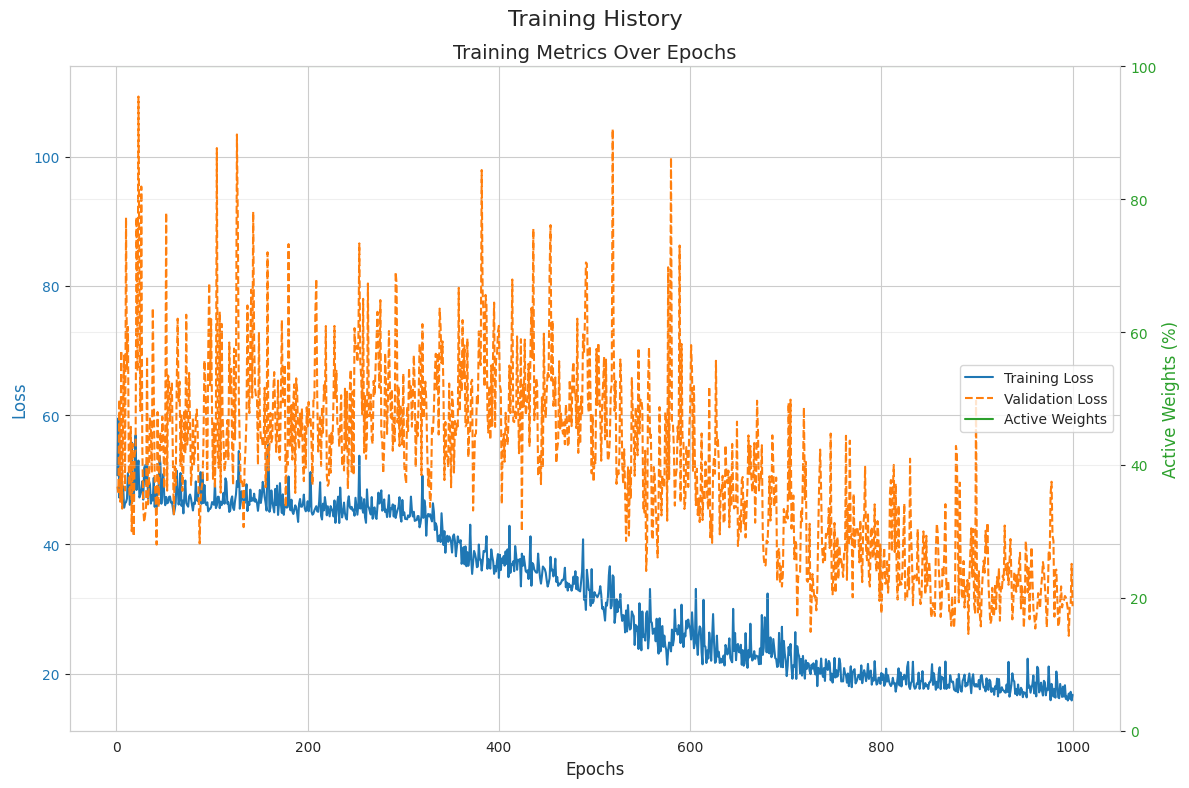

In [ ]:
plot_training_history(model)

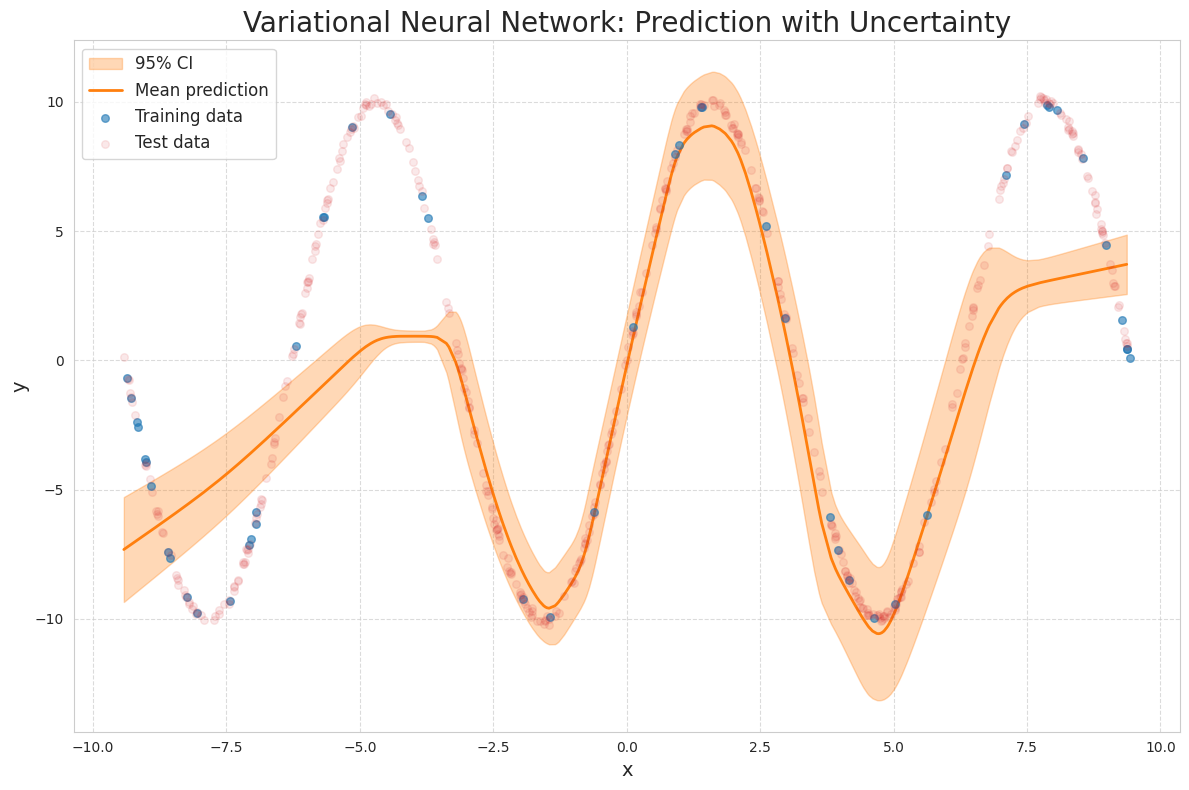

In [ ]:
# Plot the results
x_test, y_test = generate_data(n_samples=500, noise_std=0.1, x_min=-3*np.pi, x_max=3*np.pi,
                               function=np.sin, amplitude=10., distribution='uniform')


plot_uncertainty_prediction(model, x_test, y_test, x_sine, y_sine, n_samples = 10000)

In [ ]:
# Initialize model
input_shape = (1,)
hidden_sizes = [128, 32]
output_size = 1

model_masked = VariationalNet(input_shape, hidden_sizes, output_size)

# Define optimizer
optimizer = torch.optim.Adam(model_masked.parameters(), lr=0.01)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_masked.to(device)

num_epochs = 1000
train_and_validate(model_masked, optimizer, train_loader, val_loader, num_epochs, device, update_weight_mask = True)

Epoch 1/1000
Active parameters: 4417/8834 (100.00%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 66.46it/s, loss=55.5176, mse=48.7291, kl_div=6.7885]


Train Loss: 48.0543, Train MSE: 41.2268
Val Loss: 55.5176, Val MSE: 48.7291
Epoch 2/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.35it/s, loss=47.8442, mse=41.0782, kl_div=6.7660]


Epoch 3/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 111.15it/s, loss=65.3209, mse=58.5696, kl_div=6.7514]


Epoch 4/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.82it/s, loss=58.9370, mse=52.1980, kl_div=6.7390]


Epoch 5/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.76it/s, loss=56.9156, mse=50.1888, kl_div=6.7268]


Epoch 6/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.12it/s, loss=59.8952, mse=53.1797, kl_div=6.7155]


Epoch 7/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.02it/s, loss=79.4241, mse=72.7182, kl_div=6.7059]


Epoch 8/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 33.24it/s, loss=60.2218, mse=53.5238, kl_div=6.6980]


Epoch 9/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.92it/s, loss=55.8525, mse=49.1611, kl_div=6.6914]


Epoch 10/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.89it/s, loss=46.6030, mse=39.9179, kl_div=6.6851]


Epoch 11/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 63.81it/s, loss=49.6582, mse=42.9792, kl_div=6.6790]


Epoch 12/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.92it/s, loss=48.5140, mse=41.8411, kl_div=6.6729]


Epoch 13/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.24it/s, loss=58.8288, mse=52.1619, kl_div=6.6668]


Epoch 14/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.82it/s, loss=51.3490, mse=44.6881, kl_div=6.6609]


Epoch 15/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.27it/s, loss=59.1812, mse=52.5260, kl_div=6.6552]


Epoch 16/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 81.77it/s, loss=58.4983, mse=51.8489, kl_div=6.6494]


Epoch 17/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.21it/s, loss=60.9971, mse=54.3533, kl_div=6.6438]


Epoch 18/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 139.65it/s, loss=64.9471, mse=58.3087, kl_div=6.6384]


Epoch 19/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.03it/s, loss=58.8437, mse=52.2108, kl_div=6.6330]


Epoch 20/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.13it/s, loss=57.3544, mse=50.7267, kl_div=6.6277]


Epoch 21/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 167.80it/s, loss=59.1529, mse=52.5299, kl_div=6.6229]


Epoch 22/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 139.03it/s, loss=54.9202, mse=48.3017, kl_div=6.6185]


Epoch 23/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 50.31it/s, loss=99.1328, mse=92.5183, kl_div=6.6146]


Epoch 24/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.48it/s, loss=49.3588, mse=42.7482, kl_div=6.6107]


Epoch 25/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.47it/s, loss=96.7340, mse=90.1277, kl_div=6.6064]


Epoch 26/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.04it/s, loss=53.3776, mse=46.7757, kl_div=6.6019]


Epoch 27/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.14it/s, loss=60.7180, mse=54.1205, kl_div=6.5975]


Epoch 28/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.92it/s, loss=62.9439, mse=56.3509, kl_div=6.5930]


Epoch 29/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.29it/s, loss=57.7557, mse=51.1673, kl_div=6.5884]


Epoch 30/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.14it/s, loss=55.8833, mse=49.2995, kl_div=6.5838]


Epoch 31/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.61it/s, loss=66.7189, mse=60.1396, kl_div=6.5793]


Epoch 32/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 68.70it/s, loss=58.8569, mse=52.2822, kl_div=6.5748]


Epoch 33/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.78it/s, loss=61.9410, mse=55.3706, kl_div=6.5704]


Epoch 34/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.92it/s, loss=72.1548, mse=65.5887, kl_div=6.5660]


Epoch 35/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 183.08it/s, loss=60.9849, mse=54.4232, kl_div=6.5617]


Epoch 36/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 134.37it/s, loss=55.9159, mse=49.3585, kl_div=6.5575]


Epoch 37/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.72it/s, loss=64.1929, mse=57.6393, kl_div=6.5536]


Epoch 38/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.45it/s, loss=74.2383, mse=67.6884, kl_div=6.5499]


Epoch 39/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.50it/s, loss=54.8894, mse=48.3431, kl_div=6.5463]


Epoch 40/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.51it/s, loss=69.7702, mse=63.2278, kl_div=6.5424]


Epoch 41/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.99it/s, loss=47.2556, mse=40.7169, kl_div=6.5387]


Epoch 42/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 59.25it/s, loss=60.8113, mse=54.2764, kl_div=6.5349]


Epoch 43/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 29.41it/s, loss=50.5266, mse=43.9953, kl_div=6.5313]


Epoch 44/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 191.62it/s, loss=57.6357, mse=51.1075, kl_div=6.5282]


Epoch 45/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 68.60it/s, loss=52.8316, mse=46.3063, kl_div=6.5252]


Epoch 46/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.80it/s, loss=53.5738, mse=47.0517, kl_div=6.5221]


Epoch 47/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.28it/s, loss=57.7634, mse=51.2444, kl_div=6.5189]


Epoch 48/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.59it/s, loss=49.6837, mse=43.1678, kl_div=6.5159]


Epoch 49/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.30it/s, loss=53.3102, mse=46.7973, kl_div=6.5129]


Epoch 50/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.82it/s, loss=49.2906, mse=42.7806, kl_div=6.5100]


Epoch 51/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.48it/s, loss=53.9426, mse=47.4357, kl_div=6.5070]


Epoch 52/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.83it/s, loss=46.0089, mse=39.5049, kl_div=6.5041]


Epoch 53/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.47it/s, loss=50.3147, mse=43.8134, kl_div=6.5014]


Epoch 54/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 64.23it/s, loss=52.1185, mse=45.6201, kl_div=6.4984]


Epoch 55/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.46it/s, loss=56.0812, mse=49.5859, kl_div=6.4953]


Epoch 56/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.32it/s, loss=60.9326, mse=54.4404, kl_div=6.4922]


Epoch 57/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.25it/s, loss=54.8673, mse=48.3783, kl_div=6.4889]


Epoch 58/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 32.83it/s, loss=79.7396, mse=73.2541, kl_div=6.4856]


Epoch 59/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.10it/s, loss=50.4669, mse=43.9847, kl_div=6.4822]


Epoch 60/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.70it/s, loss=53.8620, mse=47.3834, kl_div=6.4786]


Epoch 61/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 77.95it/s, loss=59.4719, mse=52.9969, kl_div=6.4750]


Epoch 62/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 107.19it/s, loss=66.0177, mse=59.5463, kl_div=6.4714]


Epoch 63/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.08it/s, loss=52.4483, mse=45.9805, kl_div=6.4677]


Epoch 64/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 67.60it/s, loss=51.8737, mse=45.4096, kl_div=6.4640]


Epoch 65/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.00it/s, loss=75.2970, mse=68.8367, kl_div=6.4603]


Epoch 66/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.74it/s, loss=46.2020, mse=39.7454, kl_div=6.4567]


Epoch 67/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 58.16it/s, loss=72.1899, mse=65.7370, kl_div=6.4529]


Epoch 68/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.11it/s, loss=59.0311, mse=52.5820, kl_div=6.4491]


Epoch 69/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.74it/s, loss=48.7500, mse=42.3046, kl_div=6.4454]


Epoch 70/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 61.14it/s, loss=54.2091, mse=47.7673, kl_div=6.4418]


Epoch 71/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.64it/s, loss=47.9668, mse=41.5287, kl_div=6.4381]


Epoch 72/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 86.01it/s, loss=56.0130, mse=49.5786, kl_div=6.4344]


Epoch 73/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.93it/s, loss=60.3477, mse=53.9167, kl_div=6.4310]


Epoch 74/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 72.44it/s, loss=55.5384, mse=49.1108, kl_div=6.4276]


Epoch 75/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 31.18it/s, loss=60.8938, mse=54.4697, kl_div=6.4241]


Epoch 76/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.20it/s, loss=47.9470, mse=41.5263, kl_div=6.4207]


Epoch 77/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.26it/s, loss=51.9158, mse=45.4986, kl_div=6.4172]


Epoch 78/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 68.86it/s, loss=48.7473, mse=42.3336, kl_div=6.4136]


Epoch 79/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.56it/s, loss=54.2988, mse=47.8888, kl_div=6.4100]


Epoch 80/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 65.68it/s, loss=52.3391, mse=45.9330, kl_div=6.4061]


Epoch 81/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.33it/s, loss=54.7706, mse=48.3684, kl_div=6.4022]


Epoch 82/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.07it/s, loss=70.1610, mse=63.7626, kl_div=6.3985]


Epoch 83/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.31it/s, loss=64.0225, mse=57.6276, kl_div=6.3949]


Epoch 84/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 201.29it/s, loss=54.1234, mse=47.7319, kl_div=6.3915]


Epoch 85/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.25it/s, loss=49.0069, mse=42.6187, kl_div=6.3882]


Epoch 86/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.46it/s, loss=47.2633, mse=40.8783, kl_div=6.3850]


Epoch 87/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.76it/s, loss=68.2188, mse=61.8372, kl_div=6.3816]


Epoch 88/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 114.58it/s, loss=48.6198, mse=42.2414, kl_div=6.3784]


Epoch 89/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.85it/s, loss=55.9744, mse=49.5993, kl_div=6.3751]


Epoch 90/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.55it/s, loss=54.9954, mse=48.6236, kl_div=6.3718]


Epoch 91/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.19it/s, loss=77.3660, mse=70.9972, kl_div=6.3687]


Epoch 92/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.69it/s, loss=60.0193, mse=53.6537, kl_div=6.3656]


Epoch 93/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.29it/s, loss=51.6022, mse=45.2400, kl_div=6.3622]


Epoch 94/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.94it/s, loss=76.9852, mse=70.6264, kl_div=6.3588]


Epoch 95/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 67.63it/s, loss=58.7612, mse=52.4059, kl_div=6.3554]


Epoch 96/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.94it/s, loss=56.2537, mse=49.9014, kl_div=6.3523]


Epoch 97/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 170.00it/s, loss=53.2166, mse=46.8672, kl_div=6.3494]


Epoch 98/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.94it/s, loss=59.7209, mse=53.3746, kl_div=6.3463]


Epoch 99/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.41it/s, loss=93.3694, mse=87.0263, kl_div=6.3431]


Epoch 100/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 185.99it/s, loss=54.6519, mse=48.3123, kl_div=6.3397]


Epoch 101/1000
Active parameters: 1580.0/8834 (35.77%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 170.22it/s, loss=60.5463, mse=54.2100, kl_div=6.3363]


Train Loss: 38.9058, Train MSE: 32.5664
Val Loss: 60.5463, Val MSE: 54.2100
Epoch 102/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 178.91it/s, loss=55.6398, mse=49.3071, kl_div=6.3327]


Epoch 103/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 205.90it/s, loss=63.8131, mse=57.4840, kl_div=6.3291]


Epoch 104/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 173.82it/s, loss=67.7496, mse=61.4239, kl_div=6.3257]


Epoch 105/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.46it/s, loss=56.3179, mse=49.9956, kl_div=6.3223]


Epoch 106/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.51it/s, loss=52.2206, mse=45.9016, kl_div=6.3190]


Epoch 107/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.72it/s, loss=55.3353, mse=49.0196, kl_div=6.3157]


Epoch 108/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 62.39it/s, loss=53.5678, mse=47.2556, kl_div=6.3123]


Epoch 109/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.53it/s, loss=49.7755, mse=43.4666, kl_div=6.3089]


Epoch 110/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 147.90it/s, loss=54.9590, mse=48.6537, kl_div=6.3053]


Epoch 111/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 200.91it/s, loss=48.8918, mse=42.5902, kl_div=6.3017]


Epoch 112/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 168.47it/s, loss=57.9745, mse=51.6765, kl_div=6.2980]


Epoch 113/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 198.65it/s, loss=49.8349, mse=43.5406, kl_div=6.2942]


Epoch 114/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 210.46it/s, loss=49.8341, mse=43.5436, kl_div=6.2906]


Epoch 115/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 186.42it/s, loss=67.8876, mse=61.6009, kl_div=6.2868]


Epoch 116/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 154.55it/s, loss=65.4041, mse=59.1213, kl_div=6.2828]


Epoch 117/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 175.19it/s, loss=59.4872, mse=53.2084, kl_div=6.2788]


Epoch 118/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 174.00it/s, loss=64.6518, mse=58.3770, kl_div=6.2748]


Epoch 119/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.18it/s, loss=53.6986, mse=47.4277, kl_div=6.2709]


Epoch 120/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 201.79it/s, loss=62.2071, mse=55.9401, kl_div=6.2671]


Epoch 121/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 181.61it/s, loss=48.6341, mse=42.3708, kl_div=6.2633]


Epoch 122/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 179.53it/s, loss=54.9999, mse=48.7403, kl_div=6.2596]


Epoch 123/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 182.46it/s, loss=50.3236, mse=44.0676, kl_div=6.2560]


Epoch 124/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.79it/s, loss=50.1544, mse=43.9021, kl_div=6.2523]


Epoch 125/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.63it/s, loss=47.5458, mse=41.2972, kl_div=6.2486]


Epoch 126/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.42it/s, loss=51.2972, mse=45.0521, kl_div=6.2450]


Epoch 127/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.00it/s, loss=48.3936, mse=42.1521, kl_div=6.2416]


Epoch 128/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.57it/s, loss=49.4970, mse=43.2584, kl_div=6.2386]


Epoch 129/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.89it/s, loss=49.2327, mse=42.9972, kl_div=6.2355]


Epoch 130/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.45it/s, loss=55.0914, mse=48.8590, kl_div=6.2323]


Epoch 131/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 67.74it/s, loss=63.0168, mse=56.7878, kl_div=6.2290]


Epoch 132/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.65it/s, loss=59.5605, mse=53.3349, kl_div=6.2256]


Epoch 133/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 69.13it/s, loss=55.0520, mse=48.8298, kl_div=6.2222]


Epoch 134/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.32it/s, loss=61.4167, mse=55.1981, kl_div=6.2186]


Epoch 135/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.38it/s, loss=55.3896, mse=49.1747, kl_div=6.2149]


Epoch 136/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.74it/s, loss=56.7506, mse=50.5394, kl_div=6.2112]


Epoch 137/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 74.70it/s, loss=59.6751, mse=53.4678, kl_div=6.2074]


Epoch 138/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 117.65it/s, loss=54.6713, mse=48.4679, kl_div=6.2034]


Epoch 139/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 82.04it/s, loss=51.1949, mse=44.9955, kl_div=6.1994]


Epoch 140/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.28it/s, loss=63.3293, mse=57.1341, kl_div=6.1952]


Epoch 141/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.67it/s, loss=47.1826, mse=40.9914, kl_div=6.1911]


Epoch 142/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.64it/s, loss=57.5876, mse=51.4006, kl_div=6.1870]


Epoch 143/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.31it/s, loss=51.6213, mse=45.4382, kl_div=6.1831]


Epoch 144/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 187.20it/s, loss=47.5766, mse=41.3973, kl_div=6.1793]


Epoch 145/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.00it/s, loss=54.1139, mse=47.9385, kl_div=6.1754]


Epoch 146/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.09it/s, loss=70.0145, mse=63.8431, kl_div=6.1714]


Epoch 147/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.15it/s, loss=60.8217, mse=54.6541, kl_div=6.1675]


Epoch 148/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 86.59it/s, loss=53.3244, mse=47.1607, kl_div=6.1636]


Epoch 149/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 130.53it/s, loss=66.4393, mse=60.2797, kl_div=6.1596]


Epoch 150/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.58it/s, loss=77.5297, mse=71.3740, kl_div=6.1556]


Epoch 151/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.23it/s, loss=84.1985, mse=78.0466, kl_div=6.1519]


Epoch 152/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 189.70it/s, loss=55.9248, mse=49.7765, kl_div=6.1483]


Epoch 153/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 130.34it/s, loss=56.2608, mse=50.1159, kl_div=6.1448]


Epoch 154/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 178.88it/s, loss=52.1348, mse=45.9935, kl_div=6.1413]


Epoch 155/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.13it/s, loss=51.7749, mse=45.6373, kl_div=6.1377]


Epoch 156/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.98it/s, loss=50.3287, mse=44.1947, kl_div=6.1340]


Epoch 157/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.22it/s, loss=51.3935, mse=45.2632, kl_div=6.1302]


Epoch 158/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.88it/s, loss=49.9948, mse=43.8683, kl_div=6.1264]


Epoch 159/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 63.77it/s, loss=51.9132, mse=45.7906, kl_div=6.1226]


Epoch 160/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 69.77it/s, loss=53.0233, mse=46.9044, kl_div=6.1190]


Epoch 161/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.15it/s, loss=59.0270, mse=52.9116, kl_div=6.1153]


Epoch 162/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.06it/s, loss=56.6466, mse=50.5350, kl_div=6.1116]


Epoch 163/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.49it/s, loss=60.9105, mse=54.8027, kl_div=6.1078]


Epoch 164/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.23it/s, loss=59.3714, mse=53.2674, kl_div=6.1040]


Epoch 165/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.11it/s, loss=54.4694, mse=48.3692, kl_div=6.1002]


Epoch 166/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 81.10it/s, loss=60.0560, mse=53.9594, kl_div=6.0967]


Epoch 167/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.09it/s, loss=52.0401, mse=45.9470, kl_div=6.0931]


Epoch 168/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.76it/s, loss=61.9936, mse=55.9042, kl_div=6.0893]


Epoch 169/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.91it/s, loss=56.1193, mse=50.0337, kl_div=6.0855]


Epoch 170/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 81.84it/s, loss=59.9089, mse=53.8272, kl_div=6.0817]


Epoch 171/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 76.97it/s, loss=60.5827, mse=54.5049, kl_div=6.0778]


Epoch 172/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 69.60it/s, loss=51.7910, mse=45.7172, kl_div=6.0737]


Epoch 173/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.95it/s, loss=56.2326, mse=50.1630, kl_div=6.0697]


Epoch 174/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.29it/s, loss=53.3711, mse=47.3055, kl_div=6.0656]


Epoch 175/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.01it/s, loss=53.3903, mse=47.3286, kl_div=6.0617]


Epoch 176/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 170.02it/s, loss=59.9740, mse=53.9162, kl_div=6.0578]


Epoch 177/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.42it/s, loss=58.6530, mse=52.5991, kl_div=6.0539]


Epoch 178/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.79it/s, loss=61.1921, mse=55.1420, kl_div=6.0501]


Epoch 179/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.06it/s, loss=56.1913, mse=50.1451, kl_div=6.0463]


Epoch 180/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.44it/s, loss=62.8347, mse=56.7923, kl_div=6.0424]


Epoch 181/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.07it/s, loss=60.7050, mse=54.6666, kl_div=6.0384]


Epoch 182/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 76.96it/s, loss=58.6102, mse=52.5758, kl_div=6.0345]


Epoch 183/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.75it/s, loss=63.2651, mse=57.2343, kl_div=6.0308]


Epoch 184/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.83it/s, loss=61.1774, mse=55.1500, kl_div=6.0274]


Epoch 185/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.84it/s, loss=50.7903, mse=44.7660, kl_div=6.0242]


Epoch 186/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.04it/s, loss=61.4100, mse=55.3889, kl_div=6.0211]


Epoch 187/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 170.90it/s, loss=72.4366, mse=66.4186, kl_div=6.0180]


Epoch 188/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.37it/s, loss=76.3846, mse=70.3699, kl_div=6.0147]


Epoch 189/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.20it/s, loss=58.4643, mse=52.4532, kl_div=6.0110]


Epoch 190/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 190.38it/s, loss=57.6266, mse=51.6194, kl_div=6.0072]


Epoch 191/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 159.45it/s, loss=57.0157, mse=51.0124, kl_div=6.0033]


Epoch 192/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.45it/s, loss=71.6591, mse=65.6597, kl_div=5.9994]


Epoch 193/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.52it/s, loss=49.0640, mse=43.0686, kl_div=5.9953]


Epoch 194/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 68.04it/s, loss=61.3065, mse=55.3152, kl_div=5.9913]


Epoch 195/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 138.09it/s, loss=56.1100, mse=50.1227, kl_div=5.9872]


Epoch 196/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.56it/s, loss=49.0547, mse=43.0715, kl_div=5.9832]


Epoch 197/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.56it/s, loss=51.5741, mse=45.5951, kl_div=5.9790]


Epoch 198/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.51it/s, loss=82.0290, mse=76.0541, kl_div=5.9749]


Epoch 199/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.08it/s, loss=68.7157, mse=62.7449, kl_div=5.9708]


Epoch 200/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 172.11it/s, loss=50.0578, mse=44.0909, kl_div=5.9669]


Epoch 201/1000
Active parameters: 1562.0/8834 (35.36%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.09it/s, loss=57.9659, mse=52.0030, kl_div=5.9629]


Train Loss: 36.9975, Train MSE: 31.0310
Val Loss: 57.9659, Val MSE: 52.0030
Epoch 202/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 171.60it/s, loss=60.1319, mse=54.1731, kl_div=5.9589]


Epoch 203/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.57it/s, loss=57.0518, mse=51.0969, kl_div=5.9549]


Epoch 204/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.51it/s, loss=49.6668, mse=43.7159, kl_div=5.9509]


Epoch 205/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 174.47it/s, loss=68.1530, mse=62.2061, kl_div=5.9469]


Epoch 206/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 129.95it/s, loss=63.0013, mse=57.0584, kl_div=5.9429]


Epoch 207/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.79it/s, loss=50.7118, mse=44.7730, kl_div=5.9389]


Epoch 208/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 181.37it/s, loss=59.2068, mse=53.2721, kl_div=5.9347]


Epoch 209/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 212.47it/s, loss=51.4707, mse=45.5400, kl_div=5.9307]


Epoch 210/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.42it/s, loss=46.7739, mse=40.8473, kl_div=5.9266]


Epoch 211/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 184.78it/s, loss=51.2223, mse=45.2999, kl_div=5.9224]


Epoch 212/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 186.02it/s, loss=50.7152, mse=44.7969, kl_div=5.9183]


Epoch 213/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 186.76it/s, loss=51.3197, mse=45.4054, kl_div=5.9143]


Epoch 214/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 134.90it/s, loss=63.0763, mse=57.1661, kl_div=5.9101]


Epoch 215/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 179.86it/s, loss=48.7544, mse=42.8484, kl_div=5.9059]


Epoch 216/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.85it/s, loss=63.6142, mse=57.7125, kl_div=5.9017]


Epoch 217/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.78it/s, loss=60.9851, mse=55.0878, kl_div=5.8973]


Epoch 218/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 201.28it/s, loss=55.0211, mse=49.1281, kl_div=5.8930]


Epoch 219/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 179.20it/s, loss=48.4043, mse=42.5154, kl_div=5.8889]


Epoch 220/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 136.56it/s, loss=60.1672, mse=54.2825, kl_div=5.8847]


Epoch 221/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 135.03it/s, loss=51.1212, mse=45.2407, kl_div=5.8805]


Epoch 222/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.20it/s, loss=50.9176, mse=45.0407, kl_div=5.8768]


Epoch 223/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.35it/s, loss=49.8551, mse=43.9818, kl_div=5.8732]


Epoch 224/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.53it/s, loss=50.6918, mse=44.8220, kl_div=5.8699]


Epoch 225/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.55it/s, loss=51.7487, mse=45.8820, kl_div=5.8667]


Epoch 226/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.22it/s, loss=51.6197, mse=45.7560, kl_div=5.8637]


Epoch 227/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 169.33it/s, loss=56.2101, mse=50.3497, kl_div=5.8604]


Epoch 228/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.36it/s, loss=66.5730, mse=60.7163, kl_div=5.8567]


Epoch 229/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 180.69it/s, loss=54.3511, mse=48.4982, kl_div=5.8529]


Epoch 230/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.58it/s, loss=56.8208, mse=50.9718, kl_div=5.8490]


Epoch 231/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.81it/s, loss=51.0336, mse=45.1886, kl_div=5.8451]


Epoch 232/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 197.76it/s, loss=53.4086, mse=47.5675, kl_div=5.8411]


Epoch 233/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.30it/s, loss=57.4144, mse=51.5774, kl_div=5.8370]


Epoch 234/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.11it/s, loss=63.1321, mse=57.2992, kl_div=5.8330]


Epoch 235/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 168.25it/s, loss=60.4672, mse=54.6383, kl_div=5.8289]


Epoch 236/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.40it/s, loss=54.2094, mse=48.3844, kl_div=5.8250]


Epoch 237/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 195.38it/s, loss=53.1794, mse=47.3584, kl_div=5.8210]


Epoch 238/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 211.87it/s, loss=57.6826, mse=51.8655, kl_div=5.8170]


Epoch 239/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.90it/s, loss=49.8420, mse=44.0290, kl_div=5.8130]


Epoch 240/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 69.41it/s, loss=58.4064, mse=52.5972, kl_div=5.8092]


Epoch 241/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.80it/s, loss=55.4048, mse=49.5995, kl_div=5.8053]


Epoch 242/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.25it/s, loss=60.0283, mse=54.2271, kl_div=5.8012]


Epoch 243/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.63it/s, loss=53.8612, mse=48.0642, kl_div=5.7970]


Epoch 244/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.88it/s, loss=61.5994, mse=55.8066, kl_div=5.7928]


Epoch 245/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 175.16it/s, loss=57.3837, mse=51.5950, kl_div=5.7887]


Epoch 246/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 111.73it/s, loss=58.5206, mse=52.7361, kl_div=5.7845]


Epoch 247/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 65.97it/s, loss=63.1264, mse=57.3461, kl_div=5.7803]


Epoch 248/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.51it/s, loss=57.8159, mse=52.0398, kl_div=5.7761]


Epoch 249/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.72it/s, loss=60.4341, mse=54.6621, kl_div=5.7720]


Epoch 250/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.18it/s, loss=55.6543, mse=49.8865, kl_div=5.7678]


Epoch 251/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.34it/s, loss=53.0850, mse=47.3213, kl_div=5.7637]


Epoch 252/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.13it/s, loss=59.6114, mse=53.8518, kl_div=5.7596]


Epoch 253/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.49it/s, loss=59.0354, mse=53.2799, kl_div=5.7555]


Epoch 254/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.35it/s, loss=70.8310, mse=65.0794, kl_div=5.7516]


Epoch 255/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.96it/s, loss=48.5251, mse=42.7776, kl_div=5.7475]


Epoch 256/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.77it/s, loss=50.4738, mse=44.7305, kl_div=5.7433]


Epoch 257/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.11it/s, loss=52.6320, mse=46.8929, kl_div=5.7391]


Epoch 258/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 130.00it/s, loss=53.0883, mse=47.3533, kl_div=5.7350]


Epoch 259/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 134.63it/s, loss=56.4706, mse=50.7396, kl_div=5.7310]


Epoch 260/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.62it/s, loss=50.4626, mse=44.7357, kl_div=5.7269]


Epoch 261/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.14it/s, loss=49.8901, mse=44.1673, kl_div=5.7228]


Epoch 262/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 72.55it/s, loss=52.0207, mse=46.3018, kl_div=5.7189]


Epoch 263/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.72it/s, loss=54.8591, mse=49.1440, kl_div=5.7151]


Epoch 264/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.30it/s, loss=51.9061, mse=46.1949, kl_div=5.7113]


Epoch 265/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 175.24it/s, loss=64.6711, mse=58.9639, kl_div=5.7071]


Epoch 266/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.87it/s, loss=69.6558, mse=63.9529, kl_div=5.7029]


Epoch 267/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.86it/s, loss=62.8366, mse=57.1379, kl_div=5.6987]


Epoch 268/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 169.28it/s, loss=61.9745, mse=56.2801, kl_div=5.6944]


Epoch 269/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.33it/s, loss=67.1615, mse=61.4714, kl_div=5.6901]


Epoch 270/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.96it/s, loss=58.4025, mse=52.7168, kl_div=5.6857]


Epoch 271/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 132.74it/s, loss=54.8474, mse=49.1661, kl_div=5.6813]


Epoch 272/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.08it/s, loss=57.0116, mse=51.3348, kl_div=5.6768]


Epoch 273/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.76it/s, loss=62.1019, mse=56.4297, kl_div=5.6722]


Epoch 274/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.54it/s, loss=57.1261, mse=51.4584, kl_div=5.6677]


Epoch 275/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 167.12it/s, loss=51.7734, mse=46.1101, kl_div=5.6633]


Epoch 276/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 141.14it/s, loss=48.7380, mse=43.0791, kl_div=5.6589]


Epoch 277/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.18it/s, loss=50.8204, mse=45.1656, kl_div=5.6547]


Epoch 278/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 178.88it/s, loss=50.5630, mse=44.9124, kl_div=5.6506]


Epoch 279/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.32it/s, loss=49.2528, mse=43.6063, kl_div=5.6466]


Epoch 280/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 191.89it/s, loss=52.2849, mse=46.6423, kl_div=5.6426]


Epoch 281/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 195.19it/s, loss=53.0195, mse=47.3809, kl_div=5.6386]


Epoch 282/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 178.66it/s, loss=49.9890, mse=44.3545, kl_div=5.6345]


Epoch 283/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 188.47it/s, loss=47.3937, mse=41.7633, kl_div=5.6305]


Epoch 284/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 188.04it/s, loss=53.5972, mse=47.9707, kl_div=5.6264]


Epoch 285/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 187.22it/s, loss=54.5811, mse=48.9589, kl_div=5.6222]


Epoch 286/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 184.44it/s, loss=55.0121, mse=49.3943, kl_div=5.6178]


Epoch 287/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 189.60it/s, loss=56.6384, mse=51.0251, kl_div=5.6133]


Epoch 288/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 117.65it/s, loss=53.3275, mse=47.7186, kl_div=5.6089]


Epoch 289/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 189.68it/s, loss=53.9879, mse=48.3836, kl_div=5.6043]


Epoch 290/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 182.86it/s, loss=57.3931, mse=51.7934, kl_div=5.5997]


Epoch 291/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 187.91it/s, loss=58.6353, mse=53.0402, kl_div=5.5951]


Epoch 292/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.76it/s, loss=52.7187, mse=47.1282, kl_div=5.5905]


Epoch 293/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.43it/s, loss=62.3642, mse=56.7780, kl_div=5.5862]


Epoch 294/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 144.07it/s, loss=50.3681, mse=44.7864, kl_div=5.5817]


Epoch 295/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.46it/s, loss=55.9836, mse=50.4064, kl_div=5.5772]


Epoch 296/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 71.15it/s, loss=52.0065, mse=46.4339, kl_div=5.5726]


Epoch 297/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.43it/s, loss=51.2545, mse=45.6865, kl_div=5.5680]


Epoch 298/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.13it/s, loss=61.3833, mse=55.8197, kl_div=5.5636]


Epoch 299/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.72it/s, loss=57.7863, mse=52.2272, kl_div=5.5591]


Epoch 300/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.03it/s, loss=56.8496, mse=51.2950, kl_div=5.5546]


Epoch 301/1000
Active parameters: 1428.0/8834 (32.33%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.77it/s, loss=62.4458, mse=56.8956, kl_div=5.5501]


Train Loss: 35.6049, Train MSE: 30.0508
Val Loss: 62.4458, Val MSE: 56.8956
Epoch 302/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.93it/s, loss=56.6357, mse=51.0899, kl_div=5.5458]


Epoch 303/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.88it/s, loss=56.5529, mse=51.0113, kl_div=5.5417]


Epoch 304/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.75it/s, loss=59.5383, mse=54.0007, kl_div=5.5376]


Epoch 305/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 86.10it/s, loss=55.7306, mse=50.1971, kl_div=5.5335]


Epoch 306/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.27it/s, loss=64.9070, mse=59.3776, kl_div=5.5295]


Epoch 307/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 86.06it/s, loss=60.7748, mse=55.2496, kl_div=5.5252]


Epoch 308/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.08it/s, loss=59.1928, mse=53.6719, kl_div=5.5210]


Epoch 309/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.66it/s, loss=60.6831, mse=55.1664, kl_div=5.5167]


Epoch 310/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.17it/s, loss=63.0414, mse=57.5290, kl_div=5.5124]


Epoch 311/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.10it/s, loss=63.0240, mse=57.5157, kl_div=5.5083]


Epoch 312/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.04it/s, loss=49.0568, mse=43.5527, kl_div=5.5041]


Epoch 313/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.05it/s, loss=65.0436, mse=59.5439, kl_div=5.4997]


Epoch 314/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 158.78it/s, loss=53.2879, mse=47.7927, kl_div=5.4953]


Epoch 315/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.97it/s, loss=53.1135, mse=47.6226, kl_div=5.4909]


Epoch 316/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.28it/s, loss=67.6699, mse=62.1835, kl_div=5.4864]


Epoch 317/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.60it/s, loss=81.5838, mse=76.1018, kl_div=5.4820]


Epoch 318/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.34it/s, loss=57.8348, mse=52.3571, kl_div=5.4777]


Epoch 319/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.40it/s, loss=71.0707, mse=65.5973, kl_div=5.4734]


Epoch 320/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.34it/s, loss=56.9167, mse=51.4477, kl_div=5.4691]


Epoch 321/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.42it/s, loss=65.2915, mse=59.8268, kl_div=5.4647]


Epoch 322/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 62.74it/s, loss=52.5888, mse=47.1285, kl_div=5.4603]


Epoch 323/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.13it/s, loss=50.3942, mse=44.9382, kl_div=5.4559]


Epoch 324/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 134.89it/s, loss=54.4351, mse=48.9835, kl_div=5.4516]


Epoch 325/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 154.34it/s, loss=53.3485, mse=47.9013, kl_div=5.4472]


Epoch 326/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.55it/s, loss=53.3535, mse=47.9107, kl_div=5.4428]


Epoch 327/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.06it/s, loss=50.1210, mse=44.6824, kl_div=5.4386]


Epoch 328/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.05it/s, loss=48.9077, mse=43.4733, kl_div=5.4344]


Epoch 329/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 173.93it/s, loss=52.7997, mse=47.3694, kl_div=5.4303]


Epoch 330/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.88it/s, loss=52.4085, mse=46.9824, kl_div=5.4261]


Epoch 331/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 165.08it/s, loss=54.1714, mse=48.7495, kl_div=5.4219]


Epoch 332/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.41it/s, loss=64.0012, mse=58.5835, kl_div=5.4177]


Epoch 333/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.74it/s, loss=56.1518, mse=50.7385, kl_div=5.4133]


Epoch 334/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.63it/s, loss=51.3189, mse=45.9101, kl_div=5.4088]


Epoch 335/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.07it/s, loss=56.7729, mse=51.3685, kl_div=5.4044]


Epoch 336/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.56it/s, loss=54.0495, mse=48.6495, kl_div=5.4000]


Epoch 337/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.33it/s, loss=60.5033, mse=55.1075, kl_div=5.3958]


Epoch 338/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 162.83it/s, loss=54.8692, mse=49.4775, kl_div=5.3917]


Epoch 339/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 122.89it/s, loss=52.2110, mse=46.8230, kl_div=5.3880]


Epoch 340/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.70it/s, loss=58.3967, mse=53.0122, kl_div=5.3845]


Epoch 341/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 71.88it/s, loss=64.3754, mse=58.9944, kl_div=5.3810]


Epoch 342/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 81.23it/s, loss=51.3447, mse=45.9673, kl_div=5.3775]


Epoch 343/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.20it/s, loss=52.8277, mse=47.4541, kl_div=5.3736]


Epoch 344/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.56it/s, loss=51.6204, mse=46.2507, kl_div=5.3697]


Epoch 345/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.24it/s, loss=56.0588, mse=50.6931, kl_div=5.3657]


Epoch 346/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 146.90it/s, loss=47.2842, mse=41.9226, kl_div=5.3616]


Epoch 347/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.91it/s, loss=49.8688, mse=44.5111, kl_div=5.3577]


Epoch 348/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.77it/s, loss=52.0623, mse=46.7085, kl_div=5.3538]


Epoch 349/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.67it/s, loss=53.0434, mse=47.6934, kl_div=5.3500]


Epoch 350/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 176.93it/s, loss=49.5342, mse=44.1880, kl_div=5.3462]


Epoch 351/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 147.26it/s, loss=50.2801, mse=44.9377, kl_div=5.3423]


Epoch 352/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.85it/s, loss=52.2856, mse=46.9471, kl_div=5.3385]


Epoch 353/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.82it/s, loss=58.2253, mse=52.8905, kl_div=5.3348]


Epoch 354/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.62it/s, loss=51.5819, mse=46.2508, kl_div=5.3311]


Epoch 355/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.07it/s, loss=52.2600, mse=46.9327, kl_div=5.3273]


Epoch 356/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.77it/s, loss=49.5969, mse=44.2732, kl_div=5.3237]


Epoch 357/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.33it/s, loss=63.6814, mse=58.3614, kl_div=5.3200]


Epoch 358/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 185.59it/s, loss=54.2750, mse=48.9585, kl_div=5.3165]


Epoch 359/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.75it/s, loss=55.2573, mse=49.9441, kl_div=5.3131]


Epoch 360/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 160.30it/s, loss=57.4144, mse=52.1048, kl_div=5.3096]


Epoch 361/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 195.27it/s, loss=58.2865, mse=52.9806, kl_div=5.3059]


Epoch 362/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 182.47it/s, loss=54.8926, mse=49.5907, kl_div=5.3019]


Epoch 363/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 150.13it/s, loss=56.4107, mse=51.1128, kl_div=5.2980]


Epoch 364/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 175.16it/s, loss=59.1375, mse=53.8436, kl_div=5.2940]


Epoch 365/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 179.31it/s, loss=53.5883, mse=48.2984, kl_div=5.2899]


Epoch 366/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 206.57it/s, loss=53.8276, mse=48.5417, kl_div=5.2859]


Epoch 367/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 174.36it/s, loss=62.0650, mse=56.7831, kl_div=5.2819]


Epoch 368/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 160.66it/s, loss=55.4684, mse=50.1907, kl_div=5.2777]


Epoch 369/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 203.46it/s, loss=49.5333, mse=44.2598, kl_div=5.2735]


Epoch 370/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 208.53it/s, loss=48.9973, mse=43.7279, kl_div=5.2693]


Epoch 371/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 150.94it/s, loss=47.0996, mse=41.8345, kl_div=5.2651]


Epoch 372/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 167.32it/s, loss=48.4667, mse=43.2058, kl_div=5.2610]


Epoch 373/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.51it/s, loss=49.1796, mse=43.9227, kl_div=5.2568]


Epoch 374/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 203.86it/s, loss=50.2217, mse=44.9691, kl_div=5.2526]


Epoch 375/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 180.82it/s, loss=50.5039, mse=45.2554, kl_div=5.2485]


Epoch 376/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 204.70it/s, loss=44.8814, mse=39.6370, kl_div=5.2444]


Epoch 377/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 185.82it/s, loss=44.9755, mse=39.7351, kl_div=5.2404]


Epoch 378/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 169.28it/s, loss=45.0065, mse=39.7702, kl_div=5.2362]


Epoch 379/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.71it/s, loss=49.2345, mse=44.0023, kl_div=5.2323]


Epoch 380/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.65it/s, loss=43.6226, mse=38.3947, kl_div=5.2280]


Epoch 381/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.21it/s, loss=48.8839, mse=43.6599, kl_div=5.2240]


Epoch 382/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.53it/s, loss=42.9745, mse=37.7540, kl_div=5.2205]


Epoch 383/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.37it/s, loss=50.6470, mse=45.4297, kl_div=5.2173]


Epoch 384/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.39it/s, loss=64.0016, mse=58.7878, kl_div=5.2138]


Epoch 385/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.74it/s, loss=58.1010, mse=52.8908, kl_div=5.2102]


Epoch 386/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.49it/s, loss=62.0911, mse=56.8847, kl_div=5.2064]


Epoch 387/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.05it/s, loss=58.6024, mse=53.3999, kl_div=5.2025]


Epoch 388/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.69it/s, loss=48.0070, mse=42.8084, kl_div=5.1985]


Epoch 389/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.94it/s, loss=67.1324, mse=61.9379, kl_div=5.1945]


Epoch 390/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 158.83it/s, loss=46.8376, mse=41.6470, kl_div=5.1906]


Epoch 391/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 138.90it/s, loss=39.8922, mse=34.7056, kl_div=5.1866]


Epoch 392/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 76.03it/s, loss=47.8553, mse=42.6725, kl_div=5.1828]


Epoch 393/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.52it/s, loss=39.7308, mse=34.5512, kl_div=5.1796]


Epoch 394/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.26it/s, loss=44.8481, mse=39.6713, kl_div=5.1768]


Epoch 395/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.77it/s, loss=45.4448, mse=40.2712, kl_div=5.1736]


Epoch 396/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.34it/s, loss=39.7046, mse=34.5340, kl_div=5.1706]


Epoch 397/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.19it/s, loss=43.6701, mse=38.5021, kl_div=5.1680]


Epoch 398/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.18it/s, loss=48.3790, mse=43.2137, kl_div=5.1653]


Epoch 399/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.25it/s, loss=41.7220, mse=36.5596, kl_div=5.1624]


Epoch 400/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.12it/s, loss=54.2911, mse=49.1317, kl_div=5.1593]


Epoch 401/1000
Active parameters: 1371.0/8834 (31.04%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.55it/s, loss=46.5302, mse=41.3741, kl_div=5.1560]


Train Loss: 35.4347, Train MSE: 30.2758
Val Loss: 46.5302, Val MSE: 41.3741
Epoch 402/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.88it/s, loss=51.7836, mse=46.6308, kl_div=5.1529]


Epoch 403/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 86.07it/s, loss=49.6795, mse=44.5301, kl_div=5.1494]


Epoch 404/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.47it/s, loss=55.9088, mse=50.7631, kl_div=5.1457]


Epoch 405/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.64it/s, loss=62.2997, mse=57.1575, kl_div=5.1422]


Epoch 406/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.09it/s, loss=38.3978, mse=33.2590, kl_div=5.1388]


Epoch 407/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.04it/s, loss=43.8523, mse=38.7170, kl_div=5.1353]


Epoch 408/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 153.10it/s, loss=45.6764, mse=40.5447, kl_div=5.1318]


Epoch 409/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.32it/s, loss=53.5637, mse=48.4353, kl_div=5.1284]


Epoch 410/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.48it/s, loss=37.9721, mse=32.8471, kl_div=5.1250]


Epoch 411/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.19it/s, loss=53.3663, mse=48.2444, kl_div=5.1219]


Epoch 412/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 162.27it/s, loss=48.3872, mse=43.2683, kl_div=5.1189]


Epoch 413/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.11it/s, loss=36.9461, mse=31.8303, kl_div=5.1158]


Epoch 414/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.03it/s, loss=56.6986, mse=51.5860, kl_div=5.1126]


Epoch 415/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 178.70it/s, loss=50.4691, mse=45.3599, kl_div=5.1093]


Epoch 416/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 179.10it/s, loss=52.9578, mse=47.8523, kl_div=5.1054]


Epoch 417/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.20it/s, loss=46.4203, mse=41.3188, kl_div=5.1015]


Epoch 418/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.63it/s, loss=45.0759, mse=39.9785, kl_div=5.0974]


Epoch 419/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 204.11it/s, loss=44.1951, mse=39.1018, kl_div=5.0933]


Epoch 420/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 176.89it/s, loss=56.9788, mse=51.8895, kl_div=5.0893]


Epoch 421/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.38it/s, loss=50.7073, mse=45.6216, kl_div=5.0857]


Epoch 422/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 183.48it/s, loss=46.9449, mse=41.8624, kl_div=5.0824]


Epoch 423/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.81it/s, loss=44.1327, mse=39.0536, kl_div=5.0791]


Epoch 424/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 139.95it/s, loss=40.6260, mse=35.5504, kl_div=5.0757]


Epoch 425/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 117.63it/s, loss=50.0336, mse=44.9611, kl_div=5.0725]


Epoch 426/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.61it/s, loss=50.1438, mse=45.0744, kl_div=5.0694]


Epoch 427/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 122.04it/s, loss=65.7742, mse=60.7073, kl_div=5.0669]


Epoch 428/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 153.44it/s, loss=40.2945, mse=35.2303, kl_div=5.0642]


Epoch 429/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.98it/s, loss=49.2881, mse=44.2267, kl_div=5.0614]


Epoch 430/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.06it/s, loss=45.1384, mse=40.0800, kl_div=5.0584]


Epoch 431/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 168.65it/s, loss=57.2570, mse=52.2017, kl_div=5.0553]


Epoch 432/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 175.77it/s, loss=48.7077, mse=43.6561, kl_div=5.0515]


Epoch 433/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 183.90it/s, loss=59.4487, mse=54.4011, kl_div=5.0477]


Epoch 434/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.02it/s, loss=48.1121, mse=43.0684, kl_div=5.0437]


Epoch 435/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 117.26it/s, loss=52.9506, mse=47.9108, kl_div=5.0397]


Epoch 436/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.78it/s, loss=59.9306, mse=54.8949, kl_div=5.0357]


Epoch 437/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.89it/s, loss=40.4191, mse=35.3872, kl_div=5.0319]


Epoch 438/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.43it/s, loss=49.1798, mse=44.1515, kl_div=5.0283]


Epoch 439/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 59.61it/s, loss=39.5492, mse=34.5243, kl_div=5.0250]


Epoch 440/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 82.74it/s, loss=47.9533, mse=42.9316, kl_div=5.0217]


Epoch 441/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 114.18it/s, loss=42.4406, mse=37.4222, kl_div=5.0184]


Epoch 442/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.65it/s, loss=48.4101, mse=43.3947, kl_div=5.0154]


Epoch 443/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.68it/s, loss=53.6414, mse=48.6292, kl_div=5.0122]


Epoch 444/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.53it/s, loss=44.7774, mse=39.7683, kl_div=5.0091]


Epoch 445/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.09it/s, loss=40.9386, mse=35.9323, kl_div=5.0063]


Epoch 446/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 64.68it/s, loss=39.3490, mse=34.3456, kl_div=5.0034]


Epoch 447/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 62.25it/s, loss=40.5516, mse=35.5513, kl_div=5.0003]


Epoch 448/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.12it/s, loss=41.5790, mse=36.5818, kl_div=4.9972]


Epoch 449/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.07it/s, loss=46.9254, mse=41.9313, kl_div=4.9942]


Epoch 450/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.48it/s, loss=40.3054, mse=35.3145, kl_div=4.9909]


Epoch 451/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.03it/s, loss=38.2579, mse=33.2703, kl_div=4.9877]


Epoch 452/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 76.98it/s, loss=40.5122, mse=35.5275, kl_div=4.9846]


Epoch 453/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.59it/s, loss=37.6571, mse=32.6753, kl_div=4.9817]


Epoch 454/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.69it/s, loss=37.8875, mse=32.9088, kl_div=4.9787]


Epoch 455/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 65.34it/s, loss=39.0646, mse=34.0890, kl_div=4.9756]


Epoch 456/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.00it/s, loss=41.8040, mse=36.8314, kl_div=4.9727]


Epoch 457/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 167.42it/s, loss=37.0637, mse=32.0939, kl_div=4.9698]


Epoch 458/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 165.59it/s, loss=42.4136, mse=37.4467, kl_div=4.9669]


Epoch 459/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 147.62it/s, loss=40.9063, mse=35.9424, kl_div=4.9640]


Epoch 460/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.86it/s, loss=41.5470, mse=36.5859, kl_div=4.9611]


Epoch 461/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.79it/s, loss=43.5349, mse=38.5765, kl_div=4.9584]


Epoch 462/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.98it/s, loss=47.7756, mse=42.8200, kl_div=4.9556]


Epoch 463/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 111.61it/s, loss=39.6935, mse=34.7410, kl_div=4.9525]


Epoch 464/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.36it/s, loss=46.9403, mse=41.9911, kl_div=4.9492]


Epoch 465/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.07it/s, loss=45.7636, mse=40.8178, kl_div=4.9458]


Epoch 466/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.07it/s, loss=38.7790, mse=33.8367, kl_div=4.9423]


Epoch 467/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.52it/s, loss=44.5018, mse=39.5628, kl_div=4.9390]


Epoch 468/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.60it/s, loss=46.4116, mse=41.4754, kl_div=4.9362]


Epoch 469/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 149.78it/s, loss=41.4811, mse=36.5472, kl_div=4.9340]


Epoch 470/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.52it/s, loss=44.5962, mse=39.6644, kl_div=4.9318]


Epoch 471/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 136.25it/s, loss=47.9995, mse=43.0698, kl_div=4.9297]


Epoch 472/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.21it/s, loss=51.8442, mse=46.9168, kl_div=4.9275]


Epoch 473/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.26it/s, loss=44.0910, mse=39.1660, kl_div=4.9251]


Epoch 474/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 172.43it/s, loss=44.4564, mse=39.5339, kl_div=4.9225]


Epoch 475/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 147.02it/s, loss=41.6293, mse=36.7098, kl_div=4.9195]


Epoch 476/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 160.54it/s, loss=40.8664, mse=35.9499, kl_div=4.9165]


Epoch 477/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.12it/s, loss=39.7695, mse=34.8559, kl_div=4.9136]


Epoch 478/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.59it/s, loss=40.7358, mse=35.8251, kl_div=4.9107]


Epoch 479/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.56it/s, loss=47.2380, mse=42.3300, kl_div=4.9080]


Epoch 480/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.55it/s, loss=51.1079, mse=46.2029, kl_div=4.9050]


Epoch 481/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.48it/s, loss=39.2655, mse=34.3634, kl_div=4.9021]


Epoch 482/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.77it/s, loss=42.1669, mse=37.2677, kl_div=4.8992]


Epoch 483/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.86it/s, loss=53.9166, mse=49.0202, kl_div=4.8964]


Epoch 484/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 149.15it/s, loss=53.5428, mse=48.6493, kl_div=4.8934]


Epoch 485/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.10it/s, loss=39.4725, mse=34.5820, kl_div=4.8904]


Epoch 486/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.74it/s, loss=46.5062, mse=41.6185, kl_div=4.8876]


Epoch 487/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.32it/s, loss=39.9717, mse=35.0863, kl_div=4.8854]


Epoch 488/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.05it/s, loss=35.5652, mse=30.6821, kl_div=4.8831]


Epoch 489/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 118.72it/s, loss=39.7655, mse=34.8849, kl_div=4.8806]


Epoch 490/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.97it/s, loss=39.0455, mse=34.1676, kl_div=4.8779]


Epoch 491/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.61it/s, loss=40.1573, mse=35.2822, kl_div=4.8751]


Epoch 492/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 145.04it/s, loss=40.2026, mse=35.3305, kl_div=4.8721]


Epoch 493/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 149.49it/s, loss=35.9851, mse=31.1162, kl_div=4.8689]


Epoch 494/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 81.66it/s, loss=37.9772, mse=33.1117, kl_div=4.8654]


Epoch 495/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.53it/s, loss=41.0385, mse=36.1765, kl_div=4.8620]


Epoch 496/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 167.85it/s, loss=39.0632, mse=34.2047, kl_div=4.8586]


Epoch 497/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.86it/s, loss=40.3900, mse=35.5345, kl_div=4.8555]


Epoch 498/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.94it/s, loss=45.5061, mse=40.6536, kl_div=4.8525]


Epoch 499/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.89it/s, loss=41.0855, mse=36.2360, kl_div=4.8495]


Epoch 500/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 172.43it/s, loss=43.4010, mse=38.5545, kl_div=4.8465]


Epoch 501/1000
Active parameters: 1396.0/8834 (31.61%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 192.04it/s, loss=43.8540, mse=39.0106, kl_div=4.8433]


Train Loss: 25.3287, Train MSE: 20.4826
Val Loss: 43.8540, Val MSE: 39.0106
Epoch 502/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 179.52it/s, loss=58.8178, mse=53.9777, kl_div=4.8402]


Epoch 503/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 185.74it/s, loss=48.0247, mse=43.1880, kl_div=4.8367]


Epoch 504/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 192.74it/s, loss=54.1588, mse=49.3259, kl_div=4.8329]


Epoch 505/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 192.39it/s, loss=45.9123, mse=41.0833, kl_div=4.8290]


Epoch 506/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 178.76it/s, loss=47.3352, mse=42.5107, kl_div=4.8246]


Epoch 507/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.64it/s, loss=45.4397, mse=40.6196, kl_div=4.8201]


Epoch 508/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 165.57it/s, loss=38.1279, mse=33.3120, kl_div=4.8159]


Epoch 509/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 189.47it/s, loss=42.1925, mse=37.3804, kl_div=4.8120]


Epoch 510/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 184.97it/s, loss=50.3423, mse=45.5340, kl_div=4.8083]


Epoch 511/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 177.19it/s, loss=42.0644, mse=37.2600, kl_div=4.8045]


Epoch 512/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 172.05it/s, loss=37.1482, mse=32.3476, kl_div=4.8006]


Epoch 513/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 189.92it/s, loss=51.1108, mse=46.3141, kl_div=4.7967]


Epoch 514/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.72it/s, loss=37.9221, mse=33.1292, kl_div=4.7929]


Epoch 515/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.95it/s, loss=39.6643, mse=34.8747, kl_div=4.7896]


Epoch 516/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.63it/s, loss=42.2977, mse=37.5113, kl_div=4.7864]


Epoch 517/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 150.11it/s, loss=42.5912, mse=37.8080, kl_div=4.7832]


Epoch 518/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.72it/s, loss=39.3254, mse=34.5456, kl_div=4.7798]


Epoch 519/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 200.40it/s, loss=45.2136, mse=40.4374, kl_div=4.7762]


Epoch 520/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.70it/s, loss=53.2562, mse=48.4833, kl_div=4.7729]


Epoch 521/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 82.49it/s, loss=48.9022, mse=44.1327, kl_div=4.7696]


Epoch 522/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.20it/s, loss=37.1456, mse=32.3793, kl_div=4.7663]


Epoch 523/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.45it/s, loss=35.2228, mse=30.4599, kl_div=4.7629]


Epoch 524/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.69it/s, loss=42.2835, mse=37.5239, kl_div=4.7596]


Epoch 525/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 86.61it/s, loss=41.2932, mse=36.5371, kl_div=4.7561]


Epoch 526/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.49it/s, loss=39.1957, mse=34.4433, kl_div=4.7524]


Epoch 527/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.39it/s, loss=45.9387, mse=41.1898, kl_div=4.7489]


Epoch 528/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.60it/s, loss=47.8733, mse=43.1277, kl_div=4.7456]


Epoch 529/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 76.81it/s, loss=43.7196, mse=38.9775, kl_div=4.7421]


Epoch 530/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.51it/s, loss=45.0224, mse=40.2841, kl_div=4.7384]


Epoch 531/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 193.93it/s, loss=46.3263, mse=41.5917, kl_div=4.7347]


Epoch 532/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.21it/s, loss=45.4238, mse=40.6920, kl_div=4.7318]


Epoch 533/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.97it/s, loss=47.9611, mse=43.2318, kl_div=4.7293]


Epoch 534/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 86.17it/s, loss=44.3656, mse=39.6389, kl_div=4.7267]


Epoch 535/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.18it/s, loss=43.3053, mse=38.5813, kl_div=4.7240]


Epoch 536/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.70it/s, loss=45.9606, mse=41.2396, kl_div=4.7210]


Epoch 537/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.69it/s, loss=48.9411, mse=44.2231, kl_div=4.7180]


Epoch 538/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 72.54it/s, loss=46.4679, mse=41.7530, kl_div=4.7149]


Epoch 539/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.17it/s, loss=38.3282, mse=33.6166, kl_div=4.7116]


Epoch 540/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.26it/s, loss=42.3081, mse=37.5997, kl_div=4.7084]


Epoch 541/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.53it/s, loss=52.8594, mse=48.1541, kl_div=4.7052]


Epoch 542/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.30it/s, loss=47.8260, mse=43.1240, kl_div=4.7020]


Epoch 543/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.51it/s, loss=39.1025, mse=34.4038, kl_div=4.6987]


Epoch 544/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 168.22it/s, loss=37.5707, mse=32.8755, kl_div=4.6951]


Epoch 545/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 74.82it/s, loss=37.3612, mse=32.6696, kl_div=4.6916]


Epoch 546/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 81.95it/s, loss=39.0822, mse=34.3935, kl_div=4.6887]


Epoch 547/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 111.91it/s, loss=36.1341, mse=31.4484, kl_div=4.6857]


Epoch 548/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.25it/s, loss=39.3770, mse=34.6943, kl_div=4.6827]


Epoch 549/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.92it/s, loss=31.7038, mse=27.0241, kl_div=4.6797]


Epoch 550/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.12it/s, loss=35.6369, mse=30.9604, kl_div=4.6765]


Epoch 551/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 145.15it/s, loss=37.3786, mse=32.7056, kl_div=4.6730]


Epoch 552/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.18it/s, loss=44.8227, mse=40.1531, kl_div=4.6696]


Epoch 553/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.09it/s, loss=42.9552, mse=38.2889, kl_div=4.6662]


Epoch 554/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.02it/s, loss=39.5421, mse=34.8793, kl_div=4.6628]


Epoch 555/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.53it/s, loss=37.8187, mse=33.1592, kl_div=4.6595]


Epoch 556/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 132.97it/s, loss=40.1326, mse=35.4765, kl_div=4.6561]


Epoch 557/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.11it/s, loss=38.0487, mse=33.3962, kl_div=4.6525]


Epoch 558/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 107.50it/s, loss=36.5384, mse=31.8897, kl_div=4.6487]


Epoch 559/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.75it/s, loss=44.2222, mse=39.5771, kl_div=4.6451]


Epoch 560/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.89it/s, loss=39.4707, mse=34.8292, kl_div=4.6415]


Epoch 561/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.60it/s, loss=44.2259, mse=39.5879, kl_div=4.6380]


Epoch 562/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.45it/s, loss=37.9677, mse=33.3332, kl_div=4.6345]


Epoch 563/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.56it/s, loss=38.1457, mse=33.5146, kl_div=4.6311]


Epoch 564/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.95it/s, loss=39.7103, mse=35.0826, kl_div=4.6277]


Epoch 565/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.48it/s, loss=36.5117, mse=31.8877, kl_div=4.6240]


Epoch 566/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.45it/s, loss=39.0520, mse=34.4317, kl_div=4.6203]


Epoch 567/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 190.99it/s, loss=43.9869, mse=39.3704, kl_div=4.6165]


Epoch 568/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 177.00it/s, loss=33.5808, mse=28.9680, kl_div=4.6128]


Epoch 569/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 185.55it/s, loss=42.7793, mse=38.1699, kl_div=4.6094]


Epoch 570/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 183.25it/s, loss=39.9462, mse=35.3402, kl_div=4.6060]


Epoch 571/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 175.69it/s, loss=41.4798, mse=36.8770, kl_div=4.6028]


Epoch 572/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 204.57it/s, loss=39.7491, mse=35.1494, kl_div=4.5997]


Epoch 573/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 187.72it/s, loss=42.6393, mse=38.0427, kl_div=4.5965]


Epoch 574/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 153.45it/s, loss=38.2143, mse=33.6209, kl_div=4.5934]


Epoch 575/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 180.06it/s, loss=40.1434, mse=35.5531, kl_div=4.5903]


Epoch 576/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 175.42it/s, loss=38.6185, mse=34.0315, kl_div=4.5870]


Epoch 577/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.47it/s, loss=46.9260, mse=42.3425, kl_div=4.5835]


Epoch 578/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 184.43it/s, loss=41.4400, mse=36.8600, kl_div=4.5801]


Epoch 579/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 176.38it/s, loss=43.7775, mse=39.2009, kl_div=4.5766]


Epoch 580/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 179.44it/s, loss=36.8894, mse=32.3157, kl_div=4.5736]


Epoch 581/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 170.65it/s, loss=45.5776, mse=41.0068, kl_div=4.5708]


Epoch 582/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 191.61it/s, loss=34.3535, mse=29.7854, kl_div=4.5681]


Epoch 583/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 162.92it/s, loss=37.3756, mse=32.8102, kl_div=4.5654]


Epoch 584/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 183.66it/s, loss=37.9312, mse=33.3684, kl_div=4.5628]


Epoch 585/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 180.01it/s, loss=39.4981, mse=34.9382, kl_div=4.5599]


Epoch 586/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.68it/s, loss=36.7154, mse=32.1588, kl_div=4.5566]


Epoch 587/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.17it/s, loss=38.8674, mse=34.3143, kl_div=4.5531]


Epoch 588/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.19it/s, loss=39.3183, mse=34.7685, kl_div=4.5499]


Epoch 589/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 153.17it/s, loss=37.4104, mse=32.8637, kl_div=4.5466]


Epoch 590/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 132.68it/s, loss=41.5902, mse=37.0468, kl_div=4.5433]


Epoch 591/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.31it/s, loss=50.9645, mse=46.4244, kl_div=4.5401]


Epoch 592/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 139.50it/s, loss=41.8961, mse=37.3594, kl_div=4.5367]


Epoch 593/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.94it/s, loss=39.4827, mse=34.9497, kl_div=4.5331]


Epoch 594/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.68it/s, loss=42.2989, mse=37.7694, kl_div=4.5295]


Epoch 595/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 146.22it/s, loss=46.1267, mse=41.6005, kl_div=4.5261]


Epoch 596/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 150.44it/s, loss=50.1061, mse=45.5832, kl_div=4.5229]


Epoch 597/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.79it/s, loss=41.1886, mse=36.6689, kl_div=4.5197]


Epoch 598/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.34it/s, loss=51.2695, mse=46.7529, kl_div=4.5166]


Epoch 599/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 74.48it/s, loss=37.7036, mse=33.1900, kl_div=4.5136]


Epoch 600/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 77.54it/s, loss=39.1503, mse=34.6388, kl_div=4.5116]


Epoch 601/1000
Active parameters: 1292.0/8834 (29.25%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 72.45it/s, loss=47.8477, mse=43.3381, kl_div=4.5096]


Train Loss: 22.0279, Train MSE: 17.5165
Val Loss: 47.8477, Val MSE: 43.3381
Epoch 602/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.62it/s, loss=41.3888, mse=36.8816, kl_div=4.5073]


Epoch 603/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.00it/s, loss=46.2044, mse=41.6996, kl_div=4.5048]


Epoch 604/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.64it/s, loss=32.7184, mse=28.2163, kl_div=4.5022]


Epoch 605/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.88it/s, loss=35.3358, mse=30.8362, kl_div=4.4996]


Epoch 606/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 181.92it/s, loss=35.1333, mse=30.6364, kl_div=4.4969]


Epoch 607/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 122.06it/s, loss=38.0567, mse=33.5627, kl_div=4.4940]


Epoch 608/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.38it/s, loss=37.2086, mse=32.7177, kl_div=4.4909]


Epoch 609/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 66.78it/s, loss=34.8866, mse=30.3989, kl_div=4.4876]


Epoch 610/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.89it/s, loss=37.1175, mse=32.6333, kl_div=4.4842]


Epoch 611/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 107.57it/s, loss=31.4655, mse=26.9847, kl_div=4.4808]


Epoch 612/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.41it/s, loss=36.3591, mse=31.8817, kl_div=4.4774]


Epoch 613/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.08it/s, loss=40.1870, mse=35.7130, kl_div=4.4740]


Epoch 614/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.56it/s, loss=37.7569, mse=33.2864, kl_div=4.4705]


Epoch 615/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 111.62it/s, loss=34.8219, mse=30.3548, kl_div=4.4671]


Epoch 616/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 137.98it/s, loss=36.7778, mse=32.3140, kl_div=4.4638]


Epoch 617/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 72.66it/s, loss=39.0426, mse=34.5820, kl_div=4.4606]


Epoch 618/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.86it/s, loss=45.1969, mse=40.7395, kl_div=4.4574]


Epoch 619/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 107.73it/s, loss=35.7795, mse=31.3254, kl_div=4.4541]


Epoch 620/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.86it/s, loss=35.5461, mse=31.0952, kl_div=4.4509]


Epoch 621/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 162.85it/s, loss=36.4824, mse=32.0347, kl_div=4.4477]


Epoch 622/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.17it/s, loss=41.7229, mse=37.2787, kl_div=4.4442]


Epoch 623/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 150.39it/s, loss=41.3581, mse=36.9173, kl_div=4.4407]


Epoch 624/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.70it/s, loss=40.5877, mse=36.1504, kl_div=4.4373]


Epoch 625/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.02it/s, loss=37.0776, mse=32.6437, kl_div=4.4339]


Epoch 626/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 130.13it/s, loss=43.6349, mse=39.2044, kl_div=4.4306]


Epoch 627/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.36it/s, loss=37.8594, mse=33.4322, kl_div=4.4272]


Epoch 628/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 132.62it/s, loss=44.0894, mse=39.6657, kl_div=4.4238]


Epoch 629/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.24it/s, loss=35.0701, mse=30.6497, kl_div=4.4204]


Epoch 630/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.38it/s, loss=40.0204, mse=35.6033, kl_div=4.4171]


Epoch 631/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.73it/s, loss=44.3475, mse=39.9335, kl_div=4.4140]


Epoch 632/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 71.14it/s, loss=34.6495, mse=30.2385, kl_div=4.4110]


Epoch 633/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.83it/s, loss=50.4924, mse=46.0844, kl_div=4.4080]


Epoch 634/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.00it/s, loss=50.8024, mse=46.3974, kl_div=4.4051]


Epoch 635/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 181.74it/s, loss=47.7766, mse=43.3745, kl_div=4.4021]


Epoch 636/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.80it/s, loss=42.9916, mse=38.5924, kl_div=4.3992]


Epoch 637/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 181.28it/s, loss=44.5124, mse=40.1160, kl_div=4.3964]


Epoch 638/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 162.38it/s, loss=45.5752, mse=41.1816, kl_div=4.3936]


Epoch 639/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 205.39it/s, loss=36.3582, mse=31.9673, kl_div=4.3909]


Epoch 640/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 172.92it/s, loss=36.3631, mse=31.9749, kl_div=4.3882]


Epoch 641/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 165.48it/s, loss=39.2596, mse=34.8743, kl_div=4.3854]


Epoch 642/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.91it/s, loss=36.2606, mse=31.8780, kl_div=4.3826]


Epoch 643/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 187.41it/s, loss=43.6275, mse=39.2478, kl_div=4.3797]


Epoch 644/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 191.30it/s, loss=35.4314, mse=31.0545, kl_div=4.3769]


Epoch 645/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 211.63it/s, loss=38.5649, mse=34.1910, kl_div=4.3739]


Epoch 646/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 156.52it/s, loss=42.8233, mse=38.4526, kl_div=4.3707]


Epoch 647/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.05it/s, loss=41.9990, mse=37.6316, kl_div=4.3675]


Epoch 648/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 176.15it/s, loss=41.2284, mse=36.8643, kl_div=4.3641]


Epoch 649/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.04it/s, loss=33.6486, mse=29.2879, kl_div=4.3607]


Epoch 650/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 182.61it/s, loss=37.7200, mse=33.3627, kl_div=4.3573]


Epoch 651/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 212.34it/s, loss=35.9753, mse=31.6212, kl_div=4.3540]


Epoch 652/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 119.58it/s, loss=44.0353, mse=39.6846, kl_div=4.3508]


Epoch 653/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 190.62it/s, loss=56.9731, mse=52.6257, kl_div=4.3474]


Epoch 654/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 180.64it/s, loss=41.8941, mse=37.5500, kl_div=4.3441]


Epoch 655/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.96it/s, loss=46.3918, mse=42.0510, kl_div=4.3408]


Epoch 656/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 122.97it/s, loss=40.9262, mse=36.5889, kl_div=4.3374]


Epoch 657/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 99.43it/s, loss=40.6512, mse=36.3172, kl_div=4.3339]


Epoch 658/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.54it/s, loss=38.6512, mse=34.3207, kl_div=4.3305]


Epoch 659/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.78it/s, loss=44.3272, mse=40.0001, kl_div=4.3270]


Epoch 660/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.23it/s, loss=42.7509, mse=38.4274, kl_div=4.3236]


Epoch 661/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.41it/s, loss=35.6908, mse=31.3707, kl_div=4.3202]


Epoch 662/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.85it/s, loss=40.4613, mse=36.1444, kl_div=4.3168]


Epoch 663/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.76it/s, loss=33.6263, mse=29.3128, kl_div=4.3135]


Epoch 664/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 81.40it/s, loss=37.6193, mse=33.3089, kl_div=4.3103]


Epoch 665/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.18it/s, loss=44.1932, mse=39.8861, kl_div=4.3071]


Epoch 666/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 31.51it/s, loss=39.2523, mse=34.9483, kl_div=4.3039]


Epoch 667/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 63.46it/s, loss=37.6541, mse=33.3533, kl_div=4.3007]


Epoch 668/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 82.92it/s, loss=43.9255, mse=39.6281, kl_div=4.2974]


Epoch 669/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.36it/s, loss=50.8117, mse=46.5178, kl_div=4.2939]


Epoch 670/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.89it/s, loss=38.0982, mse=33.8078, kl_div=4.2904]


Epoch 671/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.50it/s, loss=41.5849, mse=37.2980, kl_div=4.2869]


Epoch 672/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.88it/s, loss=50.4395, mse=46.1558, kl_div=4.2838]


Epoch 673/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.86it/s, loss=41.2467, mse=36.9660, kl_div=4.2806]


Epoch 674/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 63.68it/s, loss=43.8818, mse=39.6045, kl_div=4.2773]


Epoch 675/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.80it/s, loss=37.4571, mse=33.1831, kl_div=4.2740]


Epoch 676/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.60it/s, loss=54.0887, mse=49.8180, kl_div=4.2707]


Epoch 677/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 28.45it/s, loss=37.0948, mse=32.8274, kl_div=4.2674]


Epoch 678/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 33.84it/s, loss=39.1812, mse=34.9172, kl_div=4.2640]


Epoch 679/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 43.25it/s, loss=38.0249, mse=33.7643, kl_div=4.2606]


Epoch 680/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 54.50it/s, loss=32.5117, mse=28.2543, kl_div=4.2573]


Epoch 681/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 32.51it/s, loss=33.2506, mse=28.9965, kl_div=4.2541]


Epoch 682/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.36it/s, loss=36.8962, mse=32.6448, kl_div=4.2514]


Epoch 683/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.33it/s, loss=38.6812, mse=34.4318, kl_div=4.2494]


Epoch 684/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 173.13it/s, loss=38.1110, mse=33.8638, kl_div=4.2471]


Epoch 685/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.64it/s, loss=35.7364, mse=31.4916, kl_div=4.2447]


Epoch 686/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.81it/s, loss=35.9144, mse=31.6722, kl_div=4.2423]


Epoch 687/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.09it/s, loss=39.1188, mse=34.8791, kl_div=4.2397]


Epoch 688/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.87it/s, loss=36.1028, mse=31.8657, kl_div=4.2371]


Epoch 689/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.35it/s, loss=42.4592, mse=38.2249, kl_div=4.2343]


Epoch 690/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 35.94it/s, loss=43.4573, mse=39.2260, kl_div=4.2313]


Epoch 691/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.46it/s, loss=42.1003, mse=37.8721, kl_div=4.2282]


Epoch 692/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.79it/s, loss=45.2765, mse=41.0516, kl_div=4.2249]


Epoch 693/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.86it/s, loss=28.4794, mse=24.2582, kl_div=4.2213]


Epoch 694/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.06it/s, loss=35.6576, mse=31.4400, kl_div=4.2176]


Epoch 695/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.44it/s, loss=35.3944, mse=31.1801, kl_div=4.2143]


Epoch 696/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 36.46it/s, loss=38.2888, mse=34.0779, kl_div=4.2109]


Epoch 697/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 22.28it/s, loss=41.4236, mse=37.2159, kl_div=4.2077]


Epoch 698/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.57it/s, loss=35.3247, mse=31.1203, kl_div=4.2044]


Epoch 699/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.34it/s, loss=40.4541, mse=36.2529, kl_div=4.2013]


Epoch 700/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.18it/s, loss=39.9805, mse=35.7823, kl_div=4.1981]


Epoch 701/1000
Active parameters: 1243.0/8834 (28.14%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.93it/s, loss=43.8554, mse=39.6602, kl_div=4.1953]


Train Loss: 20.6654, Train MSE: 16.4676
Val Loss: 43.8554, Val MSE: 39.6602
Epoch 702/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 147.42it/s, loss=39.2229, mse=35.0302, kl_div=4.1927]


Epoch 703/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 160.19it/s, loss=40.5944, mse=36.4044, kl_div=4.1900]


Epoch 704/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 167.73it/s, loss=38.6318, mse=34.4441, kl_div=4.1877]


Epoch 705/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 108.87it/s, loss=37.8743, mse=33.6890, kl_div=4.1854]


Epoch 706/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.74it/s, loss=40.1119, mse=35.9289, kl_div=4.1830]


Epoch 707/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.75it/s, loss=38.8288, mse=34.6482, kl_div=4.1806]


Epoch 708/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 160.26it/s, loss=31.5524, mse=27.3744, kl_div=4.1780]


Epoch 709/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.77it/s, loss=37.3081, mse=33.1330, kl_div=4.1752]


Epoch 710/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.56it/s, loss=43.8981, mse=39.7258, kl_div=4.1723]


Epoch 711/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.62it/s, loss=43.3927, mse=39.2231, kl_div=4.1697]


Epoch 712/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.50it/s, loss=40.7302, mse=36.5632, kl_div=4.1669]


Epoch 713/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.55it/s, loss=40.3718, mse=36.2077, kl_div=4.1641]


Epoch 714/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 158.35it/s, loss=34.3524, mse=30.1913, kl_div=4.1610]


Epoch 715/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 107.98it/s, loss=45.5128, mse=41.3549, kl_div=4.1579]


Epoch 716/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.67it/s, loss=38.6348, mse=34.4802, kl_div=4.1546]


Epoch 717/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 200.58it/s, loss=36.0139, mse=31.8627, kl_div=4.1512]


Epoch 718/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.21it/s, loss=37.6265, mse=33.4786, kl_div=4.1479]


Epoch 719/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.26it/s, loss=43.4661, mse=39.3215, kl_div=4.1446]


Epoch 720/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 153.50it/s, loss=40.7551, mse=36.6136, kl_div=4.1415]


Epoch 721/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.85it/s, loss=35.4764, mse=31.3381, kl_div=4.1383]


Epoch 722/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 158.88it/s, loss=36.6320, mse=32.4969, kl_div=4.1351]


Epoch 723/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 131.91it/s, loss=39.9490, mse=35.8171, kl_div=4.1319]


Epoch 724/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.62it/s, loss=37.6423, mse=33.5136, kl_div=4.1287]


Epoch 725/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 82.21it/s, loss=35.1644, mse=31.0390, kl_div=4.1254]


Epoch 726/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 71.93it/s, loss=32.9809, mse=28.8588, kl_div=4.1220]


Epoch 727/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 72.04it/s, loss=33.3260, mse=29.2072, kl_div=4.1187]


Epoch 728/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 69.63it/s, loss=28.6630, mse=24.5474, kl_div=4.1155]


Epoch 729/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.68it/s, loss=40.1667, mse=36.0544, kl_div=4.1124]


Epoch 730/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.06it/s, loss=34.1222, mse=30.0132, kl_div=4.1091]


Epoch 731/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.17it/s, loss=34.2966, mse=30.1908, kl_div=4.1058]


Epoch 732/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 91.85it/s, loss=35.1495, mse=31.0471, kl_div=4.1024]


Epoch 733/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.93it/s, loss=37.5723, mse=33.4732, kl_div=4.0991]


Epoch 734/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.42it/s, loss=34.5094, mse=30.4137, kl_div=4.0957]


Epoch 735/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.89it/s, loss=37.4663, mse=33.3739, kl_div=4.0924]


Epoch 736/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 139.11it/s, loss=33.0066, mse=28.9173, kl_div=4.0892]


Epoch 737/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 25.54it/s, loss=34.2963, mse=30.2103, kl_div=4.0860]


Epoch 738/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 65.80it/s, loss=32.8060, mse=28.7232, kl_div=4.0828]


Epoch 739/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.84it/s, loss=35.0243, mse=30.9448, kl_div=4.0795]


Epoch 740/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 31.42it/s, loss=31.8760, mse=27.7998, kl_div=4.0762]


Epoch 741/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 39.44it/s, loss=36.5950, mse=32.5221, kl_div=4.0729]


Epoch 742/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 78.50it/s, loss=31.1357, mse=27.0659, kl_div=4.0698]


Epoch 743/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 55.30it/s, loss=31.0778, mse=27.0112, kl_div=4.0666]


Epoch 744/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.97it/s, loss=41.5021, mse=37.4387, kl_div=4.0634]


Epoch 745/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 61.09it/s, loss=29.2948, mse=25.2347, kl_div=4.0602]


Epoch 746/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 42.36it/s, loss=35.3108, mse=31.2542, kl_div=4.0567]


Epoch 747/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.65it/s, loss=32.7460, mse=28.6929, kl_div=4.0531]


Epoch 748/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.06it/s, loss=36.1924, mse=32.1428, kl_div=4.0496]


Epoch 749/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.47it/s, loss=36.4490, mse=32.4028, kl_div=4.0462]


Epoch 750/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 147.44it/s, loss=31.1672, mse=27.1244, kl_div=4.0428]


Epoch 751/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 59.88it/s, loss=32.6927, mse=28.6532, kl_div=4.0394]


Epoch 752/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.61it/s, loss=38.0262, mse=33.9902, kl_div=4.0360]


Epoch 753/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.37it/s, loss=35.6179, mse=31.5854, kl_div=4.0326]


Epoch 754/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.58it/s, loss=33.8016, mse=29.7722, kl_div=4.0294]


Epoch 755/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.38it/s, loss=35.4368, mse=31.4104, kl_div=4.0265]


Epoch 756/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.25it/s, loss=53.3029, mse=49.2796, kl_div=4.0233]


Epoch 757/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.66it/s, loss=39.8876, mse=35.8674, kl_div=4.0202]


Epoch 758/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 33.70it/s, loss=46.3119, mse=42.2949, kl_div=4.0170]


Epoch 759/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.27it/s, loss=32.6702, mse=28.6564, kl_div=4.0138]


Epoch 760/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 57.54it/s, loss=37.4311, mse=33.4205, kl_div=4.0106]


Epoch 761/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 63.30it/s, loss=31.9030, mse=27.8957, kl_div=4.0073]


Epoch 762/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 73.51it/s, loss=32.1525, mse=28.1486, kl_div=4.0040]


Epoch 763/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.86it/s, loss=37.2533, mse=33.2527, kl_div=4.0005]


Epoch 764/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.29it/s, loss=34.5541, mse=30.5570, kl_div=3.9972]


Epoch 765/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.36it/s, loss=34.0731, mse=30.0793, kl_div=3.9938]


Epoch 766/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.11it/s, loss=32.3018, mse=28.3114, kl_div=3.9904]


Epoch 767/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.24it/s, loss=37.3374, mse=33.3505, kl_div=3.9870]


Epoch 768/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 59.19it/s, loss=41.5642, mse=37.5807, kl_div=3.9835]


Epoch 769/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.52it/s, loss=38.1229, mse=34.1427, kl_div=3.9802]


Epoch 770/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 30.84it/s, loss=41.7560, mse=37.7791, kl_div=3.9769]


Epoch 771/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.77it/s, loss=35.0095, mse=31.0356, kl_div=3.9738]


Epoch 772/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 70.78it/s, loss=46.1631, mse=42.1924, kl_div=3.9707]


Epoch 773/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 40.24it/s, loss=32.4101, mse=28.4425, kl_div=3.9676]


Epoch 774/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 31.03it/s, loss=36.3669, mse=32.4025, kl_div=3.9645]


Epoch 775/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 69.74it/s, loss=36.9608, mse=32.9995, kl_div=3.9613]


Epoch 776/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 75.91it/s, loss=41.0619, mse=37.1033, kl_div=3.9587]


Epoch 777/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 66.09it/s, loss=33.0815, mse=29.1256, kl_div=3.9559]


Epoch 778/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 38.15it/s, loss=29.6611, mse=25.7082, kl_div=3.9529]


Epoch 779/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 46.57it/s, loss=36.1143, mse=32.1644, kl_div=3.9499]


Epoch 780/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 44.13it/s, loss=36.7824, mse=32.8357, kl_div=3.9466]


Epoch 781/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 41.11it/s, loss=27.6898, mse=23.7461, kl_div=3.9438]


Epoch 782/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 26.77it/s, loss=34.8738, mse=30.9329, kl_div=3.9409]


Epoch 783/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 27.80it/s, loss=32.6344, mse=28.6965, kl_div=3.9379]


Epoch 784/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 59.30it/s, loss=31.1724, mse=27.2376, kl_div=3.9348]


Epoch 785/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.09it/s, loss=37.3611, mse=33.4295, kl_div=3.9316]


Epoch 786/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.88it/s, loss=39.8607, mse=35.9324, kl_div=3.9283]


Epoch 787/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 69.34it/s, loss=37.3930, mse=33.4680, kl_div=3.9250]


Epoch 788/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 77.16it/s, loss=38.5581, mse=34.6365, kl_div=3.9216]


Epoch 789/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 193.38it/s, loss=41.2220, mse=37.3038, kl_div=3.9182]


Epoch 790/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.60it/s, loss=43.5206, mse=39.6058, kl_div=3.9148]


Epoch 791/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 59.22it/s, loss=31.1616, mse=27.2501, kl_div=3.9115]


Epoch 792/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.13it/s, loss=35.5483, mse=31.6401, kl_div=3.9082]


Epoch 793/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 66.24it/s, loss=32.4329, mse=28.5281, kl_div=3.9048]


Epoch 794/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.50it/s, loss=44.2870, mse=40.3857, kl_div=3.9014]


Epoch 795/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 148.35it/s, loss=37.6627, mse=33.7648, kl_div=3.8979]


Epoch 796/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.37it/s, loss=38.8545, mse=34.9601, kl_div=3.8944]


Epoch 797/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.62it/s, loss=39.3549, mse=35.4640, kl_div=3.8909]


Epoch 798/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.38it/s, loss=34.6049, mse=30.7171, kl_div=3.8879]


Epoch 799/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 121.30it/s, loss=35.6108, mse=31.7254, kl_div=3.8854]


Epoch 800/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 69.34it/s, loss=30.5871, mse=26.7045, kl_div=3.8826]


Epoch 801/1000
Active parameters: 1184.0/8834 (26.81%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 120.11it/s, loss=33.3274, mse=29.4475, kl_div=3.8799]


Train Loss: 17.6865, Train MSE: 13.8041
Val Loss: 33.3274, Val MSE: 29.4475
Epoch 802/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 177.15it/s, loss=28.7588, mse=24.8816, kl_div=3.8773]


Epoch 803/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 107.24it/s, loss=30.3125, mse=26.4380, kl_div=3.8745]


Epoch 804/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 53.63it/s, loss=31.7319, mse=27.8601, kl_div=3.8718]


Epoch 805/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 49.78it/s, loss=33.7622, mse=29.8929, kl_div=3.8693]


Epoch 806/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 94.65it/s, loss=29.6223, mse=25.7554, kl_div=3.8669]


Epoch 807/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 59.55it/s, loss=34.6070, mse=30.7424, kl_div=3.8646]


Epoch 808/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 65.55it/s, loss=30.2001, mse=26.3380, kl_div=3.8622]


Epoch 809/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.51it/s, loss=36.8415, mse=32.9819, kl_div=3.8596]


Epoch 810/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.19it/s, loss=37.3338, mse=33.4767, kl_div=3.8570]


Epoch 811/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.69it/s, loss=38.3939, mse=34.5397, kl_div=3.8542]


Epoch 812/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 72.51it/s, loss=34.7481, mse=30.8968, kl_div=3.8513]


Epoch 813/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 51.83it/s, loss=40.0293, mse=36.1810, kl_div=3.8483]


Epoch 814/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 93.42it/s, loss=33.8814, mse=30.0363, kl_div=3.8451]


Epoch 815/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 103.26it/s, loss=39.7610, mse=35.9191, kl_div=3.8419]


Epoch 816/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 37.03it/s, loss=39.2739, mse=35.4353, kl_div=3.8386]


Epoch 817/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 47.42it/s, loss=38.6450, mse=34.8098, kl_div=3.8352]


Epoch 818/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 72.38it/s, loss=33.9103, mse=30.0784, kl_div=3.8319]


Epoch 819/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 67.17it/s, loss=37.2218, mse=33.3932, kl_div=3.8286]


Epoch 820/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.06it/s, loss=39.5300, mse=35.7040, kl_div=3.8260]


Epoch 821/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.51it/s, loss=33.0114, mse=29.1881, kl_div=3.8233]


Epoch 822/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.71it/s, loss=35.9925, mse=32.1720, kl_div=3.8206]


Epoch 823/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 45.29it/s, loss=49.8058, mse=45.9880, kl_div=3.8177]


Epoch 824/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.37it/s, loss=36.1837, mse=32.3688, kl_div=3.8148]


Epoch 825/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 79.85it/s, loss=37.1138, mse=33.3020, kl_div=3.8118]


Epoch 826/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 48.63it/s, loss=30.7639, mse=26.9552, kl_div=3.8086]


Epoch 827/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 122.11it/s, loss=35.3982, mse=31.5928, kl_div=3.8054]


Epoch 828/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.45it/s, loss=33.6805, mse=29.8783, kl_div=3.8022]


Epoch 829/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.89it/s, loss=34.6691, mse=30.8699, kl_div=3.7992]


Epoch 830/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 158.24it/s, loss=31.9758, mse=28.1797, kl_div=3.7961]


Epoch 831/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 160.21it/s, loss=33.9547, mse=30.1620, kl_div=3.7927]


Epoch 832/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.55it/s, loss=35.0737, mse=31.2843, kl_div=3.7895]


Epoch 833/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.00it/s, loss=34.4104, mse=30.6237, kl_div=3.7867]


Epoch 834/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 77.49it/s, loss=43.6350, mse=39.8512, kl_div=3.7838]


Epoch 835/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 85.08it/s, loss=33.5582, mse=29.7772, kl_div=3.7810]


Epoch 836/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 189.17it/s, loss=31.9130, mse=28.1349, kl_div=3.7781]


Epoch 837/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.12it/s, loss=36.8341, mse=33.0589, kl_div=3.7751]


Epoch 838/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.75it/s, loss=31.4528, mse=27.6807, kl_div=3.7721]


Epoch 839/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 150.95it/s, loss=35.7879, mse=32.0190, kl_div=3.7689]


Epoch 840/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 170.58it/s, loss=38.5378, mse=34.7720, kl_div=3.7658]


Epoch 841/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.70it/s, loss=36.9174, mse=33.1548, kl_div=3.7626]


Epoch 842/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 136.97it/s, loss=36.2260, mse=32.4666, kl_div=3.7593]


Epoch 843/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.83it/s, loss=43.7850, mse=40.0293, kl_div=3.7558]


Epoch 844/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.51it/s, loss=33.5536, mse=29.8013, kl_div=3.7523]


Epoch 845/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 105.22it/s, loss=47.2654, mse=43.5166, kl_div=3.7488]


Epoch 846/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 101.90it/s, loss=40.2035, mse=36.4582, kl_div=3.7453]


Epoch 847/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.79it/s, loss=32.2309, mse=28.4892, kl_div=3.7417]


Epoch 848/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 114.60it/s, loss=33.9077, mse=30.1694, kl_div=3.7383]


Epoch 849/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.59it/s, loss=35.0745, mse=31.3396, kl_div=3.7349]


Epoch 850/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 131.69it/s, loss=32.9646, mse=29.2330, kl_div=3.7316]


Epoch 851/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 198.46it/s, loss=32.0752, mse=28.3468, kl_div=3.7284]


Epoch 852/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 162.26it/s, loss=33.5178, mse=29.7927, kl_div=3.7252]


Epoch 853/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 199.19it/s, loss=31.3333, mse=27.6113, kl_div=3.7219]


Epoch 854/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 204.02it/s, loss=39.2084, mse=35.4896, kl_div=3.7187]


Epoch 855/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 186.22it/s, loss=29.4751, mse=25.7594, kl_div=3.7157]


Epoch 856/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 202.57it/s, loss=39.1981, mse=35.4856, kl_div=3.7126]


Epoch 857/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 204.33it/s, loss=34.7905, mse=31.0807, kl_div=3.7098]


Epoch 858/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 194.16it/s, loss=33.3051, mse=29.5982, kl_div=3.7069]


Epoch 859/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 186.88it/s, loss=32.4221, mse=28.7182, kl_div=3.7039]


Epoch 860/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.19it/s, loss=30.9499, mse=27.2490, kl_div=3.7008]


Epoch 861/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 193.47it/s, loss=36.3738, mse=32.6760, kl_div=3.6978]


Epoch 862/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.49it/s, loss=36.1801, mse=32.4852, kl_div=3.6949]


Epoch 863/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.80it/s, loss=38.5101, mse=34.8180, kl_div=3.6921]


Epoch 864/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.89it/s, loss=30.9630, mse=27.2738, kl_div=3.6892]


Epoch 865/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 95.66it/s, loss=39.4971, mse=35.8108, kl_div=3.6863]


Epoch 866/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.44it/s, loss=33.6376, mse=29.9543, kl_div=3.6833]


Epoch 867/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 184.83it/s, loss=31.7403, mse=28.0600, kl_div=3.6803]


Epoch 868/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 180.49it/s, loss=39.1444, mse=35.4671, kl_div=3.6772]


Epoch 869/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.57it/s, loss=32.7078, mse=29.0336, kl_div=3.6743]


Epoch 870/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 177.75it/s, loss=41.6875, mse=38.0160, kl_div=3.6715]


Epoch 871/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 193.91it/s, loss=48.8883, mse=45.2196, kl_div=3.6687]


Epoch 872/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 175.63it/s, loss=37.6525, mse=33.9862, kl_div=3.6662]


Epoch 873/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 176.83it/s, loss=35.5760, mse=31.9123, kl_div=3.6638]


Epoch 874/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.22it/s, loss=45.6679, mse=42.0069, kl_div=3.6610]


Epoch 875/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 175.62it/s, loss=41.8125, mse=38.1549, kl_div=3.6576]


Epoch 876/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 181.12it/s, loss=40.2177, mse=36.5634, kl_div=3.6543]


Epoch 877/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 133.70it/s, loss=32.5502, mse=28.8985, kl_div=3.6517]


Epoch 878/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.31it/s, loss=31.4281, mse=27.7790, kl_div=3.6490]


Epoch 879/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 104.31it/s, loss=35.9868, mse=32.3409, kl_div=3.6459]


Epoch 880/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 139.60it/s, loss=36.8797, mse=33.2368, kl_div=3.6429]


Epoch 881/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.56it/s, loss=32.7708, mse=29.1310, kl_div=3.6397]


Epoch 882/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.87it/s, loss=33.7272, mse=30.0907, kl_div=3.6365]


Epoch 883/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 138.66it/s, loss=44.6069, mse=40.9737, kl_div=3.6332]


Epoch 884/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.66it/s, loss=39.4837, mse=35.8541, kl_div=3.6296]


Epoch 885/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.04it/s, loss=41.5274, mse=37.9008, kl_div=3.6266]


Epoch 886/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.83it/s, loss=31.6236, mse=27.9993, kl_div=3.6243]


Epoch 887/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 131.40it/s, loss=29.8878, mse=26.2657, kl_div=3.6222]


Epoch 888/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.94it/s, loss=28.0003, mse=24.3804, kl_div=3.6200]


Epoch 889/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 80.65it/s, loss=26.2863, mse=22.6687, kl_div=3.6176]


Epoch 890/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.47it/s, loss=29.3920, mse=25.7766, kl_div=3.6153]


Epoch 891/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.04it/s, loss=29.3175, mse=25.7044, kl_div=3.6130]


Epoch 892/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.25it/s, loss=32.6298, mse=29.0192, kl_div=3.6106]


Epoch 893/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 154.46it/s, loss=29.3915, mse=25.7836, kl_div=3.6080]


Epoch 894/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 169.54it/s, loss=34.2689, mse=30.6636, kl_div=3.6054]


Epoch 895/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 140.96it/s, loss=33.1262, mse=29.5235, kl_div=3.6027]


Epoch 896/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 158.78it/s, loss=37.5919, mse=33.9919, kl_div=3.6000]


Epoch 897/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.46it/s, loss=41.3302, mse=37.7329, kl_div=3.5973]


Epoch 898/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 209.61it/s, loss=41.1905, mse=37.5958, kl_div=3.5946]


Epoch 899/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.66it/s, loss=37.8340, mse=34.2419, kl_div=3.5921]


Epoch 900/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 117.51it/s, loss=45.4803, mse=41.8906, kl_div=3.5898]


Epoch 901/1000
Active parameters: 1109.0/8834 (25.11%)


Validation: 100%|██████████| 1/1 [00:00<00:00, 170.74it/s, loss=36.2058, mse=32.6183, kl_div=3.5875]


Train Loss: 17.7433, Train MSE: 14.1538
Val Loss: 36.2058, Val MSE: 32.6183
Epoch 902/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 175.03it/s, loss=34.6705, mse=31.0854, kl_div=3.5851]


Epoch 903/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 170.00it/s, loss=27.7993, mse=24.2167, kl_div=3.5826]


Epoch 904/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 180.42it/s, loss=32.5714, mse=28.9914, kl_div=3.5801]


Epoch 905/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 189.23it/s, loss=32.6500, mse=29.0726, kl_div=3.5773]


Epoch 906/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 169.08it/s, loss=38.9875, mse=35.4129, kl_div=3.5746]


Epoch 907/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 167.76it/s, loss=30.0277, mse=26.4557, kl_div=3.5719]


Epoch 908/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 183.50it/s, loss=31.0002, mse=27.4310, kl_div=3.5692]


Epoch 909/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 157.02it/s, loss=29.6123, mse=26.0460, kl_div=3.5664]


Epoch 910/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.63it/s, loss=32.1394, mse=28.5759, kl_div=3.5635]


Epoch 911/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 176.76it/s, loss=32.0325, mse=28.4720, kl_div=3.5605]


Epoch 912/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.07it/s, loss=35.6857, mse=32.1281, kl_div=3.5576]


Epoch 913/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.68it/s, loss=40.6701, mse=37.1154, kl_div=3.5547]


Epoch 914/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.08it/s, loss=33.1771, mse=29.6252, kl_div=3.5519]


Epoch 915/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.56it/s, loss=38.1223, mse=34.5733, kl_div=3.5490]


Epoch 916/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 142.32it/s, loss=39.8437, mse=36.2976, kl_div=3.5461]


Epoch 917/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.68it/s, loss=39.1650, mse=35.6217, kl_div=3.5433]


Epoch 918/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 89.89it/s, loss=36.3054, mse=32.7651, kl_div=3.5403]


Epoch 919/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.33it/s, loss=29.0945, mse=25.5573, kl_div=3.5372]


Epoch 920/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 100.41it/s, loss=39.3766, mse=35.8426, kl_div=3.5340]


Epoch 921/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 165.14it/s, loss=38.8266, mse=35.2958, kl_div=3.5308]


Epoch 922/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 180.01it/s, loss=39.3769, mse=35.8492, kl_div=3.5277]


Epoch 923/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.02it/s, loss=34.1969, mse=30.6723, kl_div=3.5247]


Epoch 924/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 109.72it/s, loss=29.5434, mse=26.0215, kl_div=3.5219]


Epoch 925/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.06it/s, loss=32.2251, mse=28.7059, kl_div=3.5192]


Epoch 926/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 86.37it/s, loss=33.4543, mse=29.9378, kl_div=3.5165]


Epoch 927/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 114.35it/s, loss=37.0084, mse=33.4945, kl_div=3.5140]


Epoch 928/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 112.70it/s, loss=40.3997, mse=36.8876, kl_div=3.5121]


Epoch 929/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.51it/s, loss=38.4238, mse=34.9135, kl_div=3.5104]


Epoch 930/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 97.90it/s, loss=39.3207, mse=35.8119, kl_div=3.5088]


Epoch 931/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 122.63it/s, loss=41.8684, mse=38.3610, kl_div=3.5074]


Epoch 932/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.35it/s, loss=37.5807, mse=34.0751, kl_div=3.5056]


Epoch 933/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 92.55it/s, loss=35.3753, mse=31.8716, kl_div=3.5037]


Epoch 934/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 106.34it/s, loss=38.8405, mse=35.3388, kl_div=3.5017]


Epoch 935/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.32it/s, loss=36.9467, mse=33.4471, kl_div=3.4996]


Epoch 936/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 159.58it/s, loss=34.4146, mse=30.9172, kl_div=3.4974]


Epoch 937/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 143.70it/s, loss=31.6346, mse=28.1396, kl_div=3.4951]


Epoch 938/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 179.90it/s, loss=32.9319, mse=29.4388, kl_div=3.4931]


Epoch 939/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 166.07it/s, loss=34.6784, mse=31.1874, kl_div=3.4909]


Epoch 940/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.17it/s, loss=34.8855, mse=31.3967, kl_div=3.4887]


Epoch 941/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 165.48it/s, loss=37.4602, mse=33.9738, kl_div=3.4864]


Epoch 942/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.20it/s, loss=36.0283, mse=32.5445, kl_div=3.4839]


Epoch 943/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 159.57it/s, loss=34.6086, mse=31.1273, kl_div=3.4813]


Epoch 944/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 128.27it/s, loss=35.2410, mse=31.7623, kl_div=3.4787]


Epoch 945/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.55it/s, loss=39.1262, mse=35.6502, kl_div=3.4760]


Epoch 946/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 125.06it/s, loss=31.9763, mse=28.5032, kl_div=3.4732]


Epoch 947/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 115.01it/s, loss=33.4016, mse=29.9313, kl_div=3.4703]


Epoch 948/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.85it/s, loss=32.6632, mse=29.1957, kl_div=3.4675]


Epoch 949/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 113.80it/s, loss=30.5196, mse=27.0547, kl_div=3.4649]


Epoch 950/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 127.95it/s, loss=27.6080, mse=24.1456, kl_div=3.4624]


Epoch 951/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 123.17it/s, loss=29.9828, mse=26.5226, kl_div=3.4602]


Epoch 952/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 150.45it/s, loss=30.7818, mse=27.3237, kl_div=3.4580]


Epoch 953/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 154.94it/s, loss=30.6550, mse=27.1992, kl_div=3.4558]


Epoch 954/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 84.34it/s, loss=30.2162, mse=26.7627, kl_div=3.4535]


Epoch 955/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 151.59it/s, loss=32.0932, mse=28.6421, kl_div=3.4511]


Epoch 956/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.00it/s, loss=32.4797, mse=29.0312, kl_div=3.4485]


Epoch 957/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 116.70it/s, loss=32.4715, mse=29.0258, kl_div=3.4458]


Epoch 958/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 174.00it/s, loss=31.7911, mse=28.3481, kl_div=3.4430]


Epoch 959/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.44it/s, loss=34.0456, mse=30.6053, kl_div=3.4403]


Epoch 960/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.64it/s, loss=36.2120, mse=32.7743, kl_div=3.4377]


Epoch 961/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 145.00it/s, loss=36.2465, mse=32.8115, kl_div=3.4351]


Epoch 962/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 87.23it/s, loss=32.0537, mse=28.6213, kl_div=3.4323]


Epoch 963/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.53it/s, loss=33.2220, mse=29.7925, kl_div=3.4295]


Epoch 964/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 181.06it/s, loss=42.0033, mse=38.5767, kl_div=3.4265]


Epoch 965/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.12it/s, loss=26.1810, mse=22.7573, kl_div=3.4238]


Epoch 966/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 164.95it/s, loss=29.5747, mse=26.1538, kl_div=3.4209]


Epoch 967/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 131.08it/s, loss=29.4426, mse=26.0245, kl_div=3.4181]


Epoch 968/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 122.52it/s, loss=26.3824, mse=22.9669, kl_div=3.4155]


Epoch 969/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 177.12it/s, loss=28.1586, mse=24.7454, kl_div=3.4131]


Epoch 970/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 167.97it/s, loss=28.9407, mse=25.5299, kl_div=3.4108]


Epoch 971/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 124.97it/s, loss=32.0240, mse=28.6157, kl_div=3.4083]


Epoch 972/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 154.63it/s, loss=31.3419, mse=27.9362, kl_div=3.4057]


Epoch 973/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 171.91it/s, loss=31.0422, mse=27.6390, kl_div=3.4033]


Epoch 974/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.61it/s, loss=41.5863, mse=38.1855, kl_div=3.4008]


Epoch 975/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 149.80it/s, loss=37.6195, mse=34.2213, kl_div=3.3982]


Epoch 976/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 158.57it/s, loss=29.3504, mse=25.9548, kl_div=3.3956]


Epoch 977/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 161.80it/s, loss=29.0881, mse=25.6952, kl_div=3.3928]


Epoch 978/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 167.92it/s, loss=31.8691, mse=28.4790, kl_div=3.3901]


Epoch 979/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 170.06it/s, loss=27.7014, mse=24.3143, kl_div=3.3871]


Epoch 980/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 152.68it/s, loss=26.9338, mse=23.5497, kl_div=3.3841]


Epoch 981/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 83.83it/s, loss=29.1610, mse=25.7797, kl_div=3.3813]


Epoch 982/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 163.11it/s, loss=31.1627, mse=27.7842, kl_div=3.3785]


Epoch 983/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 132.15it/s, loss=35.8131, mse=32.4373, kl_div=3.3758]


Epoch 984/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 98.40it/s, loss=36.2700, mse=32.8969, kl_div=3.3730]


Epoch 985/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 126.17it/s, loss=40.9678, mse=37.5975, kl_div=3.3703]


Epoch 986/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 90.95it/s, loss=41.7502, mse=38.3828, kl_div=3.3674]


Epoch 987/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 110.92it/s, loss=41.8956, mse=38.5312, kl_div=3.3644]


Epoch 988/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 155.79it/s, loss=41.4560, mse=38.0946, kl_div=3.3614]


Epoch 989/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 132.91it/s, loss=36.6285, mse=33.2701, kl_div=3.3584]


Epoch 990/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 96.07it/s, loss=43.0390, mse=39.6829, kl_div=3.3561]


Epoch 991/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 150.00it/s, loss=32.2684, mse=28.9137, kl_div=3.3547]


Epoch 992/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 88.37it/s, loss=26.0437, mse=22.6900, kl_div=3.3537]


Epoch 993/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 176.05it/s, loss=26.1741, mse=22.8214, kl_div=3.3528]


Epoch 994/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 102.47it/s, loss=31.9392, mse=28.5875, kl_div=3.3517]


Epoch 995/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 185.49it/s, loss=29.0674, mse=25.7165, kl_div=3.3509]


Epoch 996/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 190.21it/s, loss=26.3732, mse=23.0231, kl_div=3.3501]


Epoch 997/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 154.79it/s, loss=28.1072, mse=24.7582, kl_div=3.3490]


Epoch 998/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 179.05it/s, loss=30.4214, mse=27.0737, kl_div=3.3476]


Epoch 999/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 191.62it/s, loss=30.4470, mse=27.1010, kl_div=3.3460]


Epoch 1000/1000


Validation: 100%|██████████| 1/1 [00:00<00:00, 180.20it/s, loss=34.8102, mse=31.4660, kl_div=3.3442]


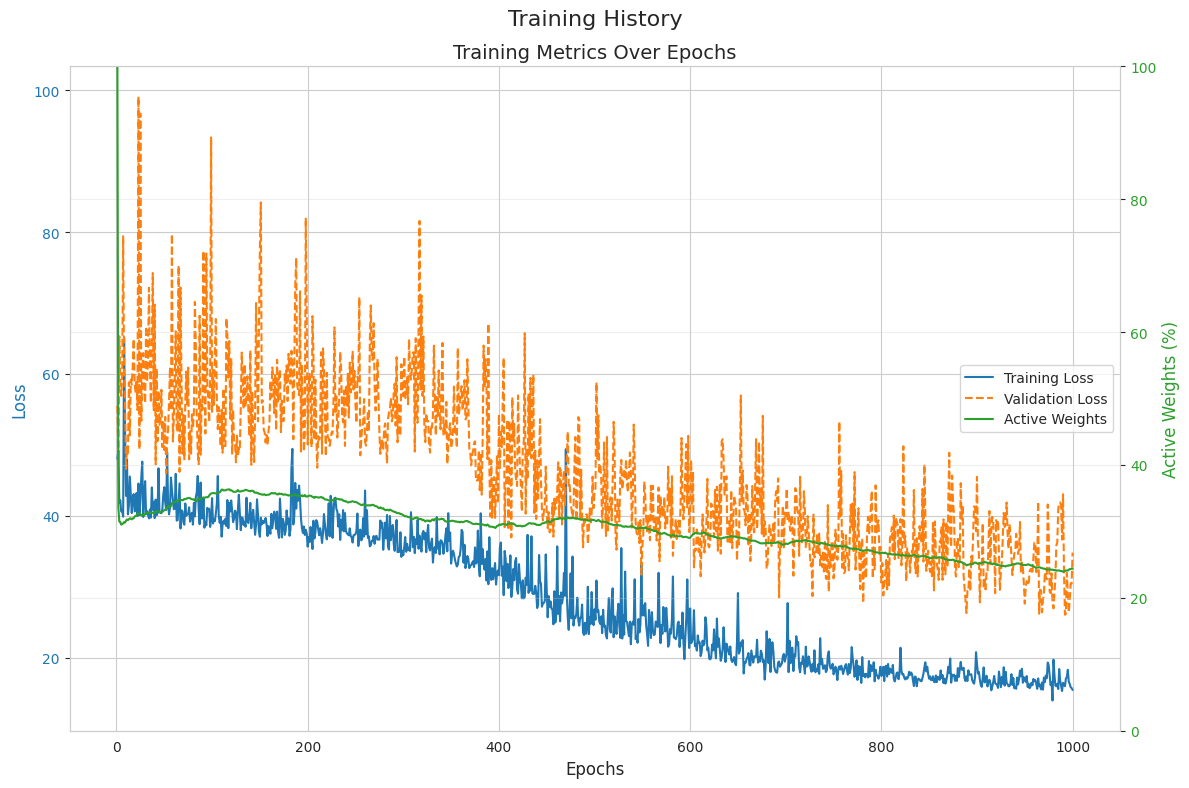

In [ ]:
plot_training_history(model_masked)

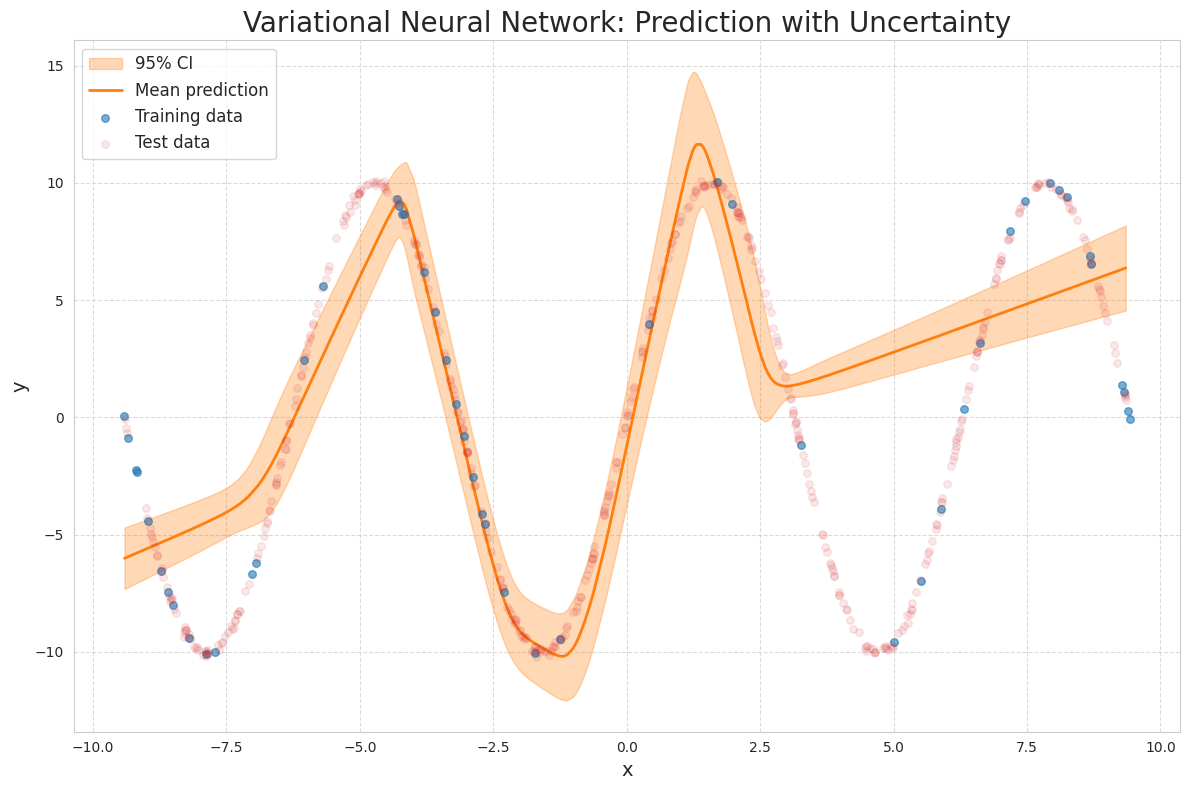

In [ ]:
# Plot the results
x_test, y_test = generate_data(n_samples=500, noise_std=0.1, x_min=-3*np.pi, x_max=3*np.pi,
                               function=np.sin, amplitude=10., distribution='uniform')


plot_uncertainty_prediction(model_masked, x_test, y_test, x_sine, y_sine, n_samples = 10000)

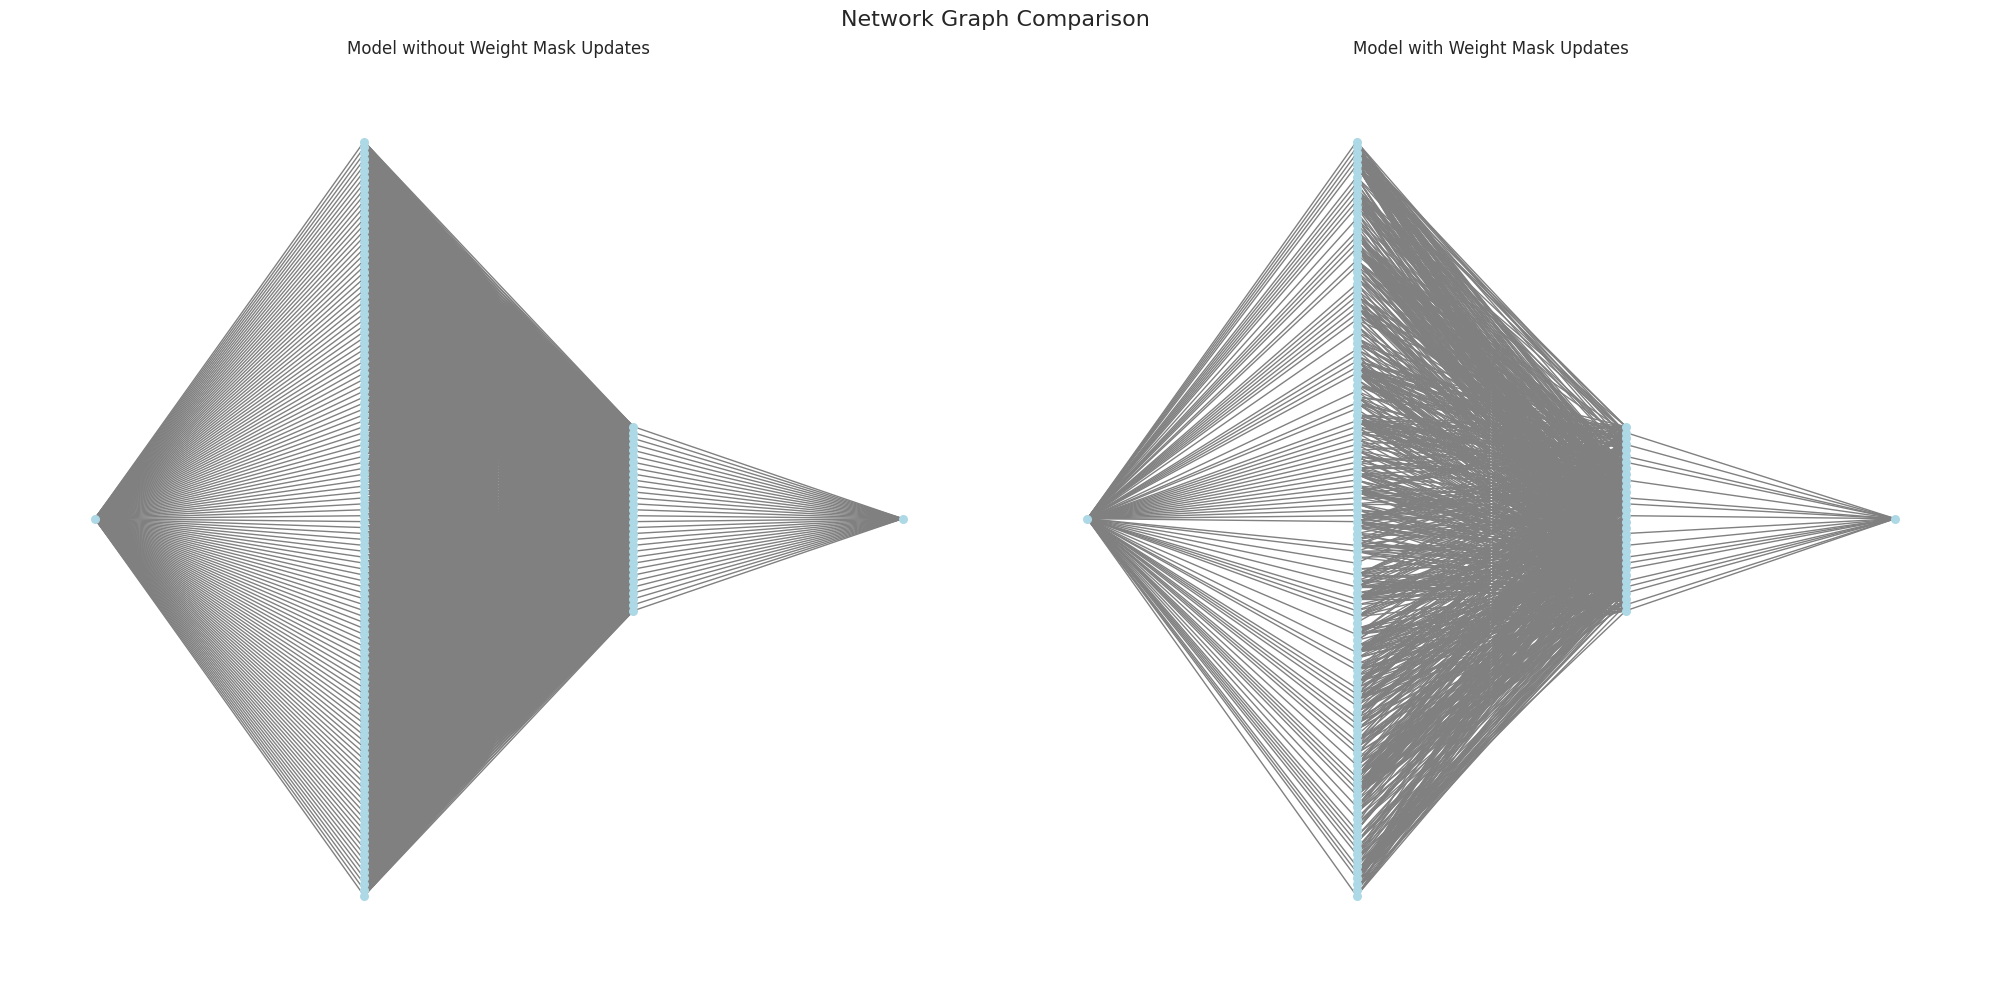

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_network_graph(model, model_masked):
    def create_graph(model):
        G = nx.DiGraph()
        layer_sizes = []
        variational_layers = []

        # First pass: determine layer sizes
        for layer in model.layers:
            if hasattr(layer, 'in_features') and hasattr(layer, 'out_features'):
                layer_sizes.append(layer.in_features)
                if isinstance(layer, VariationalDense):
                    variational_layers.append(len(layer_sizes) - 1)

        # Add the output size of the last layer
        if hasattr(model.layers[-1], 'out_features'):
            layer_sizes.append(model.layers[-1].out_features)

        max_layer_size = max(layer_sizes)

        # Second pass: create nodes
        for i, size in enumerate(layer_sizes):
            for j in range(size):
                # Center each layer vertically
                y_pos = (j - (size - 1) / 2) / max_layer_size + 0.5
                G.add_node(f"L{i}_I{j}", pos=(i/(len(layer_sizes)-1), y_pos))

        # Third pass: create edges for variational layers
        for i in variational_layers:
            layer = model.layers[i*2]
            mask = layer.weight_mask.cpu().numpy()
            for in_node in range(layer.in_features):
                for out_node in range(layer.out_features):
                    if mask[in_node, out_node]:
                        G.add_edge(f"L{i}_I{in_node}", f"L{i+1}_I{out_node}")

        return G

    G1 = create_graph(model)
    G2 = create_graph(model_masked)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle('Network Graph Comparison', fontsize=16)

    pos1 = nx.get_node_attributes(G1, 'pos')
    pos2 = nx.get_node_attributes(G2, 'pos')

    nx.draw(G1, pos1, ax=ax1, with_labels=False, node_size=30, node_color='lightblue', edge_color='gray', arrows=False)
    ax1.set_title('Model without Weight Mask Updates')

    nx.draw(G2, pos2, ax=ax2, with_labels=False, node_size=30, node_color='lightblue', edge_color='gray', arrows=False)
    ax2.set_title('Model with Weight Mask Updates')

    plt.tight_layout()
    plt.show()

# Call the function
plot_network_graph(model, model_masked)

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_network_graph(model, model_masked):
    def create_graph(model):
        G = nx.DiGraph()
        layer_sizes = []
        variational_layers = []

        # First pass: determine layer sizes
        for layer in model.layers:
            if hasattr(layer, 'in_features') and hasattr(layer, 'out_features'):
                layer_sizes.append(layer.in_features)
                if isinstance(layer, VariationalDense):
                    variational_layers.append(len(layer_sizes) - 1)

        # Add the output size of the last layer
        if hasattr(model.layers[-1], 'out_features'):
            layer_sizes.append(model.layers[-1].out_features)

        max_layer_size = max(layer_sizes)

        # Second pass: create nodes
        for i, size in enumerate(layer_sizes):
            for j in range(size):
                # Center each layer vertically
                y_pos = (j - (size - 1) / 2) / max_layer_size + 0.5
                G.add_node(f"L{i}_I{j}", pos=(i/(len(layer_sizes)-1), y_pos))

        # Third pass: create edges for variational layers
        for i in variational_layers:
            layer = model.layers[i*2]
            mask = layer.weight_mask.cpu().numpy()
            for in_node in range(layer.in_features):
                for out_node in range(layer.out_features):
                    if mask[in_node, out_node]:
                        G.add_edge(f"L{i}_I{in_node}", f"L{i+1}_I{out_node}")

        return G

    G1 = create_graph(model)
    G2 = create_graph(model_masked)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle('Network Graph Comparison', fontsize=16)

    pos1 = nx.get_node_attributes(G1, 'pos')
    pos2 = nx.get_node_attributes(G2, 'pos')

    nx.draw(G1, pos1, ax=ax1, with_labels=False, node_size=30, node_color='lightblue', edge_color='gray', arrows=False)
    ax1.set_title('Model without Weight Mask Updates')

    nx.draw(G2, pos2, ax=ax2, with_labels=False, node_size=30, node_color='lightblue', edge_color='gray', arrows=False)
    ax2.set_title('Model with Weight Mask Updates')

    plt.tight_layout()
    plt.show()

# Call the function
plot_network_graph(model, model_masked)

NameError: name 'model' is not defined

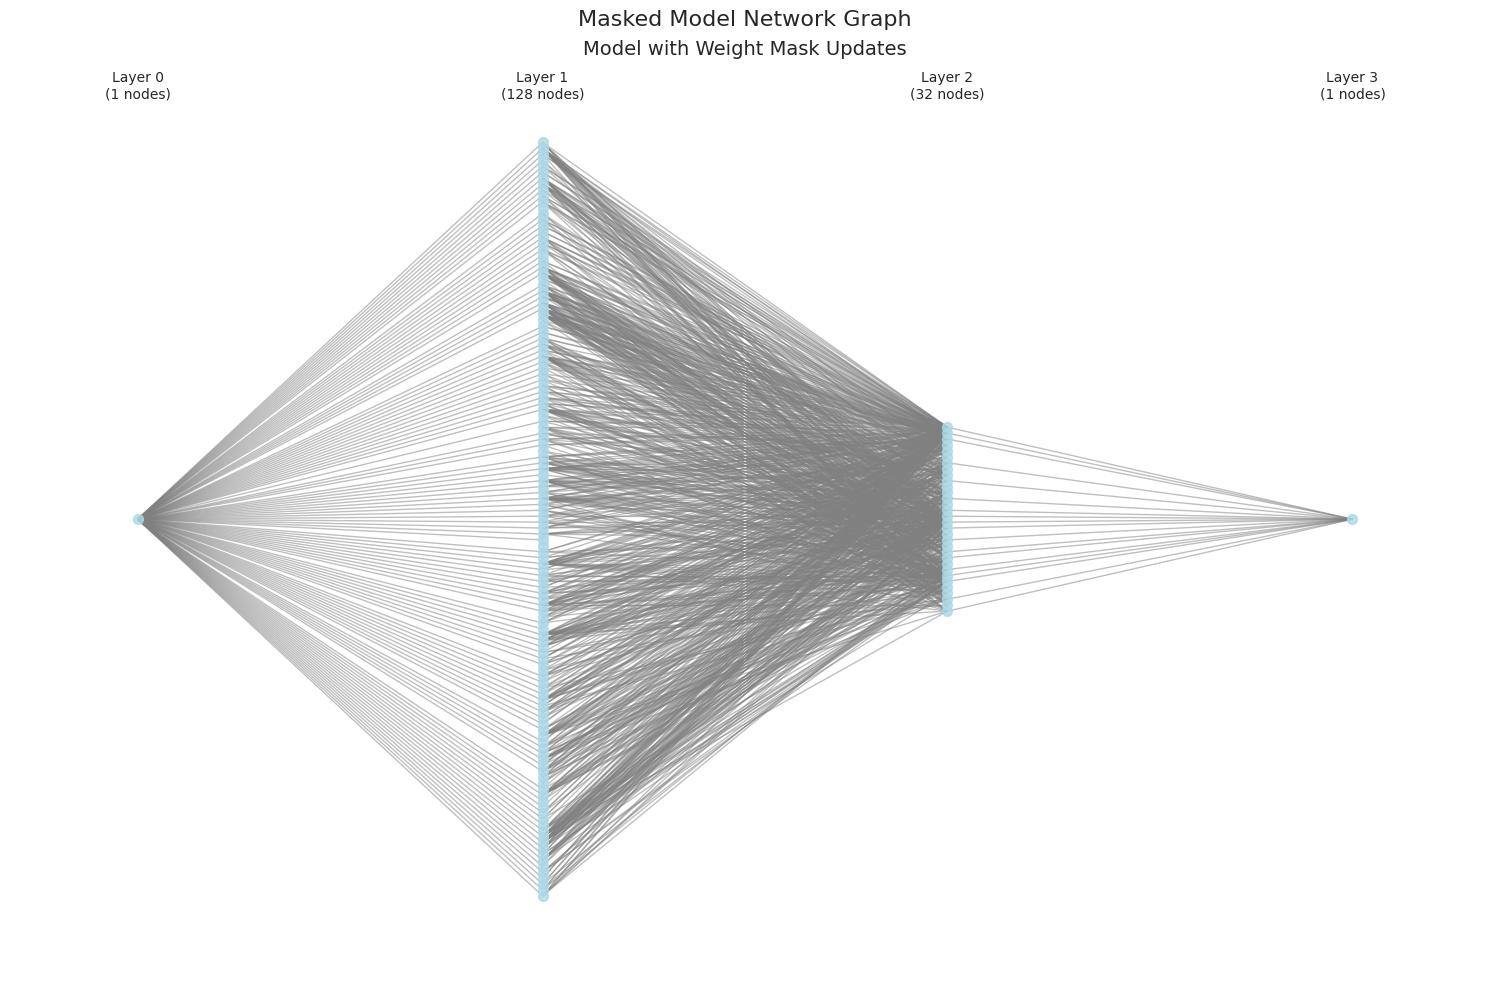

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_network_graph(model_masked):
    def create_graph(model):
        G = nx.DiGraph()
        layer_sizes = []
        variational_layers = []

        # First pass: determine layer sizes
        for layer in model.layers:
            if hasattr(layer, 'in_features') and hasattr(layer, 'out_features'):
                layer_sizes.append(layer.in_features)
                if isinstance(layer, VariationalDense):
                    variational_layers.append(len(layer_sizes) - 1)

        # Add the output size of the last layer
        if hasattr(model.layers[-1], 'out_features'):
            layer_sizes.append(model.layers[-1].out_features)

        max_layer_size = max(layer_sizes)

        # Second pass: create nodes
        for i, size in enumerate(layer_sizes):
            for j in range(size):
                # Center each layer vertically
                y_pos = (j - (size - 1) / 2) / max_layer_size + 0.5
                G.add_node(f"L{i}_I{j}", pos=(i/(len(layer_sizes)-1), y_pos))

        # Third pass: create edges for variational layers
        for i in variational_layers:
            layer = model.layers[i*2]
            mask = layer.weight_mask.cpu().numpy()
            for in_node in range(layer.in_features):
                for out_node in range(layer.out_features):
                    if mask[in_node, out_node]:
                        G.add_edge(f"L{i}_I{in_node}", f"L{i+1}_I{out_node}")

        return G

    G = create_graph(model_masked)

    fig, ax = plt.subplots(figsize=(15, 10))
    fig.suptitle('Masked Model Network Graph', fontsize=16)

    pos = nx.get_node_attributes(G, 'pos')

    # Draw edges
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', arrows=False, alpha=0.5)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color='lightblue', alpha=0.8)

    # Customize the plot
    ax.set_title('Model with Weight Mask Updates', fontsize=14)
    ax.axis('off')  # Turn off axis

    # Add layer labels
    layer_sizes = [layer.in_features for layer in model_masked.layers if hasattr(layer, 'in_features')]
    if hasattr(model_masked.layers[-1], 'out_features'):
        layer_sizes.append(model_masked.layers[-1].out_features)

    for i, size in enumerate(layer_sizes):
        ax.text(i/(len(layer_sizes)-1), 1.05, f'Layer {i}\n({size} nodes)',
                horizontalalignment='center', verticalalignment='bottom')

    plt.tight_layout()
    plt.show()

# Call the function
plot_network_graph(model_masked)

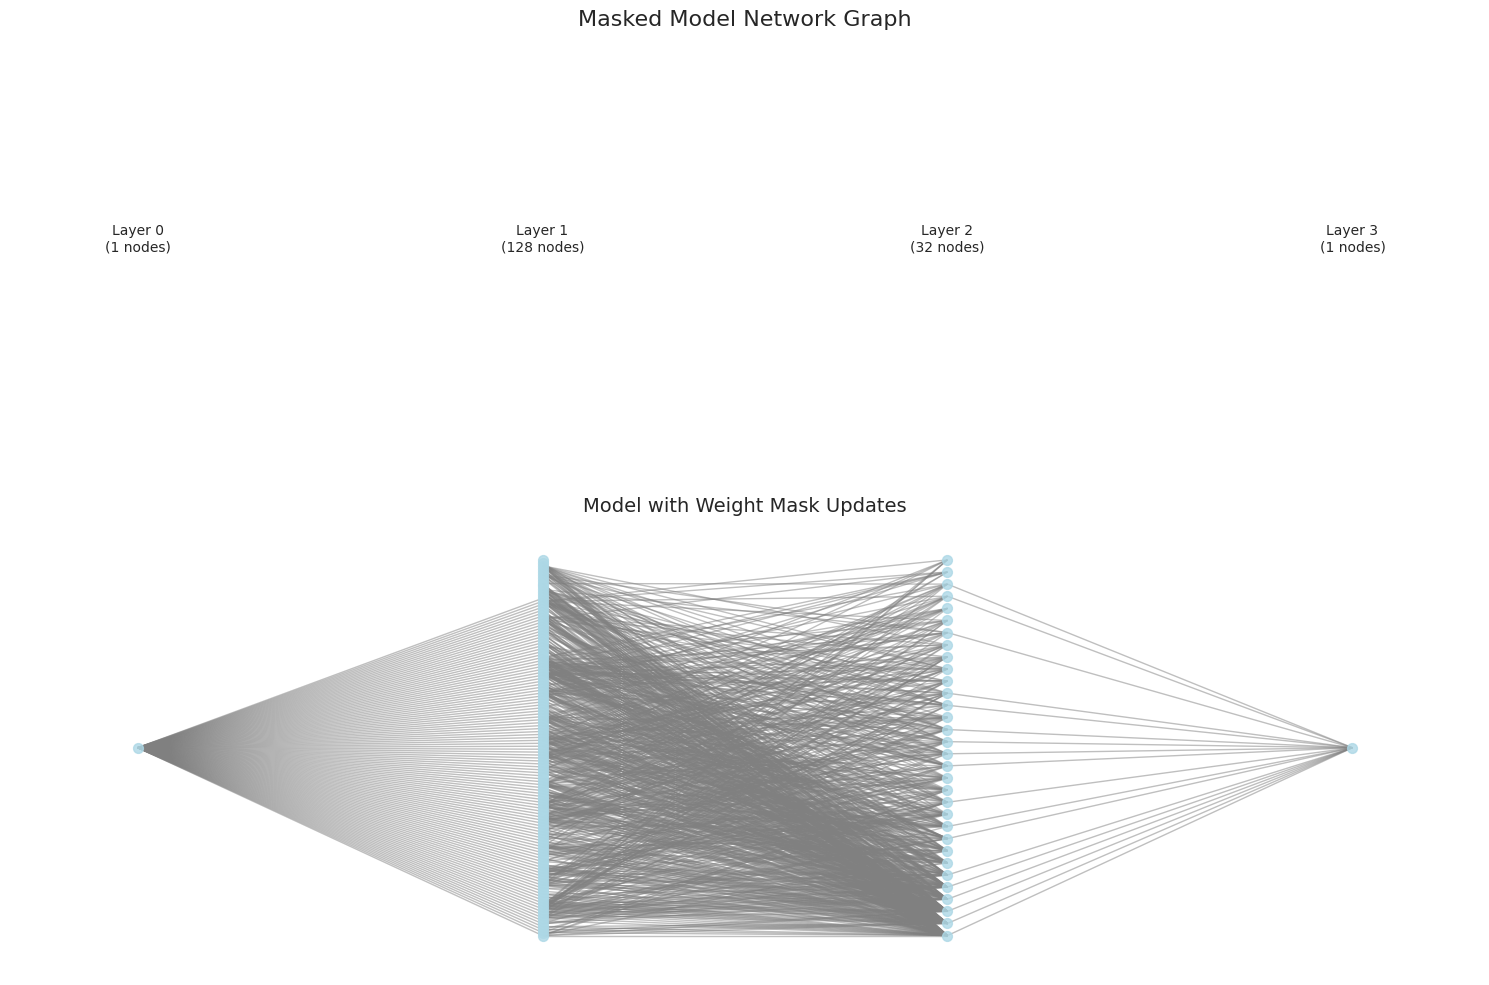

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def plot_network_graph(model_masked):
    def create_graph(model):
        G = nx.DiGraph()
        layer_sizes = []
        variational_layers = []

        # First pass: determine layer sizes
        for layer in model.layers:
            if hasattr(layer, 'in_features') and hasattr(layer, 'out_features'):
                layer_sizes.append(layer.in_features)
                if isinstance(layer, VariationalDense):
                    variational_layers.append(len(layer_sizes) - 1)

        # Add the output size of the last layer
        if hasattr(model.layers[-1], 'out_features'):
            layer_sizes.append(model.layers[-1].out_features)

        # Second pass: create nodes and edges
        for i in range(len(layer_sizes)):
            for j in range(layer_sizes[i]):
                G.add_node(f"L{i}_I{j}", layer=i)

        for i in variational_layers:
            layer = model.layers[i*2]
            mask = layer.weight_mask.cpu().numpy()
            for in_node in range(layer.in_features):
                for out_node in range(layer.out_features):
                    if mask[in_node, out_node]:
                        G.add_edge(f"L{i}_I{in_node}", f"L{i+1}_I{out_node}")

        # Position nodes
        pos = {}
        for i in range(len(layer_sizes)):
            nodes = [n for n in G.nodes() if G.nodes[n]['layer'] == i]

            # Sort nodes by degree (in-degree for hidden and output, out-degree for input)
            if i == 0:
                nodes.sort(key=lambda x: G.out_degree(x), reverse=True)
            else:
                nodes.sort(key=lambda x: G.in_degree(x), reverse=True)

            # Calculate vertical positions
            if len(nodes) == 1:
                y_positions = [0]  # Center a single node
            else:
                y_positions = np.linspace(-0.4, 0.4, len(nodes))

            for j, node in enumerate(nodes):
                pos[node] = (i / (len(layer_sizes) - 1), y_positions[j])

        return G, pos

    G, pos = create_graph(model_masked)

    fig, ax = plt.subplots(figsize=(15, 10))
    fig.suptitle('Masked Model Network Graph', fontsize=16)

    # Draw edges
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', arrows=False, alpha=0.5)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=50, node_color='lightblue', alpha=0.8)

    # Customize the plot
    ax.set_title('Model with Weight Mask Updates', fontsize=14)
    ax.axis('off')  # Turn off axis

    # Add layer labels
    layer_sizes = [layer.in_features for layer in model_masked.layers if hasattr(layer, 'in_features')]
    if hasattr(model_masked.layers[-1], 'out_features'):
        layer_sizes.append(model_masked.layers[-1].out_features)

    for i, size in enumerate(layer_sizes):
        ax.text(i/(len(layer_sizes)-1), 1.05, f'Layer {i}\n({size} nodes)',
                horizontalalignment='center', verticalalignment='bottom')

    plt.tight_layout()
    plt.show()

# Call the function
plot_network_graph(model_masked)